In [35]:
import numpy as np
import pandas as pd
import pathlib
import seaborn as sns
import scipy.io as sio
import xmltodict

from matplotlib import pyplot as plt
from PIL import Image
from pprint import pprint
from tqdm import tqdm

In [2]:
%matplotlib inline

## General order of events / goals of this notebook
1. Download the Stanford Dogs dataset to a local gitignored directory
1. Understand the size and shape of the data (class frequencies, etc.)
1. ~Experimenting with resolving individual dog breeds to American Kennel Club breed groups~
1. Testing out how to apply bounding boxes to the images to focus on the dogs that need to be classified
1. Moving files around appropriately so that `train` and `test`folders are organized by class.
1. Implementing a benchmark RandomGuess model.

## 1. Bringing the data in locally

First, we'll create a directory to hold all the downloaded files

In [3]:
data_dir = pathlib.Path('data')
if not data_dir.exists():
    data_dir.mkdir(exist_ok = False)

##### No need to rerun the next four cells unless you're starting from scratch

Here's how we receive the **list** provided by the researchers that map images to train and test sets

In [4]:
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/lists.tar -O data/temp.tar
!tar xofp data/temp.tar -C data
!rm data/temp.tar

--2020-06-17 13:38:01--  http://vision.stanford.edu/aditya86/ImageNetDogs/lists.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 481280 (470K) [application/x-tar]
Saving to: ‘data/temp.tar’

data/temp.tar       100%[===================>] 470.00K   607KB/s    in 0.8s    

2020-06-17 13:38:01 (607 KB/s) - ‘data/temp.tar’ saved [481280/481280]



In [8]:
files_downloaded = [x for x in data_dir.glob('*') if x.is_file()]
print(files_downloaded)

[PosixPath('data/file_list.mat'), PosixPath('data/test_list.mat'), PosixPath('data/train_list.mat')]


Noting that these `_list` files are of the `.mat` type, so we'll need to use scipy.io to read them as numpy arrays...

Here's a similar process for the **Annotations** files that contain bounding boxes...

In [9]:
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar -O data/temp.tar
!tar xofp data/temp.tar -C data
!rm data/temp.tar

--2020-06-17 13:44:48--  http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21852160 (21M) [application/x-tar]
Saving to: ‘data/temp.tar’

data/temp.tar       100%[===================>]  20.84M  5.11MB/s    in 6.0s    

2020-06-17 13:44:54 (3.45 MB/s) - ‘data/temp.tar’ saved [21852160/21852160]



This creates a subdirectory called `data/Annotation` that holds a bunch of really gnarly XML documents that contain the bounding boxes for each particular folder.

Finally, what I would imagine to be the longest download process, we can repeat much the same process for the actual images themselves.

In [10]:
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar -O data/temp.tar
!tar xofp data/temp.tar -C data
!rm data/temp.tar

--2020-06-17 13:49:23--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘data/temp.tar’

data/temp.tar       100%[===================>] 756.82M  1.33MB/s    in 1m 51s  

2020-06-17 13:51:14 (6.82 MB/s) - ‘data/temp.tar’ saved [793579520/793579520]



This last step took about two minutes to complete, which is good to keep in mind. It's worth noting that in order to play nicely with PyTorch's ImageFolder and DataLoader classes, I may eventually want to have the images reshuffled into `train/<class-label>` and `test/<class-label` folders. I'm not going to handle that right now, though.

## 2. Understanding the size and shape of the data

From a class frequency perspective, I can accomplish this simply by looking at the `file_list.mat`. If I want to take a look at the distribution of image dimensionality, I may need to actually start popping open files.

First, let's load in the basic `file_list` to see what's inside....

In [4]:
full_file_list = sio.loadmat(data_dir / "file_list.mat")
pprint(full_file_list)

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct '
               b' 9 08:29:09 2011',
 '__version__': '1.0',
 'annotation_list': array([[array(['n02085620-Chihuahua/n02085620_10074'], dtype='<U35')],
       [array(['n02085620-Chihuahua/n02085620_10131'], dtype='<U35')],
       [array(['n02085620-Chihuahua/n02085620_10621'], dtype='<U35')],
       ...,
       [array(['n02116738-African_hunting_dog/n02116738_9829'], dtype='<U44')],
       [array(['n02116738-African_hunting_dog/n02116738_9844'], dtype='<U44')],
       [array(['n02116738-African_hunting_dog/n02116738_9924'], dtype='<U44')]],
      dtype=object),
 'file_list': array([[array(['n02085620-Chihuahua/n02085620_10074.jpg'], dtype='<U39')],
       [array(['n02085620-Chihuahua/n02085620_10131.jpg'], dtype='<U39')],
       [array(['n02085620-Chihuahua/n02085620_10621.jpg'], dtype='<U39')],
       ...,
       [array(['n02116738-African_hunting_dog/n02116738_9829.jpg'], dtype='<U48')],


There should be 20,580 annotations within `annotation_list`, files within `file_list` and `labels`, and indeed there are.

In [4]:
for key in ["annotation_list", "file_list", "labels"]:
    print(f"Count of {key}: {full_file_list[key].flatten().size}")
    print()

Count of annotation_list: 20580

Count of file_list: 20580

Count of labels: 20580



**Note**: While I didn't copy-paste any code directly from it, I want to acknowledge [this Medium post](https://towardsdatascience.com/transfer-learning-with-convolutional-neural-networks-in-pytorch-dd09190245ce) as particularly influential with respect to the types of visuals I _did_ end up making to explore this data.

### Part 1: Class distribution

Here's a simple way to get at the appropriate counts across _both train and test sets_...

In [6]:
breed_labels, breed_counts = np.unique(full_file_list["labels"].flatten(), 
                                       return_counts = True)
print(breed_labels, breed_counts)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120] [152 185 252 149 214 188 196 172 172 239 175 195 187 171 159 153 157 148
 151 218 182 187 188 196 151 200 232 160 155 164 182 172 179 169 172 185
 164 157 197 202 202 197 196 180 182 154 157 155 158 206 183 156 169 186
 152 151 150 171 167 152 154 161 155 153 152 150 159 150 159 151 150 150
 154 150 150 152 153 154 169 157 153 150 150 152 152 150 184 168 218 151
 202 151 156 152 159 156 170 150 178 192 150 209 200 210 195 213 218 219
 196 158 153 181 155 151 155 159 155 156 150 169]


The only other thing we'd need to make the visual a bit more clear is the actual _names_ that the numeric labels correspond to. We should be able to get this as follows ...

In [5]:
# Refactored into preprocess.py with docstrings 

def get_breed_name(file_name_arr):
    return [x.item(0).split("/")[0].split("-")[1] for x in file_name_arr]

def map_breed_labels_to_names(file_list):
    name_label_map = {}
    name_list = np.apply_along_axis(get_breed_name, 0, file_list)
    unique_names, og_indexes = np.unique(name_list, return_index = True)
    for i, name in enumerate(unique_names[np.argsort(og_indexes)]):
        name_label_map[i + 1] = name
    return name_label_map

In [8]:
labels_to_breeds = map_breed_labels_to_names(file_list = full_file_list["file_list"])

In [9]:
labels_to_breeds

{1: 'Chihuahua',
 2: 'Japanese_spaniel',
 3: 'Maltese_dog',
 4: 'Pekinese',
 5: 'Shih',
 6: 'Blenheim_spaniel',
 7: 'papillon',
 8: 'toy_terrier',
 9: 'Rhodesian_ridgeback',
 10: 'Afghan_hound',
 11: 'basset',
 12: 'beagle',
 13: 'bloodhound',
 14: 'bluetick',
 15: 'black',
 16: 'Walker_hound',
 17: 'English_foxhound',
 18: 'redbone',
 19: 'borzoi',
 20: 'Irish_wolfhound',
 21: 'Italian_greyhound',
 22: 'whippet',
 23: 'Ibizan_hound',
 24: 'Norwegian_elkhound',
 25: 'otterhound',
 26: 'Saluki',
 27: 'Scottish_deerhound',
 28: 'Weimaraner',
 29: 'Staffordshire_bullterrier',
 30: 'American_Staffordshire_terrier',
 31: 'Bedlington_terrier',
 32: 'Border_terrier',
 33: 'Kerry_blue_terrier',
 34: 'Irish_terrier',
 35: 'Norfolk_terrier',
 36: 'Norwich_terrier',
 37: 'Yorkshire_terrier',
 38: 'wire',
 39: 'Lakeland_terrier',
 40: 'Sealyham_terrier',
 41: 'Airedale',
 42: 'cairn',
 43: 'Australian_terrier',
 44: 'Dandie_Dinmont',
 45: 'Boston_bull',
 46: 'miniature_schnauzer',
 47: 'giant_schn

This `labels_to_breeds` mapping should be consistent across the train and test lists as well. More importantly in the immediate term, we can use it to provide axis labels to our `breed_counts` from earlier.

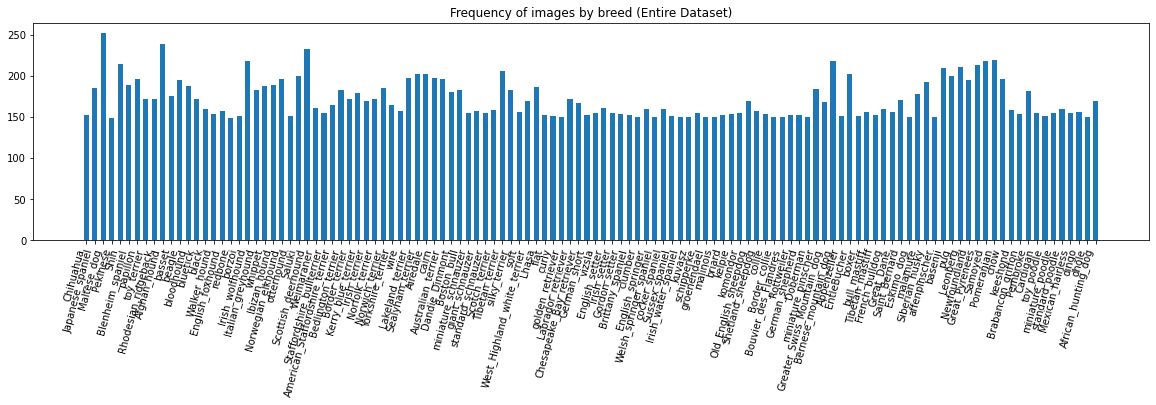

In [11]:
fig, ax = plt.subplots(figsize = (20,4))
plt.bar(x = breed_labels.tolist(), 
        height = breed_counts.tolist(),
        width = 0.6,
        align = 'center')
plt.xticks(ticks = breed_labels.tolist(),
          labels = [labels_to_breeds[k] for k in breed_labels.tolist()],
          rotation = 75,
          ha = 'right')
plt.title("Frequency of images by breed (Entire Dataset)")
plt.show()

So, while this isn't the most legible plot I've ever made in my life, we can see at a glance that **most of our 120 breeds are represented by somewhere between 150 and 200 images** across both train and test sets.

In [12]:
over200breeds = breed_labels[np.where(breed_counts > 200)].tolist()
for label in over200breeds:
    print(f"{labels_to_breeds[label]} has {breed_counts[label - 1]} images")

Maltese_dog has 252 images
Shih has 214 images
Afghan_hound has 239 images
Irish_wolfhound has 218 images
Scottish_deerhound has 232 images
Sealyham_terrier has 202 images
Airedale has 202 images
Tibetan_terrier has 206 images
Bernese_mountain_dog has 218 images
EntleBucher has 202 images
basenji has 209 images
Leonberg has 210 images
Great_Pyrenees has 213 images
Samoyed has 218 images
Pomeranian has 219 images


In [13]:
under150breeds = breed_labels[np.where(breed_counts < 150)].tolist()
for label in under150breeds:
    print(f"{labels_to_breeds[label]} has {breed_counts[label - 1]} images")

Pekinese has 149 images
redbone has 148 images


What's perhaps most important for us to consider is what this distribution looks like in the _training_ set...

In [6]:
train_file_list = sio.loadmat(data_dir / "train_list.mat")
train_labels, train_counts = np.unique(train_file_list["labels"].flatten(), 
                                       return_counts = True)

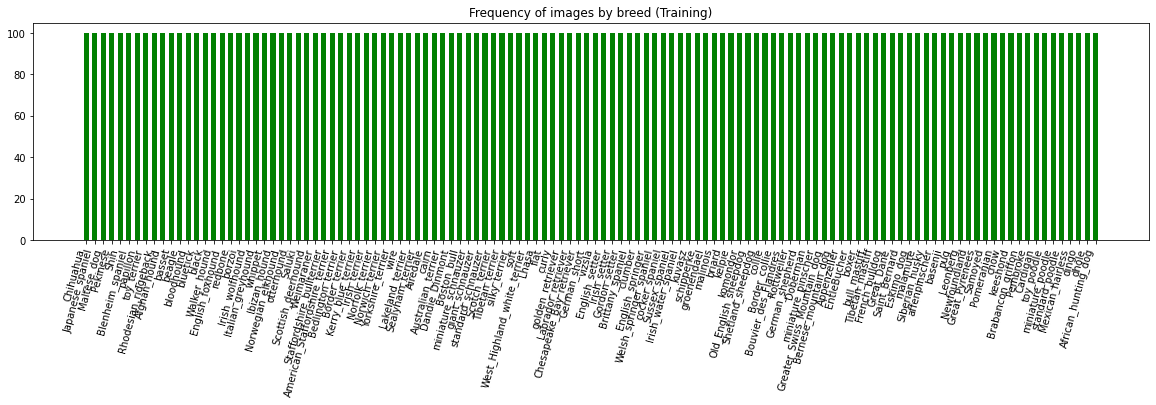

In [16]:
fig, ax = plt.subplots(figsize = (20,4))
plt.bar(x = train_labels.tolist(), 
        height = train_counts.tolist(),
        width = 0.6,
        color = 'green',
        align = 'center')
plt.xticks(ticks = train_labels.tolist(),
          labels = [labels_to_breeds[k] for k in train_labels.tolist()],
          rotation = 75,
          ha = 'right')
plt.title("Frequency of images by breed (Training)")
plt.show()

It's important to note here that the **training instances are perfectly balanced across each of our 120 breeds.** That is to say, we have 100 training images for each of the breeds we want to predict.

This makes me skeptical as to whether my proposed third step of resolving individual breeds to breed groups is actually going to be necessary: we have a good number of training instances in each category, and particularly if we need to set up our `train` and `test` directories differently to set up for training, I wouldn't want to take this step lightly.

For the time being, I might skip my proposed mapping of breeds to working groups, and only come back to it if something goes horrendously wrong with the breed-level predicitons.

### Part 2: Image Size distribution

What I'd ultimately like to try and do here is take a look at the height and width of each of our images, just to understand how uniform they are in size.

Let's start by just looking at a test image...

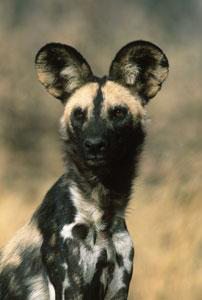

In [19]:
test_jpg = "n02116738-African_hunting_dog/n02116738_9829.jpg"
test_path = data_dir / "Images" / test_jpg
test_img = Image.open(test_path)
display(test_img)

The `size` attribute of a PIL image apparently returns a `(width, height)` tuple...

In [20]:
test_img.size

(202, 300)

So if we iterate through the files in our global `file_list`, extract the heights and widths of each image, and then save them to a temporary dataframe, we should be able to relatively quickly visualize the joint distribution of each `(height, width)` pair.

In [25]:
hw_dicts = []
for jpg_ext in full_file_list["file_list"].flatten():
    test_path = data_dir / "Images" / jpg_ext.item(0)
    test_img = Image.open(test_path)
    hw_dicts.append({"width": test_img.size[0], "height":test_img.size[1]})
hw_df = pd.DataFrame(data = hw_dicts)

In [26]:
hw_df.shape

(20580, 2)

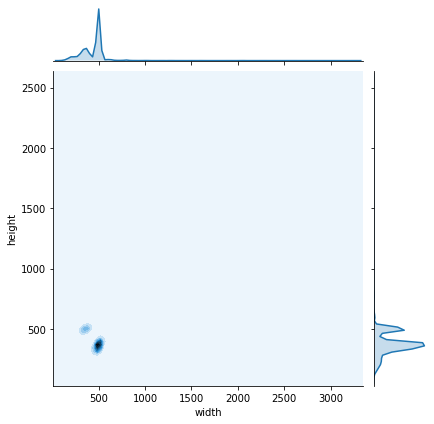

In [38]:
sns.jointplot(x = "width", y = "height", data = hw_df, kind = "kde")

Cool, so apparently we a handful of outlier images that are really big, which is kind of messing up this visual a bit.

In [28]:
hw_df.describe()

,width,height
count,20580.000000,20580.000000
mean,442.531876,385.861224
std,142.792308,124.863446
min,97.000000,100.000000
25%,361.000000,333.000000
50%,500.000000,375.000000
75%,500.000000,453.000000
max,3264.000000,2562.000000


But if we boot out all images that are smaller thant `1000 X 1000`, we're still keeping 99% of our data.

In [34]:
len(hw_df.loc[(hw_df.height < 1000) & (hw_df.width < 1000)])

20429

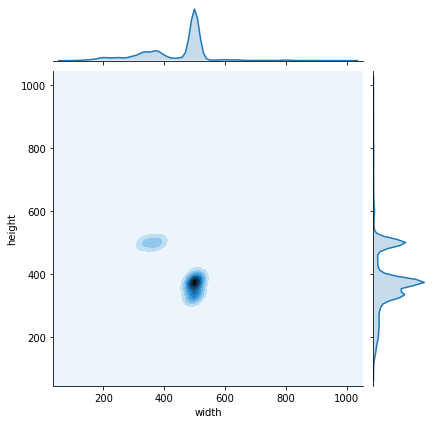

In [37]:
sns.jointplot(x = "width", y = "height", 
              data = hw_df.loc[(hw_df.height < 1000) & (hw_df.width < 1000)], 
              kind = "kde")

This is the clearest indication we have so far that **most of our images are in the 500 X 350** size range. There's a much smaller contingent of images that are essentially the transpose of that: **350 X 500**.

Of course, one thing to keep in mind here is that this is before we applied the bounding boxes...

## 3. Cropping Train and Test Images Down to Bounding Boxes

In [7]:
test_jpg = "n02116738-African_hunting_dog/n02116738_9829.jpg"
test_path = data_dir / "Images" / test_jpg

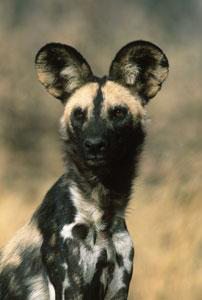

In [8]:
display(Image.open(test_path))

In [24]:
train_file_list['file_list'].flatten()[-2]

array(['n02116738-African_hunting_dog/n02116738_9333.jpg'], dtype='<U48')

In [28]:
# Refactored into preprocess.py with docstrings 

def get_image_path(file_name_arr, root_dir):
    file_path = file_name_arr.item()
    return pathlib.Path(root_dir) / "Images" / file_path


def get_annotation_path(file_name_arr, root_dir):
    file_path = pathlib.Path(file_name_arr.item())
    annot_file_name = file_path.stem
    breed_dir = file_path.parent.stem
    return pathlib.Path(root_dir) / "Annotation" / breed_dir / annot_file_name

In [20]:
get_annotation_path(file_name_arr = train_file_list['file_list'].flatten()[0], 
                    root_dir = data_dir).is_file()

True

In [22]:
get_image_path(file_name_arr = train_file_list['file_list'].flatten()[0],
               root_dir = data_dir).is_file()

True

In [58]:
# Refactored into preprocess.py with docstrings 

def extract_bbox_coords(annot_path):
    with open(annot_path, "r") as fd:
        raw_xml = xmltodict.parse(fd.read())
    coord_info = raw_xml["annotation"]["object"]
    if isinstance(coord_info, list):
        return [coord_tuple(v["bndbox"]) for v in coord_info]
    return coord_tuple(coord_info["bndbox"])


def coord_tuple(bbox_dict):
    left = int(bbox_dict["xmin"])
    upper = int(bbox_dict["ymin"])
    right = int(bbox_dict["xmax"])
    lower = int(bbox_dict["ymax"])
    return (left, upper, right, lower)

This is a horrifying chihuaua...

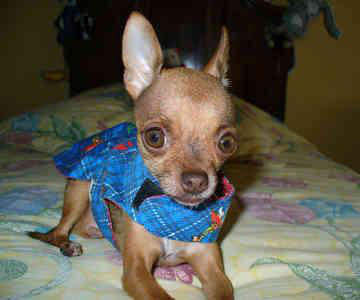

In [26]:
foo_file = train_file_list['file_list'].flatten()[0]
foo_img = get_image_path(file_name_arr = foo_file, root_dir = 'data')
display(Image.open(foo_img))

In [29]:
foo_annot = get_annotation_path(file_name_arr = foo_file, root_dir = 'data')
extract_bbox_coords(foo_annot)

(30, 14, 236, 298)

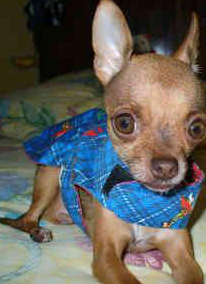

In [30]:
display(Image.open(foo_img).crop(box = extract_bbox_coords(foo_annot)))

## 4. Setting up our `data` directory in a PyTorch friendly way

In order to approprately use [PyTorch's ImageFolder](https://pytorch.org/docs/master/torchvision/datasets.html#imagefolder) data loader, we need to organize our base data directory like follows before we upload it to our default S3 bucket that PyTorch can access.

```
data/
    train/
         breed-01/
             file.jpg
             file.jpg
         breed-02
    
    test/
         breed-01
         breed-02

```

We can accomplish this using the `train_list.mat` and `test_list.mat` objects. To make the logistics a little easier, I am also going to crop images down to their bounding boxes _before_ saving them in this label-oriented directory structure. So the process is like this:

for every file in the `file_list`s included `train_list.mat` or `test_list.mat`:

- Create a class directory to hold the eventual image (see above)
- Get the path the to the raw image (*already have a function for this*)
- Get the path to the bounding box file (*already have a function for this*)
- Extract the bounding box coordinates (*already have a function for this*)
- Crop down the raw image
- Save that cropped version into the class directory

So the only piece I need to take care of is creating a class directory ...

In [41]:
# Refactored into preprocess.py with docstrings 

def get_class_dir(file_name_arr, root_dir, dataset_type):
    if dataset_type not in ["train","valid","test"]:
        raise NotImplementedError("Put image in `train`, `test`, or `valid` folder...")
    if not isinstance(root_dir, pathlib.PosixPath):
        root_dir = pathlib.Path(root_dir)
    class_name = get_breed_name(file_name_arr)[0]
    return root_dir / dataset_type / class_name

In [40]:
get_breed_name(foo_file)[0]

'Chihuahua'

In [47]:
foo_img.name

'n02085620_5927.jpg'

In [60]:
foo_img.stem

'n02085620_5927'

In [62]:
foo_img.suffix

'.jpg'

In [44]:
get_class_dir(foo_file, data_dir, 'train')

PosixPath('data/train/Chihuahua')

In [59]:
get_class_dir(foo_file, data_dir, 'test').name

'Chihuahua'

In [83]:
# Refactored into preprocess.py with docstrings 

def crop_and_ensure_RGB(img_obj, bbox_tuple):
    cropped = img_obj.crop(box = bbox_tuple)
    if cropped.mode != "RGB":
        print("Applying RGB compression")
        cropped = cropped.convert("RGB")
    return cropped


def prepare_image_folder(file_list_arr, root_dir, dataset_type,
                         log_multiples = True):
    mult_count = 0
    mult_img = 0
    for file_name_arr in tqdm(file_list_arr.flatten()):
        class_dir = get_class_dir(file_name_arr, root_dir, dataset_type)
        img_path = get_image_path(file_name_arr, root_dir)
        annot_path = get_annotation_path(file_name_arr, root_dir)
        bound_box = extract_bbox_coords(annot_path)
        if not class_dir.exists():
            class_dir.mkdir(parents = True, exist_ok = True)
        raw_img = Image.open(img_path)
        if isinstance(bound_box, tuple):
            sv_img = crop_and_ensure_RGB(raw_img, bound_box)
            sv_img.save(class_dir / img_path.name)
            continue
        if log_multiples:
            N = len(bound_box)
            mult_count += N
            mult_img += 1
            breed = class_dir.name
            print(f"Found {N} {breed}s in {img_path.name}")
        for i, bbox in enumerate(bound_box):
            sv_img = crop_and_ensure_RGB(raw_img, bbox)
            sv_name = f"{img_path.stem}-{i+1}{img_path.suffix}"
            sv_img.save(class_dir / sv_name)
    if log_multiples:
        print(f"\tTotal of {mult_count} multiples found in {mult_img} images")
    print(f"Finished preparing {dataset_type} data!!")

Here's what we would do to create the `train` folder

In [49]:
prepare_image_folder(file_list_arr = train_file_list["file_list"],
                     root_dir = "data",
                     dataset_type = "train")

  0%|          | 27/12000 [00:00<01:17, 154.13it/s]


TypeError: list indices must be integers or slices, not str

**Kink Number 1:**
Ah, of course it couldn't be that easy ... some of the images have multiple bounding boxes (_because they contain multiple dogs_) and we can see thata by understanding whether the `object` portion of the Annotation xml is a list or not.

In [53]:
train_file_list["file_list"].flatten()[27]

array(['n02085620-Chihuahua/n02085620_1152.jpg'], dtype='<U38')

In [54]:
err = get_annotation_path(train_file_list["file_list"].flatten()[27], root_dir='data')

In [55]:
err

PosixPath('data/Annotation/n02085620-Chihuahua/n02085620_1152')

In [56]:
with open(meh , "r") as fd:
    err_xml = xmltodict.parse(fd.read())

In [57]:
err_xml["annotation"]["object"]

[OrderedDict([('name', 'Chihuahua'),
              ('pose', 'Unspecified'),
              ('truncated', '0'),
              ('difficult', '0'),
              ('bndbox',
               OrderedDict([('xmin', '3'),
                            ('ymin', '81'),
                            ('xmax', '156'),
                            ('ymax', '225')]))]),
 OrderedDict([('name', 'Chihuahua'),
              ('pose', 'Unspecified'),
              ('truncated', '0'),
              ('difficult', '0'),
              ('bndbox',
               OrderedDict([('xmin', '147'),
                            ('ymin', '65'),
                            ('xmax', '323'),
                            ('ymax', '324')]))]),
 OrderedDict([('name', 'Chihuahua'),
              ('pose', 'Unspecified'),
              ('truncated', '0'),
              ('difficult', '0'),
              ('bndbox',
               OrderedDict([('xmin', '391'),
                            ('ymin', '111'),
                            ('xmax', 

Although it may risk upsetting the `perfectly balanced` nature of our training set, for the time being I am going to try and save _all_ of the dogs in an image, if there are multiple ones. This basically involves two tweaks

1. Updating `extract_bbox_coords()` above to return a list of tuples if it detects multiple bounding boxes.
2. Updating our `crop_and_move()` pipeline to behave differently it detects a list. The main thing that needs to happen here will be to save a modified **image name**. (*eg. instead of 'n02085620_1152.jpg', saving files like 'n02085620_1152-1.jpg', 'n02085620_1152-2.jpg')

Try number two ...

In [66]:
prepare_image_folder(file_list_arr = train_file_list["file_list"],
                     root_dir = "data",
                     dataset_type = "train")

  0%|          | 50/12000 [00:00<01:15, 158.84it/s]

Found 3 Chihuahuas in n02085620_1152.jpg
Found 2 Chihuahuas in n02085620_473.jpg


  1%|          | 102/12000 [00:00<01:10, 167.81it/s]

Found 2 Chihuahuas in n02085620_575.jpg
Found 2 Chihuahuas in n02085620_5661.jpg


  1%|▏         | 159/12000 [00:00<01:05, 179.57it/s]

Found 2 Japanese_spaniels in n02085782_2635.jpg
Found 2 Japanese_spaniels in n02085782_935.jpg
Found 2 Japanese_spaniels in n02085782_2207.jpg
Found 2 Japanese_spaniels in n02085782_3516.jpg


  2%|▏         | 196/12000 [00:01<01:12, 163.54it/s]

Found 3 Japanese_spaniels in n02085782_2010.jpg
Found 2 Japanese_spaniels in n02085782_2886.jpg
Found 2 Japanese_spaniels in n02085782_3071.jpg


  2%|▏         | 213/12000 [00:01<01:14, 158.98it/s]

Found 3 Japanese_spaniels in n02085782_2914.jpg
Found 2 Maltese_dogs in n02085936_3863.jpg


  2%|▏         | 284/12000 [00:01<01:10, 166.53it/s]

Found 2 Maltese_dogs in n02085936_3292.jpg
Found 2 Maltese_dogs in n02085936_2889.jpg


  3%|▎         | 319/12000 [00:01<01:09, 167.54it/s]

Found 2 Maltese_dogs in n02085936_8745.jpg
Found 2 Maltese_dogs in n02085936_16565.jpg
Found 2 Maltese_dogs in n02085936_9632.jpg
Found 2 Maltese_dogs in n02085936_10610.jpg


  3%|▎         | 372/12000 [00:02<01:14, 155.81it/s]

Found 2 Pekineses in n02086079_8127.jpg
Found 2 Pekineses in n02086079_20762.jpg


  4%|▎         | 425/12000 [00:02<01:12, 160.57it/s]

Found 2 Shihs in n02086240_789.jpg
Found 2 Shihs in n02086240_1725.jpg
Found 2 Shihs in n02086240_6587.jpg
Found 2 Shihs in n02086240_11622.jpg


  4%|▍         | 495/12000 [00:03<01:09, 164.62it/s]

Found 2 Shihs in n02086240_10785.jpg
Found 4 Shihs in n02086240_7205.jpg


  4%|▍         | 529/12000 [00:03<01:15, 151.39it/s]

Found 2 Blenheim_spaniels in n02086646_2772.jpg


  5%|▍         | 595/12000 [00:03<01:17, 147.23it/s]

Found 2 Blenheim_spaniels in n02086646_1342.jpg
Found 2 Blenheim_spaniels in n02086646_3466.jpg
Found 2 Blenheim_spaniels in n02086646_3968.jpg
Found 2 Blenheim_spaniels in n02086646_814.jpg
Found 2 Blenheim_spaniels in n02086646_2871.jpg
Found 2 Blenheim_spaniels in n02086646_127.jpg


  6%|▌         | 663/12000 [00:04<01:11, 157.53it/s]

Found 2 papillons in n02086910_4330.jpg
Found 2 papillons in n02086910_2909.jpg
Found 2 papillons in n02086910_5408.jpg
Found 2 papillons in n02086910_6882.jpg
Found 2 papillons in n02086910_2550.jpg


  6%|▌         | 714/12000 [00:04<01:10, 160.99it/s]

Found 2 papillons in n02086910_7301.jpg
Found 2 papillons in n02086910_5707.jpg
Found 2 toy_terriers in n02087046_2316.jpg


  7%|▋         | 841/12000 [00:05<01:08, 162.62it/s]

Found 2 Rhodesian_ridgebacks in n02087394_7544.jpg
Found 2 Rhodesian_ridgebacks in n02087394_3311.jpg


  7%|▋         | 879/12000 [00:05<01:05, 170.59it/s]

Found 2 Rhodesian_ridgebacks in n02087394_9189.jpg


  8%|▊         | 916/12000 [00:05<01:08, 162.95it/s]

Found 2 Rhodesian_ridgebacks in n02087394_3515.jpg
Found 3 Afghan_hounds in n02088094_4464.jpg
Found 2 Afghan_hounds in n02088094_4517.jpg
Found 3 Afghan_hounds in n02088094_13742.jpg
Found 2 Afghan_hounds in n02088094_2559.jpg
Found 2 Afghan_hounds in n02088094_4678.jpg
Found 2 Afghan_hounds in n02088094_4759.jpg
Found 2 Afghan_hounds in n02088094_11006.jpg
Found 2 Afghan_hounds in n02088094_7131.jpg
Found 2 Afghan_hounds in n02088094_4511.jpg


  8%|▊         | 966/12000 [00:06<01:10, 155.59it/s]

Found 2 Afghan_hounds in n02088094_266.jpg
Found 3 Afghan_hounds in n02088094_3641.jpg
Found 3 Afghan_hounds in n02088094_688.jpg
Found 3 Afghan_hounds in n02088094_4497.jpg
Found 3 Afghan_hounds in n02088094_522.jpg
Found 2 Afghan_hounds in n02088094_11584.jpg
Found 2 Afghan_hounds in n02088094_11432.jpg


  8%|▊         | 999/12000 [00:06<01:09, 158.35it/s]

Found 2 Afghan_hounds in n02088094_5812.jpg
Found 2 Afghan_hounds in n02088094_4072.jpg
Found 3 Afghan_hounds in n02088094_227.jpg
Found 2 Afghan_hounds in n02088094_3613.jpg


  9%|▊         | 1032/12000 [00:06<01:10, 155.18it/s]

Found 2 bassets in n02088238_11635.jpg
Found 2 bassets in n02088238_13847.jpg
Found 3 bassets in n02088238_9778.jpg
Found 2 bassets in n02088238_5441.jpg
Found 2 bassets in n02088238_9986.jpg


  9%|▉         | 1066/12000 [00:06<01:08, 159.51it/s]

Found 2 bassets in n02088238_9789.jpg
Found 2 bassets in n02088238_10870.jpg


  9%|▉         | 1116/12000 [00:06<01:09, 156.76it/s]

Found 2 bassets in n02088238_10028.jpg
Found 2 beagles in n02088364_16210.jpg
Found 2 beagles in n02088364_12710.jpg
Found 2 beagles in n02088364_12794.jpg


 10%|▉         | 1149/12000 [00:07<01:09, 156.65it/s]

Found 2 beagles in n02088364_16493.jpg


 10%|▉         | 1198/12000 [00:07<01:09, 155.46it/s]

Found 2 beagles in n02088364_10362.jpg
Found 2 beagles in n02088364_3752.jpg
Found 2 beagles in n02088364_11130.jpg
Found 2 beagles in n02088364_10731.jpg


 11%|█         | 1281/12000 [00:08<01:08, 155.77it/s]

Found 4 bloodhounds in n02088466_9167.jpg
Found 2 bloodhounds in n02088466_7046.jpg


 11%|█▏        | 1366/12000 [00:08<01:09, 153.96it/s]

Found 2 blueticks in n02088632_205.jpg


 13%|█▎        | 1541/12000 [00:09<01:09, 150.66it/s]

Found 2 Walker_hounds in n02089867_126.jpg
Found 2 Walker_hounds in n02089867_3449.jpg
Found 2 Walker_hounds in n02089867_2227.jpg
Found 2 Walker_hounds in n02089867_880.jpg


 13%|█▎        | 1560/12000 [00:09<01:05, 158.52it/s]

Found 2 Walker_hounds in n02089867_724.jpg
Found 2 Walker_hounds in n02089867_1918.jpg


 13%|█▎        | 1614/12000 [00:10<01:09, 148.63it/s]

Found 2 Walker_hounds in n02089867_55.jpg
Found 2 Walker_hounds in n02089867_2221.jpg
Found 2 English_foxhounds in n02089973_3651.jpg
Found 4 English_foxhounds in n02089973_2791.jpg
Found 2 English_foxhounds in n02089973_2756.jpg
Found 2 English_foxhounds in n02089973_2045.jpg


 14%|█▍        | 1651/12000 [00:10<01:05, 157.04it/s]

Found 3 English_foxhounds in n02089973_4185.jpg
Found 2 English_foxhounds in n02089973_1907.jpg
Found 3 English_foxhounds in n02089973_97.jpg
Found 4 English_foxhounds in n02089973_2415.jpg
Found 2 English_foxhounds in n02089973_2716.jpg
Found 4 English_foxhounds in n02089973_1799.jpg


 14%|█▍        | 1692/12000 [00:10<00:58, 174.92it/s]

Found 2 English_foxhounds in n02089973_2500.jpg
Found 2 English_foxhounds in n02089973_32.jpg
Found 3 English_foxhounds in n02089973_2781.jpg
Found 3 English_foxhounds in n02089973_4055.jpg
Found 2 English_foxhounds in n02089973_2249.jpg
Found 4 English_foxhounds in n02089973_1132.jpg
Found 3 English_foxhounds in n02089973_3147.jpg


 15%|█▍        | 1764/12000 [00:11<01:02, 163.74it/s]

Found 2 redbones in n02090379_5525.jpg
Found 2 redbones in n02090379_4875.jpg


 15%|█▍        | 1798/12000 [00:11<01:02, 162.48it/s]

Found 2 redbones in n02090379_4673.jpg
Found 2 borzois in n02090622_4527.jpg


 15%|█▌        | 1848/12000 [00:11<01:06, 153.49it/s]

Found 2 borzois in n02090622_8380.jpg
Found 2 borzois in n02090622_7705.jpg
Found 2 borzois in n02090622_7663.jpg
Found 3 borzois in n02090622_7858.jpg
Found 3 borzois in n02090622_7962.jpg


 16%|█▌        | 1899/12000 [00:11<01:02, 160.75it/s]

Found 2 borzois in n02090622_7351.jpg
Found 3 borzois in n02090622_8045.jpg
Found 2 borzois in n02090622_9883.jpg
Found 3 Irish_wolfhounds in n02090721_3149.jpg
Found 3 Irish_wolfhounds in n02090721_4276.jpg


 16%|█▌        | 1932/12000 [00:12<01:05, 154.85it/s]

Found 2 Irish_wolfhounds in n02090721_5722.jpg
Found 3 Irish_wolfhounds in n02090721_4353.jpg
Found 2 Irish_wolfhounds in n02090721_4290.jpg
Found 2 Irish_wolfhounds in n02090721_1222.jpg


 16%|█▋        | 1965/12000 [00:12<01:04, 155.88it/s]

Found 2 Irish_wolfhounds in n02090721_2442.jpg
Found 2 Irish_wolfhounds in n02090721_954.jpg
Found 2 Irish_wolfhounds in n02090721_940.jpg
Found 3 Irish_wolfhounds in n02090721_3302.jpg
Found 2 Irish_wolfhounds in n02090721_7155.jpg


 17%|█▋        | 1998/12000 [00:12<01:02, 158.81it/s]

Found 2 Irish_wolfhounds in n02090721_4200.jpg
Found 3 Irish_wolfhounds in n02090721_537.jpg
Found 2 Irish_wolfhounds in n02090721_175.jpg
Found 2 Irish_wolfhounds in n02090721_209.jpg
Found 2 Irish_wolfhounds in n02090721_6715.jpg
Found 2 Italian_greyhounds in n02091032_722.jpg
Found 2 Italian_greyhounds in n02091032_990.jpg


 17%|█▋        | 2046/12000 [00:12<01:03, 155.55it/s]

Found 2 Italian_greyhounds in n02091032_18.jpg
Found 2 Italian_greyhounds in n02091032_4004.jpg
Found 2 Italian_greyhounds in n02091032_1680.jpg
Found 2 Italian_greyhounds in n02091032_745.jpg
Found 2 Italian_greyhounds in n02091032_11998.jpg


 17%|█▋        | 2098/12000 [00:13<01:00, 164.47it/s]

Found 2 Italian_greyhounds in n02091032_11660.jpg
Found 2 Italian_greyhounds in n02091032_12113.jpg


 18%|█▊        | 2132/12000 [00:13<01:01, 159.56it/s]

Found 2 whippets in n02091134_12358.jpg
Found 3 whippets in n02091134_7232.jpg
Found 2 whippets in n02091134_917.jpg
Found 2 whippets in n02091134_17054.jpg
Found 2 whippets in n02091134_16541.jpg
Found 2 whippets in n02091134_7375.jpg


 18%|█▊        | 2167/12000 [00:13<01:01, 159.69it/s]

Found 2 whippets in n02091134_19204.jpg
Found 2 whippets in n02091134_19308.jpg
Found 2 whippets in n02091134_12732.jpg
Found 2 whippets in n02091134_2349.jpg
Found 2 whippets in n02091134_18902.jpg
Found 2 whippets in n02091134_18824.jpg


 18%|█▊        | 2200/12000 [00:13<01:03, 155.18it/s]

Found 2 whippets in n02091134_10690.jpg
Found 3 whippets in n02091134_12341.jpg
Found 2 whippets in n02091134_17108.jpg
Found 2 whippets in n02091134_10918.jpg
Found 2 whippets in n02091134_18140.jpg
Found 2 whippets in n02091134_12029.jpg


 19%|█▊        | 2234/12000 [00:13<01:01, 159.65it/s]

Found 3 Ibizan_hounds in n02091244_5639.jpg
Found 2 Ibizan_hounds in n02091244_4367.jpg
Found 2 Ibizan_hounds in n02091244_2941.jpg


 19%|█▉        | 2303/12000 [00:14<00:58, 166.13it/s]

Found 2 Ibizan_hounds in n02091244_3005.jpg
Found 2 Ibizan_hounds in n02091244_4885.jpg
Found 2 Norwegian_elkhounds in n02091467_4558.jpg


 20%|█▉        | 2354/12000 [00:14<00:59, 163.35it/s]

Found 2 Norwegian_elkhounds in n02091467_4427.jpg


 20%|██        | 2408/12000 [00:15<00:58, 165.29it/s]

Found 2 Norwegian_elkhounds in n02091467_3879.jpg
Found 2 Norwegian_elkhounds in n02091467_627.jpg


 20%|██        | 2441/12000 [00:15<01:05, 146.20it/s]

Found 2 otterhounds in n02091635_1192.jpg
Found 2 otterhounds in n02091635_965.jpg
Found 2 otterhounds in n02091635_1043.jpg
Found 2 otterhounds in n02091635_2725.jpg


 21%|██        | 2476/12000 [00:15<01:00, 157.70it/s]

Found 2 otterhounds in n02091635_3048.jpg
Found 2 otterhounds in n02091635_4045.jpg
Found 2 otterhounds in n02091635_1840.jpg


 21%|██        | 2513/12000 [00:15<00:57, 163.75it/s]

Found 2 otterhounds in n02091635_1417.jpg
Found 2 Salukis in n02091831_3054.jpg
Found 2 Salukis in n02091831_7030.jpg
Found 2 Salukis in n02091831_3430.jpg


 21%|██        | 2549/12000 [00:15<00:57, 163.53it/s]

Found 2 Salukis in n02091831_9731.jpg
Found 3 Salukis in n02091831_3616.jpg
Found 2 Salukis in n02091831_735.jpg
Found 2 Salukis in n02091831_1696.jpg
Found 2 Salukis in n02091831_8028.jpg


 22%|██▏       | 2599/12000 [00:16<01:00, 154.23it/s]

Found 2 Salukis in n02091831_1594.jpg
Found 2 Salukis in n02091831_7051.jpg
Found 2 Salukis in n02091831_3400.jpg
Found 2 Salukis in n02091831_3242.jpg


 22%|██▏       | 2630/12000 [00:16<01:04, 145.01it/s]

Found 2 Scottish_deerhounds in n02092002_15064.jpg
Found 2 Scottish_deerhounds in n02092002_4596.jpg


 22%|██▏       | 2664/12000 [00:16<01:00, 155.32it/s]

Found 2 Scottish_deerhounds in n02092002_11105.jpg
Found 3 Scottish_deerhounds in n02092002_4337.jpg


 22%|██▏       | 2696/12000 [00:16<01:07, 138.41it/s]

Found 2 Scottish_deerhounds in n02092002_5246.jpg
Found 2 Scottish_deerhounds in n02092002_7160.jpg
Found 2 Scottish_deerhounds in n02092002_49.jpg


 23%|██▎       | 2746/12000 [00:17<01:00, 152.37it/s]

Found 2 Weimaraners in n02092339_366.jpg
Found 2 Weimaraners in n02092339_6752.jpg
Found 2 Weimaraners in n02092339_6401.jpg
Found 2 Weimaraners in n02092339_2653.jpg


 23%|██▎       | 2814/12000 [00:17<00:57, 159.80it/s]

Found 2 Weimaraners in n02092339_4378.jpg


 24%|██▎       | 2849/12000 [00:17<00:56, 162.54it/s]

Found 2 Staffordshire_bullterriers in n02093256_11732.jpg
Found 2 Staffordshire_bullterriers in n02093256_264.jpg


 24%|██▍       | 2883/12000 [00:18<01:00, 151.18it/s]

Found 2 Staffordshire_bullterriers in n02093256_3877.jpg
Found 2 Staffordshire_bullterriers in n02093256_4997.jpg


 24%|██▍       | 2918/12000 [00:18<00:57, 158.44it/s]

Found 3 Staffordshire_bullterriers in n02093256_6158.jpg


 25%|██▍       | 2984/12000 [00:18<00:56, 158.22it/s]

Found 2 American_Staffordshire_terriers in n02093428_6949.jpg
Found 2 American_Staffordshire_terriers in n02093428_592.jpg
Found 2 American_Staffordshire_terriers in n02093428_5926.jpg
Found 2 American_Staffordshire_terriers in n02093428_3353.jpg


 25%|██▌       | 3035/12000 [00:19<00:57, 156.37it/s]

Found 3 Bedlington_terriers in n02093647_502.jpg
Found 2 Bedlington_terriers in n02093647_126.jpg
Found 2 Bedlington_terriers in n02093647_1870.jpg
Found 3 Bedlington_terriers in n02093647_3291.jpg


 26%|██▌       | 3116/12000 [00:19<00:52, 169.67it/s]

Found 2 Bedlington_terriers in n02093647_55.jpg


 27%|██▋       | 3283/12000 [00:20<00:46, 187.81it/s]

Found 2 Kerry_blue_terriers in n02093859_14.jpg
Found 2 Kerry_blue_terriers in n02093859_608.jpg
Found 2 Kerry_blue_terriers in n02093859_3283.jpg


 28%|██▊       | 3322/12000 [00:20<00:50, 172.64it/s]

Found 2 Kerry_blue_terriers in n02093859_640.jpg
Found 2 Irish_terriers in n02093991_4441.jpg
Found 2 Irish_terriers in n02093991_5001.jpg
Found 2 Irish_terriers in n02093991_4306.jpg


 28%|██▊       | 3358/12000 [00:20<00:52, 166.01it/s]

Found 2 Irish_terriers in n02093991_756.jpg
Found 2 Irish_terriers in n02093991_3174.jpg


 28%|██▊       | 3393/12000 [00:21<00:51, 166.14it/s]

Found 2 Irish_terriers in n02093991_4151.jpg
Found 2 Irish_terriers in n02093991_3314.jpg
Found 3 Irish_terriers in n02093991_4287.jpg
Found 2 Irish_terriers in n02093991_946.jpg


 29%|██▉       | 3500/12000 [00:21<00:50, 169.38it/s]

Found 2 Norfolk_terriers in n02094114_1696.jpg
Found 2 Norfolk_terriers in n02094114_2739.jpg
Found 2 Norfolk_terriers in n02094114_2245.jpg
Found 2 Norfolk_terriers in n02094114_3925.jpg
Found 2 Norwich_terriers in n02094258_247.jpg


 29%|██▉       | 3535/12000 [00:22<00:50, 166.66it/s]

Found 2 Norwich_terriers in n02094258_726.jpg
Found 2 Norwich_terriers in n02094258_860.jpg


 30%|██▉       | 3552/12000 [00:22<00:51, 163.91it/s]

Found 2 Norwich_terriers in n02094258_871.jpg
Found 3 Norwich_terriers in n02094258_1192.jpg
Found 2 Norwich_terriers in n02094258_1091.jpg
Found 2 Norwich_terriers in n02094258_1408.jpg
Found 2 Norwich_terriers in n02094258_905.jpg
Found 2 Norwich_terriers in n02094258_2583.jpg


 30%|██▉       | 3588/12000 [00:22<00:50, 165.81it/s]

Found 2 Norwich_terriers in n02094258_2359.jpg
Found 2 Norwich_terriers in n02094258_792.jpg
Found 2 Norwich_terriers in n02094258_1281.jpg
Found 2 Norwich_terriers in n02094258_977.jpg
Found 2 Norwich_terriers in n02094258_1614.jpg


 30%|███       | 3621/12000 [00:22<01:00, 138.68it/s]

Found 2 Yorkshire_terriers in n02094433_2987.jpg
Found 2 Yorkshire_terriers in n02094433_2266.jpg


 31%|███       | 3674/12000 [00:22<00:52, 159.03it/s]

Found 2 Yorkshire_terriers in n02094433_3642.jpg
Found 2 Yorkshire_terriers in n02094433_3999.jpg


 31%|███       | 3733/12000 [00:23<00:46, 179.34it/s]

Found 2 wires in n02095314_2198.jpg
Found 2 wires in n02095314_398.jpg
Found 2 wires in n02095314_2256.jpg


 32%|███▏      | 3781/12000 [00:23<00:40, 204.84it/s]

Found 2 wires in n02095314_2196.jpg
Found 2 wires in n02095314_591.jpg
Found 2 wires in n02095314_928.jpg


 32%|███▏      | 3826/12000 [00:23<00:43, 186.73it/s]

Found 2 Lakeland_terriers in n02095570_4436.jpg
Found 2 Lakeland_terriers in n02095570_3745.jpg
Found 2 Lakeland_terriers in n02095570_373.jpg


 32%|███▏      | 3865/12000 [00:23<00:45, 180.08it/s]

Found 2 Lakeland_terriers in n02095570_2569.jpg
Found 2 Lakeland_terriers in n02095570_3102.jpg


 33%|███▎      | 3903/12000 [00:24<00:55, 144.92it/s]

Found 2 Lakeland_terriers in n02095570_3777.jpg


 33%|███▎      | 3946/12000 [00:24<00:47, 170.89it/s]

Found 2 Sealyham_terriers in n02095889_293.jpg
Found 2 Sealyham_terriers in n02095889_2977.jpg
Found 2 Sealyham_terriers in n02095889_4762.jpg
Found 2 Sealyham_terriers in n02095889_1847.jpg
Found 2 Sealyham_terriers in n02095889_4306.jpg
Found 2 Sealyham_terriers in n02095889_1323.jpg
Found 2 Sealyham_terriers in n02095889_6583.jpg
Found 2 Sealyham_terriers in n02095889_3354.jpg


 33%|███▎      | 3992/12000 [00:24<00:41, 193.88it/s]

Found 2 Sealyham_terriers in n02095889_1476.jpg
Found 2 Sealyham_terriers in n02095889_4198.jpg
Found 2 Sealyham_terriers in n02095889_6458.jpg
Found 2 Sealyham_terriers in n02095889_4290.jpg
Found 3 Sealyham_terriers in n02095889_3904.jpg
Found 2 Sealyham_terriers in n02095889_1724.jpg
Found 2 Sealyham_terriers in n02095889_5528.jpg
Found 2 Sealyham_terriers in n02095889_4077.jpg
Found 3 Sealyham_terriers in n02095889_5203.jpg


 34%|███▎      | 4033/12000 [00:24<00:45, 176.80it/s]

Found 2 Airedales in n02096051_3660.jpg


 34%|███▍      | 4087/12000 [00:25<00:49, 160.87it/s]

Found 2 Airedales in n02096051_8790.jpg
Found 2 Airedales in n02096051_3796.jpg


 35%|███▍      | 4171/12000 [00:25<00:52, 149.23it/s]

Found 2 cairns in n02096177_4825.jpg
Found 2 cairns in n02096177_6298.jpg


 35%|███▌      | 4203/12000 [00:25<00:53, 146.93it/s]

Found 2 cairns in n02096177_3729.jpg
Found 2 cairns in n02096177_1889.jpg


 36%|███▌      | 4291/12000 [00:26<00:45, 169.90it/s]

Found 2 Australian_terriers in n02096294_8067.jpg
Found 2 Australian_terriers in n02096294_4925.jpg
Found 2 Dandie_Dinmonts in n02096437_956.jpg


 36%|███▌      | 4342/12000 [00:26<00:49, 156.00it/s]

Found 2 Dandie_Dinmonts in n02096437_3427.jpg
Found 2 Dandie_Dinmonts in n02096437_1936.jpg
Found 2 Dandie_Dinmonts in n02096437_599.jpg
Found 2 Dandie_Dinmonts in n02096437_2224.jpg


 36%|███▋      | 4376/12000 [00:27<00:48, 157.26it/s]

Found 2 Dandie_Dinmonts in n02096437_1511.jpg


 37%|███▋      | 4408/12000 [00:27<00:51, 147.64it/s]

Found 2 Dandie_Dinmonts in n02096437_1015.jpg
Found 2 Dandie_Dinmonts in n02096437_1952.jpg
Found 2 Dandie_Dinmonts in n02096437_1678.jpg
Found 2 Dandie_Dinmonts in n02096437_4432.jpg
Found 2 Boston_bulls in n02096585_5260.jpg
Found 2 Boston_bulls in n02096585_2374.jpg


 37%|███▋      | 4441/12000 [00:27<00:49, 154.01it/s]

Found 2 Boston_bulls in n02096585_342.jpg
Found 2 Boston_bulls in n02096585_9909.jpg
Found 2 Boston_bulls in n02096585_12374.jpg


 38%|███▊      | 4530/12000 [00:28<00:45, 163.77it/s]

Found 2 miniature_schnauzers in n02097047_2178.jpg
Found 2 miniature_schnauzers in n02097047_1601.jpg


 38%|███▊      | 4563/12000 [00:28<00:50, 148.21it/s]

Found 2 miniature_schnauzers in n02097047_1527.jpg
Found 2 miniature_schnauzers in n02097047_37.jpg
Found 2 miniature_schnauzers in n02097047_635.jpg


 38%|███▊      | 4613/12000 [00:28<00:48, 151.41it/s]

Found 2 miniature_schnauzers in n02097047_2663.jpg


 39%|███▉      | 4679/12000 [00:29<00:47, 153.49it/s]

Found 3 giant_schnauzers in n02097130_1395.jpg
Found 2 giant_schnauzers in n02097130_4663.jpg


 39%|███▉      | 4712/12000 [00:29<00:48, 148.78it/s]

Found 2 giant_schnauzers in n02097130_5907.jpg
Found 2 giant_schnauzers in n02097130_1289.jpg
Found 2 standard_schnauzers in n02097209_2505.jpg
Found 3 standard_schnauzers in n02097209_1963.jpg


 40%|███▉      | 4743/12000 [00:29<00:50, 143.25it/s]

Found 2 standard_schnauzers in n02097209_3652.jpg
Found 2 standard_schnauzers in n02097209_1839.jpg
Found 2 standard_schnauzers in n02097209_2274.jpg
Found 2 standard_schnauzers in n02097209_3281.jpg
Found 3 standard_schnauzers in n02097209_1353.jpg


 40%|███▉      | 4797/12000 [00:29<00:44, 161.33it/s]

Found 2 standard_schnauzers in n02097209_3447.jpg
Found 2 standard_schnauzers in n02097209_169.jpg
Found 3 standard_schnauzers in n02097209_991.jpg
Found 3 standard_schnauzers in n02097209_1240.jpg
Found 4 standard_schnauzers in n02097209_1760.jpg
Found 2 standard_schnauzers in n02097209_3729.jpg
Found 2 standard_schnauzers in n02097209_2468.jpg
Found 2 standard_schnauzers in n02097209_469.jpg


 40%|████      | 4814/12000 [00:29<00:45, 158.60it/s]

Found 2 standard_schnauzers in n02097209_2087.jpg
Found 2 standard_schnauzers in n02097209_367.jpg
Found 2 Scotch_terriers in n02097298_6863.jpg


 41%|████      | 4862/12000 [00:30<00:45, 155.48it/s]

Found 2 Scotch_terriers in n02097298_1152.jpg
Found 2 Scotch_terriers in n02097298_7639.jpg
Found 2 Scotch_terriers in n02097298_9756.jpg
Found 2 Scotch_terriers in n02097298_6740.jpg


 41%|████      | 4895/12000 [00:30<00:45, 157.02it/s]

Found 2 Scotch_terriers in n02097298_7517.jpg
Found 2 Scotch_terriers in n02097298_2492.jpg
Found 2 Scotch_terriers in n02097298_10965.jpg
Found 2 Scotch_terriers in n02097298_344.jpg


 41%|████▏     | 4976/12000 [00:30<00:47, 148.37it/s]

Found 2 Tibetan_terriers in n02097474_2318.jpg
Found 2 Tibetan_terriers in n02097474_8811.jpg
Found 2 Tibetan_terriers in n02097474_4907.jpg


 42%|████▏     | 5023/12000 [00:31<00:46, 149.34it/s]

Found 2 Tibetan_terriers in n02097474_6280.jpg


 43%|████▎     | 5119/12000 [00:31<00:45, 151.59it/s]

Found 2 silky_terriers in n02097658_1106.jpg
Found 2 softs in n02098105_1190.jpg


 43%|████▎     | 5170/12000 [00:32<00:41, 164.22it/s]

Found 2 softs in n02098105_2456.jpg
Found 2 softs in n02098105_4120.jpg


 44%|████▎     | 5221/12000 [00:32<00:42, 159.05it/s]

Found 2 West_Highland_white_terriers in n02098286_3701.jpg
Found 2 West_Highland_white_terriers in n02098286_6254.jpg
Found 2 West_Highland_white_terriers in n02098286_1511.jpg
Found 2 West_Highland_white_terriers in n02098286_2413.jpg
Found 2 West_Highland_white_terriers in n02098286_3329.jpg


 44%|████▍     | 5274/12000 [00:32<00:41, 163.52it/s]

Found 2 West_Highland_white_terriers in n02098286_3263.jpg
Found 2 West_Highland_white_terriers in n02098286_1255.jpg
Found 2 West_Highland_white_terriers in n02098286_1632.jpg
Found 2 West_Highland_white_terriers in n02098286_680.jpg
Found 2 West_Highland_white_terriers in n02098286_5700.jpg


 44%|████▍     | 5309/12000 [00:33<00:40, 165.15it/s]

Found 2 West_Highland_white_terriers in n02098286_5672.jpg
Found 2 West_Highland_white_terriers in n02098286_2481.jpg


 45%|████▍     | 5360/12000 [00:33<00:41, 159.37it/s]

Found 2 Lhasas in n02098413_13083.jpg
Found 2 Lhasas in n02098413_2582.jpg


 45%|████▌     | 5409/12000 [00:33<00:42, 156.09it/s]

Found 2 Lhasas in n02098413_8379.jpg
Found 2 flats in n02099267_3768.jpg


 46%|████▌     | 5476/12000 [00:34<00:39, 164.01it/s]

Found 2 flats in n02099267_5669.jpg
Found 2 flats in n02099267_731.jpg


 46%|████▌     | 5526/12000 [00:34<00:42, 152.36it/s]

Found 2 flats in n02099267_720.jpg
Found 2 flats in n02099267_2447.jpg
Found 3 flats in n02099267_488.jpg
Found 2 curlys in n02099429_915.jpg


 46%|████▋     | 5563/12000 [00:34<00:38, 165.47it/s]

Found 2 curlys in n02099429_3516.jpg
Found 2 curlys in n02099429_2392.jpg
Found 2 curlys in n02099429_1950.jpg


 47%|████▋     | 5602/12000 [00:34<00:36, 173.08it/s]

Found 2 curlys in n02099429_2699.jpg
Found 2 curlys in n02099429_2281.jpg
Found 2 curlys in n02099429_2925.jpg


 47%|████▋     | 5636/12000 [00:35<00:41, 154.44it/s]

Found 3 golden_retrievers in n02099601_4241.jpg


 48%|████▊     | 5701/12000 [00:35<00:41, 153.28it/s]

Found 2 golden_retrievers in n02099601_7706.jpg
Found 2 golden_retrievers in n02099601_6980.jpg
Found 2 Labrador_retrievers in n02099712_7481.jpg


 48%|████▊     | 5767/12000 [00:36<00:39, 156.57it/s]

Found 2 Labrador_retrievers in n02099712_5000.jpg
Found 2 Labrador_retrievers in n02099712_7968.jpg
Found 2 Labrador_retrievers in n02099712_3776.jpg
Found 3 Labrador_retrievers in n02099712_8242.jpg
Found 2 Labrador_retrievers in n02099712_7049.jpg


 48%|████▊     | 5804/12000 [00:36<00:37, 166.80it/s]

Found 2 Labrador_retrievers in n02099712_3503.jpg
Found 2 Labrador_retrievers in n02099712_5657.jpg
Found 2 Labrador_retrievers in n02099712_2224.jpg
Found 2 Chesapeake_Bay_retrievers in n02099849_3203.jpg
Found 2 Chesapeake_Bay_retrievers in n02099849_3403.jpg


 49%|████▊     | 5838/12000 [00:36<00:38, 160.06it/s]

Found 2 Chesapeake_Bay_retrievers in n02099849_4667.jpg
Found 2 Chesapeake_Bay_retrievers in n02099849_1997.jpg
Found 2 Chesapeake_Bay_retrievers in n02099849_3565.jpg
Found 2 Chesapeake_Bay_retrievers in n02099849_4215.jpg
Found 2 Chesapeake_Bay_retrievers in n02099849_2068.jpg
Found 2 Chesapeake_Bay_retrievers in n02099849_1823.jpg


 49%|████▉     | 5890/12000 [00:36<00:38, 160.42it/s]

Found 2 Chesapeake_Bay_retrievers in n02099849_4348.jpg
Found 2 Chesapeake_Bay_retrievers in n02099849_2300.jpg
Found 2 Chesapeake_Bay_retrievers in n02099849_1326.jpg
Found 2 Chesapeake_Bay_retrievers in n02099849_4619.jpg


 50%|█████     | 6030/12000 [00:37<00:36, 165.00it/s]

Found 2 vizslas in n02100583_1600.jpg
Found 2 vizslas in n02100583_12047.jpg


 51%|█████     | 6084/12000 [00:37<00:34, 171.97it/s]

Found 2 vizslas in n02100583_10834.jpg
Found 2 vizslas in n02100583_9956.jpg


 51%|█████     | 6139/12000 [00:38<00:35, 166.35it/s]

Found 2 English_setters in n02100735_1467.jpg
Found 2 English_setters in n02100735_721.jpg
Found 2 English_setters in n02100735_3566.jpg


 51%|█████▏    | 6173/12000 [00:38<00:40, 142.51it/s]

Found 2 English_setters in n02100735_5234.jpg


 52%|█████▏    | 6222/12000 [00:38<00:40, 143.59it/s]

Found 2 Irish_setters in n02100877_8595.jpg
Found 2 Irish_setters in n02100877_4895.jpg


 52%|█████▏    | 6255/12000 [00:39<00:37, 151.67it/s]

Found 2 Irish_setters in n02100877_1061.jpg


 53%|█████▎    | 6304/12000 [00:39<00:37, 151.77it/s]

Found 2 Irish_setters in n02100877_237.jpg
Found 2 Gordon_setters in n02101006_4988.jpg


 53%|█████▎    | 6355/12000 [00:39<00:38, 148.31it/s]

Found 2 Gordon_setters in n02101006_2629.jpg
Found 2 Gordon_setters in n02101006_2516.jpg


 53%|█████▎    | 6404/12000 [00:40<00:38, 145.73it/s]

Found 2 Gordon_setters in n02101006_2445.jpg
Found 2 Gordon_setters in n02101006_3914.jpg
Found 3 Gordon_setters in n02101006_267.jpg
Found 2 Gordon_setters in n02101006_3882.jpg
Found 2 Gordon_setters in n02101006_12.jpg


 54%|█████▎    | 6437/12000 [00:40<00:37, 148.01it/s]

Found 2 Brittany_spaniels in n02101388_2645.jpg
Found 2 Brittany_spaniels in n02101388_9320.jpg
Found 2 Brittany_spaniels in n02101388_10470.jpg


 55%|█████▍    | 6543/12000 [00:40<00:33, 164.71it/s]

Found 2 clumbers in n02101556_5167.jpg
Found 2 clumbers in n02101556_5753.jpg
Found 3 clumbers in n02101556_2604.jpg
Found 3 clumbers in n02101556_4112.jpg


 55%|█████▍    | 6577/12000 [00:41<00:34, 158.15it/s]

Found 3 clumbers in n02101556_4281.jpg
Found 2 clumbers in n02101556_5249.jpg
Found 2 clumbers in n02101556_7317.jpg
Found 2 clumbers in n02101556_8039.jpg


 55%|█████▌    | 6627/12000 [00:41<00:34, 157.84it/s]

Found 2 English_springers in n02102040_1519.jpg
Found 2 English_springers in n02102040_1276.jpg
Found 2 English_springers in n02102040_3260.jpg


 56%|█████▌    | 6660/12000 [00:41<00:33, 160.59it/s]

Found 2 English_springers in n02102040_6109.jpg
Found 2 English_springers in n02102040_3610.jpg


 56%|█████▌    | 6695/12000 [00:41<00:32, 164.14it/s]

Found 2 English_springers in n02102040_1259.jpg
Found 2 English_springers in n02102040_988.jpg
Found 2 English_springers in n02102040_1244.jpg


 56%|█████▌    | 6746/12000 [00:42<00:33, 155.09it/s]

Found 2 Welsh_springer_spaniels in n02102177_3639.jpg
Found 2 Welsh_springer_spaniels in n02102177_66.jpg
Found 2 Welsh_springer_spaniels in n02102177_715.jpg


 57%|█████▋    | 6833/12000 [00:42<00:33, 154.14it/s]

Found 2 cocker_spaniels in n02102318_20.jpg


 57%|█████▋    | 6881/12000 [00:43<00:34, 148.25it/s]

Found 2 cocker_spaniels in n02102318_10703.jpg


 58%|█████▊    | 6996/12000 [00:44<00:41, 120.22it/s]

Found 2 Sussex_spaniels in n02102480_5158.jpg


 59%|█████▊    | 7025/12000 [00:44<00:39, 125.90it/s]

Found 2 Irish_water_spaniels in n02102973_5052.jpg


 59%|█████▉    | 7054/12000 [00:44<00:59, 82.81it/s] 

Found 3 Irish_water_spaniels in n02102973_273.jpg


 59%|█████▉    | 7088/12000 [00:44<00:44, 109.42it/s]

Found 2 Irish_water_spaniels in n02102973_3303.jpg
Found 2 Irish_water_spaniels in n02102973_487.jpg


 59%|█████▉    | 7128/12000 [00:45<00:45, 107.47it/s]

Found 2 kuvaszs in n02104029_951.jpg


 60%|█████▉    | 7162/12000 [00:45<00:37, 129.71it/s]

Found 2 kuvaszs in n02104029_3769.jpg
Found 2 kuvaszs in n02104029_4696.jpg


 60%|██████    | 7200/12000 [00:45<00:31, 152.48it/s]

Found 2 kuvaszs in n02104029_4571.jpg
Found 2 kuvaszs in n02104029_2992.jpg
Found 3 kuvaszs in n02104029_4513.jpg


 60%|██████    | 7217/12000 [00:45<00:31, 154.24it/s]

Found 2 schipperkes in n02104365_1292.jpg
Found 2 schipperkes in n02104365_1841.jpg
Found 2 schipperkes in n02104365_2092.jpg
Found 4 schipperkes in n02104365_8161.jpg


 61%|██████    | 7270/12000 [00:46<00:31, 150.50it/s]

Found 2 schipperkes in n02104365_5551.jpg
Found 2 schipperkes in n02104365_8190.jpg
Found 2 schipperkes in n02104365_2435.jpg
Found 2 schipperkes in n02104365_1151.jpg


 61%|██████    | 7319/12000 [00:46<00:32, 142.48it/s]

Found 2 schipperkes in n02104365_7018.jpg
Found 2 schipperkes in n02104365_9595.jpg
Found 2 schipperkes in n02104365_8998.jpg
Found 2 groenendaels in n02105056_4139.jpg


 61%|██████▏   | 7350/12000 [00:46<00:31, 145.81it/s]

Found 2 groenendaels in n02105056_4601.jpg


 62%|██████▏   | 7446/12000 [00:47<00:30, 149.77it/s]

Found 2 malinoiss in n02105162_5417.jpg


 62%|██████▏   | 7494/12000 [00:47<00:32, 138.24it/s]

Found 2 malinoiss in n02105162_7041.jpg
Found 2 malinoiss in n02105162_10375.jpg


 63%|██████▎   | 7559/12000 [00:48<00:29, 152.53it/s]

Found 2 briards in n02105251_8210.jpg


 64%|██████▍   | 7656/12000 [00:48<00:28, 153.31it/s]

Found 2 kelpies in n02105412_4629.jpg
Found 2 kelpies in n02105412_1366.jpg


 64%|██████▍   | 7709/12000 [00:49<00:26, 163.82it/s]

Found 2 kelpies in n02105412_1078.jpg


 65%|██████▍   | 7741/12000 [00:49<00:35, 120.54it/s]

Found 2 komondors in n02105505_3913.jpg


 65%|██████▌   | 7812/12000 [00:50<00:28, 148.67it/s]

Found 2 komondors in n02105505_4028.jpg


 66%|██████▌   | 7862/12000 [00:50<00:26, 157.40it/s]

Found 3 Old_English_sheepdogs in n02105641_6261.jpg
Found 2 Old_English_sheepdogs in n02105641_9648.jpg
Found 2 Old_English_sheepdogs in n02105641_7884.jpg


 66%|██████▌   | 7904/12000 [00:50<00:26, 156.26it/s]

Found 2 Old_English_sheepdogs in n02105641_6825.jpg


OSError: cannot write mode RGBA as JPEG

**Kink Number 2:**
OK, so this time we got 2/3 of the way through the data at a relatively healthy clip before encountering an error in which one of our images had an alpha channel. This apparently happened _after_ the Image was cropped, so I extracted to cropping behavior into a separate function, `crop_and_ensure_RGB()` that prevents this from occurring.

Before fully implementing this change, though, I wanted to see how frequently this error happened and make sure that doing that conversion didn't noticeably impact quality. As such, I let the pipeline run all the way through, but **caught** the resulting `OSError` so I could inspect...

In [69]:
prepare_image_folder(file_list_arr = train_file_list["file_list"],
                     root_dir = "data",
                     dataset_type = "train",
                     log_multiples = True)

  0%|          | 53/12000 [00:00<01:10, 170.31it/s]

Found 3 Chihuahuas in n02085620_1152.jpg
Found 2 Chihuahuas in n02085620_473.jpg


  1%|          | 88/12000 [00:00<01:10, 168.69it/s]

Found 2 Chihuahuas in n02085620_575.jpg
Found 2 Chihuahuas in n02085620_5661.jpg


  1%|          | 142/12000 [00:00<01:08, 173.23it/s]

Found 2 Japanese_spaniels in n02085782_2635.jpg
Found 2 Japanese_spaniels in n02085782_935.jpg
Found 2 Japanese_spaniels in n02085782_2207.jpg


  2%|▏         | 181/12000 [00:01<01:05, 179.90it/s]

Found 2 Japanese_spaniels in n02085782_3516.jpg
Found 3 Japanese_spaniels in n02085782_2010.jpg
Found 2 Japanese_spaniels in n02085782_2886.jpg
Found 2 Japanese_spaniels in n02085782_3071.jpg


  2%|▏         | 217/12000 [00:01<01:13, 159.34it/s]

Found 3 Japanese_spaniels in n02085782_2914.jpg
Found 2 Maltese_dogs in n02085936_3863.jpg


  2%|▏         | 270/12000 [00:01<01:11, 164.83it/s]

Found 2 Maltese_dogs in n02085936_3292.jpg
Found 2 Maltese_dogs in n02085936_2889.jpg


  3%|▎         | 305/12000 [00:01<01:10, 166.70it/s]

Found 2 Maltese_dogs in n02085936_8745.jpg
Found 2 Maltese_dogs in n02085936_16565.jpg
Found 2 Maltese_dogs in n02085936_9632.jpg
Found 2 Maltese_dogs in n02085936_10610.jpg


  3%|▎         | 373/12000 [00:02<01:14, 157.08it/s]

Found 2 Pekineses in n02086079_8127.jpg
Found 2 Pekineses in n02086079_20762.jpg


  4%|▎         | 425/12000 [00:02<01:12, 159.85it/s]

Found 2 Shihs in n02086240_789.jpg
Found 2 Shihs in n02086240_1725.jpg
Found 2 Shihs in n02086240_6587.jpg
Found 2 Shihs in n02086240_11622.jpg


  4%|▍         | 494/12000 [00:02<01:10, 162.31it/s]

Found 2 Shihs in n02086240_10785.jpg
Found 4 Shihs in n02086240_7205.jpg


  4%|▍         | 512/12000 [00:03<01:10, 162.66it/s]

Found 2 Blenheim_spaniels in n02086646_2772.jpg


  5%|▍         | 594/12000 [00:03<01:19, 143.24it/s]

Found 2 Blenheim_spaniels in n02086646_1342.jpg
Found 2 Blenheim_spaniels in n02086646_3466.jpg
Found 2 Blenheim_spaniels in n02086646_3968.jpg
Found 2 Blenheim_spaniels in n02086646_814.jpg
Found 2 Blenheim_spaniels in n02086646_2871.jpg
Found 2 Blenheim_spaniels in n02086646_127.jpg


  6%|▌         | 662/12000 [00:04<01:13, 155.31it/s]

Found 2 papillons in n02086910_4330.jpg
Found 2 papillons in n02086910_2909.jpg
Found 2 papillons in n02086910_5408.jpg
Found 2 papillons in n02086910_6882.jpg
Found 2 papillons in n02086910_2550.jpg


  6%|▌         | 714/12000 [00:04<01:09, 163.40it/s]

Found 2 papillons in n02086910_7301.jpg
Found 2 papillons in n02086910_5707.jpg
Found 2 toy_terriers in n02087046_2316.jpg


  7%|▋         | 839/12000 [00:05<01:08, 162.70it/s]

Found 2 Rhodesian_ridgebacks in n02087394_7544.jpg
Found 2 Rhodesian_ridgebacks in n02087394_3311.jpg


  7%|▋         | 877/12000 [00:05<01:06, 168.37it/s]

Found 2 Rhodesian_ridgebacks in n02087394_9189.jpg


  8%|▊         | 913/12000 [00:05<01:07, 163.87it/s]

Found 2 Rhodesian_ridgebacks in n02087394_3515.jpg
Found 3 Afghan_hounds in n02088094_4464.jpg
Found 2 Afghan_hounds in n02088094_4517.jpg
Found 3 Afghan_hounds in n02088094_13742.jpg
Found 2 Afghan_hounds in n02088094_2559.jpg
Found 2 Afghan_hounds in n02088094_4678.jpg
Found 2 Afghan_hounds in n02088094_4759.jpg
Found 2 Afghan_hounds in n02088094_11006.jpg
Found 2 Afghan_hounds in n02088094_7131.jpg
Found 2 Afghan_hounds in n02088094_4511.jpg


  8%|▊         | 964/12000 [00:05<01:10, 155.99it/s]

Found 2 Afghan_hounds in n02088094_266.jpg
Found 3 Afghan_hounds in n02088094_3641.jpg
Found 3 Afghan_hounds in n02088094_688.jpg
Found 3 Afghan_hounds in n02088094_4497.jpg
Found 3 Afghan_hounds in n02088094_522.jpg
Found 2 Afghan_hounds in n02088094_11584.jpg
Found 2 Afghan_hounds in n02088094_11432.jpg


  8%|▊         | 997/12000 [00:06<01:08, 159.95it/s]

Found 2 Afghan_hounds in n02088094_5812.jpg
Found 2 Afghan_hounds in n02088094_4072.jpg
Found 3 Afghan_hounds in n02088094_227.jpg
Found 2 Afghan_hounds in n02088094_3613.jpg


  9%|▊         | 1030/12000 [00:06<01:10, 156.01it/s]

Found 2 bassets in n02088238_11635.jpg
Found 2 bassets in n02088238_13847.jpg
Found 3 bassets in n02088238_9778.jpg
Found 2 bassets in n02088238_5441.jpg
Found 2 bassets in n02088238_9986.jpg


  9%|▉         | 1064/12000 [00:06<01:08, 160.26it/s]

Found 2 bassets in n02088238_9789.jpg
Found 2 bassets in n02088238_10870.jpg


  9%|▉         | 1114/12000 [00:06<01:09, 156.39it/s]

Found 2 bassets in n02088238_10028.jpg
Found 2 beagles in n02088364_16210.jpg
Found 2 beagles in n02088364_12710.jpg


 10%|▉         | 1145/12000 [00:07<01:13, 148.40it/s]

Found 2 beagles in n02088364_12794.jpg
Found 2 beagles in n02088364_16493.jpg


 10%|▉         | 1193/12000 [00:07<01:13, 147.76it/s]

Found 2 beagles in n02088364_10362.jpg
Found 2 beagles in n02088364_3752.jpg
Found 2 beagles in n02088364_11130.jpg
Found 2 beagles in n02088364_10731.jpg


 11%|█         | 1277/12000 [00:08<01:09, 154.82it/s]

Found 4 bloodhounds in n02088466_9167.jpg
Found 2 bloodhounds in n02088466_7046.jpg


 11%|█▏        | 1362/12000 [00:08<01:07, 157.74it/s]

Found 2 blueticks in n02088632_205.jpg


 13%|█▎        | 1535/12000 [00:09<01:10, 148.81it/s]

Found 2 Walker_hounds in n02089867_126.jpg
Found 2 Walker_hounds in n02089867_3449.jpg
Found 2 Walker_hounds in n02089867_2227.jpg
Found 2 Walker_hounds in n02089867_880.jpg


 13%|█▎        | 1573/12000 [00:09<01:12, 144.47it/s]

Found 2 Walker_hounds in n02089867_724.jpg
Found 2 Walker_hounds in n02089867_1918.jpg


 13%|█▎        | 1609/12000 [00:10<01:08, 150.74it/s]

Found 2 Walker_hounds in n02089867_55.jpg
Found 2 Walker_hounds in n02089867_2221.jpg
Found 2 English_foxhounds in n02089973_3651.jpg
Found 4 English_foxhounds in n02089973_2791.jpg
Found 2 English_foxhounds in n02089973_2756.jpg
Found 2 English_foxhounds in n02089973_2045.jpg


 14%|█▍        | 1666/12000 [00:10<01:00, 169.44it/s]

Found 3 English_foxhounds in n02089973_4185.jpg
Found 2 English_foxhounds in n02089973_1907.jpg
Found 3 English_foxhounds in n02089973_97.jpg
Found 4 English_foxhounds in n02089973_2415.jpg
Found 2 English_foxhounds in n02089973_2716.jpg
Found 4 English_foxhounds in n02089973_1799.jpg


 14%|█▍        | 1689/12000 [00:10<00:56, 183.12it/s]

Found 2 English_foxhounds in n02089973_2500.jpg
Found 2 English_foxhounds in n02089973_32.jpg
Found 3 English_foxhounds in n02089973_2781.jpg
Found 3 English_foxhounds in n02089973_4055.jpg
Found 2 English_foxhounds in n02089973_2249.jpg
Found 4 English_foxhounds in n02089973_1132.jpg
Found 3 English_foxhounds in n02089973_3147.jpg


 15%|█▍        | 1762/12000 [00:10<01:01, 165.65it/s]

Found 2 redbones in n02090379_5525.jpg
Found 2 redbones in n02090379_4875.jpg


 15%|█▌        | 1813/12000 [00:11<01:01, 164.56it/s]

Found 2 redbones in n02090379_4673.jpg
Found 2 borzois in n02090622_4527.jpg


 15%|█▌        | 1847/12000 [00:11<01:04, 157.75it/s]

Found 2 borzois in n02090622_8380.jpg
Found 2 borzois in n02090622_7705.jpg
Found 2 borzois in n02090622_7663.jpg
Found 3 borzois in n02090622_7858.jpg
Found 3 borzois in n02090622_7962.jpg


 16%|█▌        | 1898/12000 [00:11<01:01, 163.51it/s]

Found 2 borzois in n02090622_7351.jpg
Found 3 borzois in n02090622_8045.jpg
Found 2 borzois in n02090622_9883.jpg
Found 3 Irish_wolfhounds in n02090721_3149.jpg
Found 3 Irish_wolfhounds in n02090721_4276.jpg


 16%|█▌        | 1931/12000 [00:12<01:04, 155.60it/s]

Found 2 Irish_wolfhounds in n02090721_5722.jpg
Found 3 Irish_wolfhounds in n02090721_4353.jpg
Found 2 Irish_wolfhounds in n02090721_4290.jpg
Found 2 Irish_wolfhounds in n02090721_1222.jpg


 16%|█▋        | 1965/12000 [00:12<01:02, 160.50it/s]

Found 2 Irish_wolfhounds in n02090721_2442.jpg
Found 2 Irish_wolfhounds in n02090721_954.jpg
Found 2 Irish_wolfhounds in n02090721_940.jpg
Found 3 Irish_wolfhounds in n02090721_3302.jpg
Found 2 Irish_wolfhounds in n02090721_7155.jpg


 17%|█▋        | 2000/12000 [00:12<01:02, 161.16it/s]

Found 2 Irish_wolfhounds in n02090721_4200.jpg
Found 3 Irish_wolfhounds in n02090721_537.jpg
Found 2 Irish_wolfhounds in n02090721_175.jpg
Found 2 Irish_wolfhounds in n02090721_209.jpg
Found 2 Irish_wolfhounds in n02090721_6715.jpg
Found 2 Italian_greyhounds in n02091032_722.jpg
Found 2 Italian_greyhounds in n02091032_990.jpg


 17%|█▋        | 2051/12000 [00:12<01:02, 159.29it/s]

Found 2 Italian_greyhounds in n02091032_18.jpg
Found 2 Italian_greyhounds in n02091032_4004.jpg
Found 2 Italian_greyhounds in n02091032_1680.jpg
Found 2 Italian_greyhounds in n02091032_745.jpg
Found 2 Italian_greyhounds in n02091032_11998.jpg


 17%|█▋        | 2086/12000 [00:13<01:01, 162.33it/s]

Found 2 Italian_greyhounds in n02091032_11660.jpg
Found 2 Italian_greyhounds in n02091032_12113.jpg


 18%|█▊        | 2121/12000 [00:13<01:01, 159.88it/s]

Found 2 whippets in n02091134_12358.jpg
Found 3 whippets in n02091134_7232.jpg
Found 2 whippets in n02091134_917.jpg
Found 2 whippets in n02091134_17054.jpg
Found 2 whippets in n02091134_16541.jpg
Found 2 whippets in n02091134_7375.jpg


 18%|█▊        | 2155/12000 [00:13<01:01, 160.29it/s]

Found 2 whippets in n02091134_19204.jpg
Found 2 whippets in n02091134_19308.jpg
Found 2 whippets in n02091134_12732.jpg
Found 2 whippets in n02091134_2349.jpg
Found 2 whippets in n02091134_18902.jpg


 18%|█▊        | 2189/12000 [00:13<01:04, 152.81it/s]

Found 2 whippets in n02091134_18824.jpg
Found 2 whippets in n02091134_10690.jpg
Found 3 whippets in n02091134_12341.jpg
Found 2 whippets in n02091134_17108.jpg
Found 2 whippets in n02091134_10918.jpg
Found 2 whippets in n02091134_18140.jpg
Found 2 whippets in n02091134_12029.jpg


 19%|█▊        | 2239/12000 [00:13<01:00, 162.13it/s]

Found 3 Ibizan_hounds in n02091244_5639.jpg
Found 2 Ibizan_hounds in n02091244_4367.jpg
Found 2 Ibizan_hounds in n02091244_2941.jpg


 19%|█▉        | 2308/12000 [00:14<00:58, 165.14it/s]

Found 2 Ibizan_hounds in n02091244_3005.jpg
Found 2 Ibizan_hounds in n02091244_4885.jpg
Found 2 Norwegian_elkhounds in n02091467_4558.jpg


 20%|█▉        | 2359/12000 [00:14<01:00, 160.05it/s]

Found 2 Norwegian_elkhounds in n02091467_4427.jpg


 20%|█▉        | 2393/12000 [00:14<01:00, 158.28it/s]

Found 2 Norwegian_elkhounds in n02091467_3879.jpg
Found 2 Norwegian_elkhounds in n02091467_627.jpg


 20%|██        | 2447/12000 [00:15<01:01, 155.47it/s]

Found 2 otterhounds in n02091635_1192.jpg
Found 2 otterhounds in n02091635_965.jpg
Found 2 otterhounds in n02091635_1043.jpg
Found 2 otterhounds in n02091635_2725.jpg


 21%|██        | 2482/12000 [00:15<00:59, 160.52it/s]

Found 2 otterhounds in n02091635_3048.jpg
Found 2 otterhounds in n02091635_4045.jpg
Found 2 otterhounds in n02091635_1840.jpg


 21%|██        | 2520/12000 [00:15<00:57, 164.37it/s]

Found 2 otterhounds in n02091635_1417.jpg
Found 2 Salukis in n02091831_3054.jpg
Found 2 Salukis in n02091831_7030.jpg
Found 2 Salukis in n02091831_3430.jpg


 21%|██▏       | 2554/12000 [00:15<00:57, 164.11it/s]

Found 2 Salukis in n02091831_9731.jpg
Found 3 Salukis in n02091831_3616.jpg
Found 2 Salukis in n02091831_735.jpg
Found 2 Salukis in n02091831_1696.jpg
Found 2 Salukis in n02091831_8028.jpg


 22%|██▏       | 2588/12000 [00:16<01:00, 155.56it/s]

Found 2 Salukis in n02091831_1594.jpg
Found 2 Salukis in n02091831_7051.jpg
Found 2 Salukis in n02091831_3400.jpg
Found 2 Salukis in n02091831_3242.jpg


 22%|██▏       | 2641/12000 [00:16<00:58, 160.21it/s]

Found 2 Scottish_deerhounds in n02092002_15064.jpg
Found 2 Scottish_deerhounds in n02092002_4596.jpg
Found 2 Scottish_deerhounds in n02092002_11105.jpg


 22%|██▏       | 2681/12000 [00:16<00:53, 173.82it/s]

Found 3 Scottish_deerhounds in n02092002_4337.jpg
Found 2 Scottish_deerhounds in n02092002_5246.jpg
Found 2 Scottish_deerhounds in n02092002_7160.jpg


 23%|██▎       | 2719/12000 [00:16<00:55, 167.97it/s]

Found 2 Scottish_deerhounds in n02092002_49.jpg
Found 2 Weimaraners in n02092339_366.jpg
Found 2 Weimaraners in n02092339_6752.jpg


 23%|██▎       | 2758/12000 [00:17<00:52, 177.63it/s]

Found 2 Weimaraners in n02092339_6401.jpg
Found 2 Weimaraners in n02092339_2653.jpg


 23%|██▎       | 2816/12000 [00:17<00:48, 187.73it/s]

Found 2 Weimaraners in n02092339_4378.jpg
Found 2 Staffordshire_bullterriers in n02093256_11732.jpg


 24%|██▍       | 2857/12000 [00:17<00:47, 192.96it/s]

Found 2 Staffordshire_bullterriers in n02093256_264.jpg
Found 2 Staffordshire_bullterriers in n02093256_3877.jpg


 24%|██▍       | 2920/12000 [00:17<00:47, 192.06it/s]

Found 2 Staffordshire_bullterriers in n02093256_4997.jpg
Found 3 Staffordshire_bullterriers in n02093256_6158.jpg


 25%|██▍       | 2981/12000 [00:18<00:47, 189.37it/s]

Found 2 American_Staffordshire_terriers in n02093428_6949.jpg
Found 2 American_Staffordshire_terriers in n02093428_592.jpg
Found 2 American_Staffordshire_terriers in n02093428_5926.jpg
Found 2 American_Staffordshire_terriers in n02093428_3353.jpg


 25%|██▌       | 3040/12000 [00:18<00:48, 184.24it/s]

Found 3 Bedlington_terriers in n02093647_502.jpg
Found 2 Bedlington_terriers in n02093647_126.jpg
Found 2 Bedlington_terriers in n02093647_1870.jpg
Found 3 Bedlington_terriers in n02093647_3291.jpg


 26%|██▌       | 3111/12000 [00:18<00:44, 201.68it/s]

Found 2 Bedlington_terriers in n02093647_55.jpg


 27%|██▋       | 3286/12000 [00:19<00:39, 218.09it/s]

Found 2 Kerry_blue_terriers in n02093859_14.jpg
Found 2 Kerry_blue_terriers in n02093859_608.jpg
Found 2 Kerry_blue_terriers in n02093859_3283.jpg
Found 2 Kerry_blue_terriers in n02093859_640.jpg


 28%|██▊       | 3331/12000 [00:20<00:44, 193.44it/s]

Found 2 Irish_terriers in n02093991_4441.jpg
Found 2 Irish_terriers in n02093991_5001.jpg
Found 2 Irish_terriers in n02093991_4306.jpg
Found 2 Irish_terriers in n02093991_756.jpg


 28%|██▊       | 3391/12000 [00:20<00:46, 185.46it/s]

Found 2 Irish_terriers in n02093991_3174.jpg
Found 2 Irish_terriers in n02093991_4151.jpg
Found 2 Irish_terriers in n02093991_3314.jpg
Found 3 Irish_terriers in n02093991_4287.jpg


 29%|██▊       | 3430/12000 [00:20<00:45, 186.60it/s]

Found 2 Irish_terriers in n02093991_946.jpg


 29%|██▉       | 3493/12000 [00:20<00:42, 197.87it/s]

Found 2 Norfolk_terriers in n02094114_1696.jpg
Found 2 Norfolk_terriers in n02094114_2739.jpg
Found 2 Norfolk_terriers in n02094114_2245.jpg
Found 2 Norfolk_terriers in n02094114_3925.jpg
Found 2 Norwich_terriers in n02094258_247.jpg
Found 2 Norwich_terriers in n02094258_726.jpg
Found 2 Norwich_terriers in n02094258_860.jpg


 30%|██▉       | 3553/12000 [00:21<00:45, 186.97it/s]

Found 2 Norwich_terriers in n02094258_871.jpg
Found 3 Norwich_terriers in n02094258_1192.jpg
Found 2 Norwich_terriers in n02094258_1091.jpg
Found 2 Norwich_terriers in n02094258_1408.jpg
Found 2 Norwich_terriers in n02094258_905.jpg
Found 2 Norwich_terriers in n02094258_2583.jpg


 30%|██▉       | 3594/12000 [00:21<00:51, 164.14it/s]

Found 2 Norwich_terriers in n02094258_2359.jpg
Found 2 Norwich_terriers in n02094258_792.jpg
Found 2 Norwich_terriers in n02094258_1281.jpg
Found 2 Norwich_terriers in n02094258_977.jpg
Found 2 Norwich_terriers in n02094258_1614.jpg


 30%|███       | 3634/12000 [00:21<00:49, 170.50it/s]

Found 2 Yorkshire_terriers in n02094433_2987.jpg
Found 2 Yorkshire_terriers in n02094433_2266.jpg


 31%|███       | 3673/12000 [00:21<00:46, 179.28it/s]

Found 2 Yorkshire_terriers in n02094433_3642.jpg
Found 2 Yorkshire_terriers in n02094433_3999.jpg


 31%|███       | 3737/12000 [00:22<00:41, 197.40it/s]

Found 2 wires in n02095314_2198.jpg
Found 2 wires in n02095314_398.jpg
Found 2 wires in n02095314_2256.jpg


 32%|███▏      | 3788/12000 [00:22<00:37, 218.47it/s]

Found 2 wires in n02095314_2196.jpg
Found 2 wires in n02095314_591.jpg
Found 2 wires in n02095314_928.jpg
Found 2 Lakeland_terriers in n02095570_4436.jpg


 32%|███▏      | 3835/12000 [00:22<00:39, 208.28it/s]

Found 2 Lakeland_terriers in n02095570_3745.jpg
Found 2 Lakeland_terriers in n02095570_373.jpg
Found 2 Lakeland_terriers in n02095570_2569.jpg


 32%|███▏      | 3879/12000 [00:22<00:39, 206.90it/s]

Found 2 Lakeland_terriers in n02095570_3102.jpg
Found 2 Lakeland_terriers in n02095570_3777.jpg


 33%|███▎      | 3952/12000 [00:23<00:39, 202.87it/s]

Found 2 Sealyham_terriers in n02095889_293.jpg
Found 2 Sealyham_terriers in n02095889_2977.jpg
Found 2 Sealyham_terriers in n02095889_4762.jpg
Found 2 Sealyham_terriers in n02095889_1847.jpg
Found 2 Sealyham_terriers in n02095889_4306.jpg
Found 2 Sealyham_terriers in n02095889_1323.jpg
Found 2 Sealyham_terriers in n02095889_6583.jpg
Found 2 Sealyham_terriers in n02095889_3354.jpg
Found 2 Sealyham_terriers in n02095889_1476.jpg


 33%|███▎      | 4003/12000 [00:23<00:35, 224.27it/s]

Found 2 Sealyham_terriers in n02095889_4198.jpg
Found 2 Sealyham_terriers in n02095889_6458.jpg
Found 2 Sealyham_terriers in n02095889_4290.jpg
Found 3 Sealyham_terriers in n02095889_3904.jpg
Found 2 Sealyham_terriers in n02095889_1724.jpg
Found 2 Sealyham_terriers in n02095889_5528.jpg
Found 2 Sealyham_terriers in n02095889_4077.jpg
Found 3 Sealyham_terriers in n02095889_5203.jpg
Found 2 Airedales in n02096051_3660.jpg


 34%|███▍      | 4093/12000 [00:24<00:40, 195.04it/s]

Found 2 Airedales in n02096051_8790.jpg
Found 2 Airedales in n02096051_3796.jpg


 35%|███▍      | 4174/12000 [00:24<00:42, 183.50it/s]

Found 2 cairns in n02096177_4825.jpg
Found 2 cairns in n02096177_6298.jpg


 35%|███▍      | 4193/12000 [00:24<00:42, 182.68it/s]

Found 2 cairns in n02096177_3729.jpg
Found 2 cairns in n02096177_1889.jpg


 36%|███▌      | 4291/12000 [00:25<00:41, 186.66it/s]

Found 2 Australian_terriers in n02096294_8067.jpg
Found 2 Australian_terriers in n02096294_4925.jpg
Found 2 Dandie_Dinmonts in n02096437_956.jpg


 36%|███▌      | 4349/12000 [00:25<00:43, 175.80it/s]

Found 2 Dandie_Dinmonts in n02096437_3427.jpg
Found 2 Dandie_Dinmonts in n02096437_1936.jpg
Found 2 Dandie_Dinmonts in n02096437_599.jpg
Found 2 Dandie_Dinmonts in n02096437_2224.jpg


 37%|███▋      | 4389/12000 [00:25<00:41, 182.80it/s]

Found 2 Dandie_Dinmonts in n02096437_1511.jpg
Found 2 Dandie_Dinmonts in n02096437_1015.jpg
Found 2 Dandie_Dinmonts in n02096437_1952.jpg


 37%|███▋      | 4429/12000 [00:25<00:41, 180.79it/s]

Found 2 Dandie_Dinmonts in n02096437_1678.jpg
Found 2 Dandie_Dinmonts in n02096437_4432.jpg
Found 2 Boston_bulls in n02096585_5260.jpg
Found 2 Boston_bulls in n02096585_2374.jpg
Found 2 Boston_bulls in n02096585_342.jpg
Found 2 Boston_bulls in n02096585_9909.jpg
Found 2 Boston_bulls in n02096585_12374.jpg


 38%|███▊      | 4524/12000 [00:26<00:40, 185.95it/s]

Found 2 miniature_schnauzers in n02097047_2178.jpg
Found 2 miniature_schnauzers in n02097047_1601.jpg


 38%|███▊      | 4561/12000 [00:26<00:46, 159.91it/s]

Found 2 miniature_schnauzers in n02097047_1527.jpg
Found 2 miniature_schnauzers in n02097047_37.jpg
Found 2 miniature_schnauzers in n02097047_635.jpg


 38%|███▊      | 4612/12000 [00:27<00:48, 153.87it/s]

Found 2 miniature_schnauzers in n02097047_2663.jpg


 39%|███▉      | 4678/12000 [00:27<00:47, 155.07it/s]

Found 3 giant_schnauzers in n02097130_1395.jpg
Found 2 giant_schnauzers in n02097130_4663.jpg


 39%|███▉      | 4711/12000 [00:27<00:47, 153.47it/s]

Found 2 giant_schnauzers in n02097130_5907.jpg
Found 2 giant_schnauzers in n02097130_1289.jpg
Found 2 standard_schnauzers in n02097209_2505.jpg
Found 3 standard_schnauzers in n02097209_1963.jpg


 40%|███▉      | 4742/12000 [00:27<00:50, 143.13it/s]

Found 2 standard_schnauzers in n02097209_3652.jpg
Found 2 standard_schnauzers in n02097209_1839.jpg
Found 2 standard_schnauzers in n02097209_2274.jpg
Found 2 standard_schnauzers in n02097209_3281.jpg
Found 3 standard_schnauzers in n02097209_1353.jpg


 40%|███▉      | 4795/12000 [00:28<00:44, 162.84it/s]

Found 2 standard_schnauzers in n02097209_3447.jpg
Found 2 standard_schnauzers in n02097209_169.jpg
Found 3 standard_schnauzers in n02097209_991.jpg
Found 3 standard_schnauzers in n02097209_1240.jpg
Found 4 standard_schnauzers in n02097209_1760.jpg
Found 2 standard_schnauzers in n02097209_3729.jpg
Found 2 standard_schnauzers in n02097209_2468.jpg
Found 2 standard_schnauzers in n02097209_469.jpg


 40%|████      | 4829/12000 [00:28<00:45, 157.72it/s]

Found 2 standard_schnauzers in n02097209_2087.jpg
Found 2 standard_schnauzers in n02097209_367.jpg
Found 2 Scotch_terriers in n02097298_6863.jpg


 41%|████      | 4862/12000 [00:28<00:44, 158.97it/s]

Found 2 Scotch_terriers in n02097298_1152.jpg
Found 2 Scotch_terriers in n02097298_7639.jpg
Found 2 Scotch_terriers in n02097298_9756.jpg
Found 2 Scotch_terriers in n02097298_6740.jpg


 41%|████      | 4896/12000 [00:28<00:44, 160.02it/s]

Found 2 Scotch_terriers in n02097298_7517.jpg
Found 2 Scotch_terriers in n02097298_2492.jpg
Found 2 Scotch_terriers in n02097298_10965.jpg
Found 2 Scotch_terriers in n02097298_344.jpg


 41%|████▏     | 4978/12000 [00:29<00:47, 147.88it/s]

Found 2 Tibetan_terriers in n02097474_2318.jpg
Found 2 Tibetan_terriers in n02097474_8811.jpg
Found 2 Tibetan_terriers in n02097474_4907.jpg


 42%|████▏     | 5025/12000 [00:29<00:46, 151.50it/s]

Found 2 Tibetan_terriers in n02097474_6280.jpg


 43%|████▎     | 5120/12000 [00:30<00:46, 149.23it/s]

Found 2 silky_terriers in n02097658_1106.jpg
Found 2 softs in n02098105_1190.jpg


 43%|████▎     | 5169/12000 [00:30<00:44, 154.96it/s]

Found 2 softs in n02098105_2456.jpg
Found 2 softs in n02098105_4120.jpg


 44%|████▎     | 5220/12000 [00:30<00:42, 157.78it/s]

Found 2 West_Highland_white_terriers in n02098286_3701.jpg
Found 2 West_Highland_white_terriers in n02098286_6254.jpg
Found 2 West_Highland_white_terriers in n02098286_1511.jpg
Found 2 West_Highland_white_terriers in n02098286_2413.jpg
Found 2 West_Highland_white_terriers in n02098286_3329.jpg


 44%|████▍     | 5272/12000 [00:31<00:40, 164.89it/s]

Found 2 West_Highland_white_terriers in n02098286_3263.jpg
Found 2 West_Highland_white_terriers in n02098286_1255.jpg
Found 2 West_Highland_white_terriers in n02098286_1632.jpg
Found 2 West_Highland_white_terriers in n02098286_680.jpg
Found 2 West_Highland_white_terriers in n02098286_5700.jpg


 44%|████▍     | 5307/12000 [00:31<00:40, 165.80it/s]

Found 2 West_Highland_white_terriers in n02098286_5672.jpg
Found 2 West_Highland_white_terriers in n02098286_2481.jpg


 45%|████▍     | 5358/12000 [00:31<00:41, 160.31it/s]

Found 2 Lhasas in n02098413_13083.jpg
Found 2 Lhasas in n02098413_2582.jpg


 45%|████▌     | 5409/12000 [00:32<00:41, 158.20it/s]

Found 2 Lhasas in n02098413_8379.jpg
Found 2 flats in n02099267_3768.jpg


 46%|████▌     | 5476/12000 [00:32<00:39, 163.42it/s]

Found 2 flats in n02099267_5669.jpg
Found 2 flats in n02099267_731.jpg


 46%|████▌     | 5529/12000 [00:32<00:42, 153.30it/s]

Found 2 flats in n02099267_720.jpg
Found 2 flats in n02099267_2447.jpg
Found 3 flats in n02099267_488.jpg
Found 2 curlys in n02099429_915.jpg


 46%|████▋     | 5566/12000 [00:33<00:38, 165.59it/s]

Found 2 curlys in n02099429_3516.jpg
Found 2 curlys in n02099429_2392.jpg
Found 2 curlys in n02099429_1950.jpg


 47%|████▋     | 5603/12000 [00:33<00:38, 167.88it/s]

Found 2 curlys in n02099429_2699.jpg
Found 2 curlys in n02099429_2281.jpg
Found 2 curlys in n02099429_2925.jpg


 47%|████▋     | 5636/12000 [00:33<00:41, 153.53it/s]

Found 3 golden_retrievers in n02099601_4241.jpg


 48%|████▊     | 5700/12000 [00:34<00:42, 149.21it/s]

Found 2 golden_retrievers in n02099601_7706.jpg
Found 2 golden_retrievers in n02099601_6980.jpg
Found 2 Labrador_retrievers in n02099712_7481.jpg


 48%|████▊     | 5765/12000 [00:34<00:39, 158.00it/s]

Found 2 Labrador_retrievers in n02099712_5000.jpg
Found 2 Labrador_retrievers in n02099712_7968.jpg
Found 2 Labrador_retrievers in n02099712_3776.jpg
Found 3 Labrador_retrievers in n02099712_8242.jpg
Found 2 Labrador_retrievers in n02099712_7049.jpg


 48%|████▊     | 5801/12000 [00:34<00:37, 165.43it/s]

Found 2 Labrador_retrievers in n02099712_3503.jpg
Found 2 Labrador_retrievers in n02099712_5657.jpg
Found 2 Labrador_retrievers in n02099712_2224.jpg
Found 2 Chesapeake_Bay_retrievers in n02099849_3203.jpg
Found 2 Chesapeake_Bay_retrievers in n02099849_3403.jpg
Found 2 Chesapeake_Bay_retrievers in n02099849_4667.jpg


 49%|████▊     | 5836/12000 [00:34<00:37, 162.87it/s]

Found 2 Chesapeake_Bay_retrievers in n02099849_1997.jpg
Found 2 Chesapeake_Bay_retrievers in n02099849_3565.jpg
Found 2 Chesapeake_Bay_retrievers in n02099849_4215.jpg
Found 2 Chesapeake_Bay_retrievers in n02099849_2068.jpg
Found 2 Chesapeake_Bay_retrievers in n02099849_1823.jpg


 49%|████▉     | 5906/12000 [00:35<00:36, 168.61it/s]

Found 2 Chesapeake_Bay_retrievers in n02099849_4348.jpg
Found 2 Chesapeake_Bay_retrievers in n02099849_2300.jpg
Found 2 Chesapeake_Bay_retrievers in n02099849_1326.jpg
Found 2 Chesapeake_Bay_retrievers in n02099849_4619.jpg


 50%|█████     | 6027/12000 [00:36<00:35, 168.17it/s]

Found 2 vizslas in n02100583_1600.jpg
Found 2 vizslas in n02100583_12047.jpg


 51%|█████     | 6079/12000 [00:36<00:34, 169.96it/s]

Found 2 vizslas in n02100583_10834.jpg
Found 2 vizslas in n02100583_9956.jpg


 51%|█████▏    | 6151/12000 [00:36<00:34, 167.61it/s]

Found 2 English_setters in n02100735_1467.jpg
Found 2 English_setters in n02100735_721.jpg
Found 2 English_setters in n02100735_3566.jpg


 51%|█████▏    | 6168/12000 [00:36<00:39, 146.69it/s]

Found 2 English_setters in n02100735_5234.jpg


 52%|█████▏    | 6232/12000 [00:37<00:39, 146.10it/s]

Found 2 Irish_setters in n02100877_8595.jpg
Found 2 Irish_setters in n02100877_4895.jpg


 52%|█████▏    | 6265/12000 [00:37<00:38, 148.01it/s]

Found 2 Irish_setters in n02100877_1061.jpg


 53%|█████▎    | 6314/12000 [00:37<00:38, 148.64it/s]

Found 2 Irish_setters in n02100877_237.jpg
Found 2 Gordon_setters in n02101006_4988.jpg


 53%|█████▎    | 6361/12000 [00:38<00:42, 131.52it/s]

Found 2 Gordon_setters in n02101006_2629.jpg


 53%|█████▎    | 6391/12000 [00:38<00:41, 136.70it/s]

Found 2 Gordon_setters in n02101006_2516.jpg
Found 2 Gordon_setters in n02101006_2445.jpg
Found 2 Gordon_setters in n02101006_3914.jpg
Found 3 Gordon_setters in n02101006_267.jpg
Found 2 Gordon_setters in n02101006_3882.jpg
Found 2 Gordon_setters in n02101006_12.jpg


 54%|█████▎    | 6428/12000 [00:38<00:36, 154.57it/s]

Found 2 Brittany_spaniels in n02101388_2645.jpg
Found 2 Brittany_spaniels in n02101388_9320.jpg
Found 2 Brittany_spaniels in n02101388_10470.jpg


 55%|█████▍    | 6552/12000 [00:39<00:33, 160.89it/s]

Found 2 clumbers in n02101556_5167.jpg
Found 2 clumbers in n02101556_5753.jpg
Found 3 clumbers in n02101556_2604.jpg
Found 3 clumbers in n02101556_4112.jpg


 55%|█████▍    | 6585/12000 [00:39<00:35, 153.36it/s]

Found 3 clumbers in n02101556_4281.jpg
Found 2 clumbers in n02101556_5249.jpg
Found 2 clumbers in n02101556_7317.jpg
Found 2 clumbers in n02101556_8039.jpg


 55%|█████▌    | 6636/12000 [00:40<00:33, 158.77it/s]

Found 2 English_springers in n02102040_1519.jpg
Found 2 English_springers in n02102040_1276.jpg
Found 2 English_springers in n02102040_3260.jpg


 56%|█████▌    | 6669/12000 [00:40<00:33, 158.44it/s]

Found 2 English_springers in n02102040_6109.jpg
Found 2 English_springers in n02102040_3610.jpg


 56%|█████▌    | 6703/12000 [00:40<00:32, 162.28it/s]

Found 2 English_springers in n02102040_1259.jpg
Found 2 English_springers in n02102040_988.jpg
Found 2 English_springers in n02102040_1244.jpg


 56%|█████▋    | 6754/12000 [00:40<00:33, 158.94it/s]

Found 2 Welsh_springer_spaniels in n02102177_3639.jpg
Found 2 Welsh_springer_spaniels in n02102177_66.jpg
Found 2 Welsh_springer_spaniels in n02102177_715.jpg


 57%|█████▋    | 6840/12000 [00:41<00:33, 152.91it/s]

Found 2 cocker_spaniels in n02102318_20.jpg


 57%|█████▋    | 6888/12000 [00:41<00:35, 143.54it/s]

Found 2 cocker_spaniels in n02102318_10703.jpg


 58%|█████▊    | 7006/12000 [00:42<00:36, 135.07it/s]

Found 2 Sussex_spaniels in n02102480_5158.jpg


 59%|█████▊    | 7021/12000 [00:42<00:36, 137.70it/s]

Found 2 Irish_water_spaniels in n02102973_5052.jpg


 59%|█████▊    | 7036/12000 [00:42<00:54, 90.49it/s] 

Found 3 Irish_water_spaniels in n02102973_273.jpg


 59%|█████▉    | 7088/12000 [00:43<00:43, 111.65it/s]

Found 2 Irish_water_spaniels in n02102973_3303.jpg
Found 2 Irish_water_spaniels in n02102973_487.jpg


 59%|█████▉    | 7129/12000 [00:43<00:44, 109.97it/s]

Found 2 kuvaszs in n02104029_951.jpg


 60%|█████▉    | 7159/12000 [00:44<00:38, 124.79it/s]

Found 2 kuvaszs in n02104029_3769.jpg
Found 2 kuvaszs in n02104029_4696.jpg


 60%|█████▉    | 7197/12000 [00:44<00:32, 149.67it/s]

Found 2 kuvaszs in n02104029_4571.jpg
Found 2 kuvaszs in n02104029_2992.jpg
Found 3 kuvaszs in n02104029_4513.jpg
Found 2 schipperkes in n02104365_1292.jpg


 60%|██████    | 7230/12000 [00:44<00:31, 150.85it/s]

Found 2 schipperkes in n02104365_1841.jpg
Found 2 schipperkes in n02104365_2092.jpg
Found 4 schipperkes in n02104365_8161.jpg


 61%|██████    | 7264/12000 [00:44<00:33, 143.49it/s]

Found 2 schipperkes in n02104365_5551.jpg
Found 2 schipperkes in n02104365_8190.jpg
Found 2 schipperkes in n02104365_2435.jpg
Found 2 schipperkes in n02104365_1151.jpg


 61%|██████    | 7317/12000 [00:45<00:31, 148.76it/s]

Found 2 schipperkes in n02104365_7018.jpg
Found 2 schipperkes in n02104365_9595.jpg
Found 2 schipperkes in n02104365_8998.jpg
Found 2 groenendaels in n02105056_4139.jpg


 61%|██████▏   | 7350/12000 [00:45<00:30, 152.91it/s]

Found 2 groenendaels in n02105056_4601.jpg


 62%|██████▏   | 7446/12000 [00:45<00:29, 153.43it/s]

Found 2 malinoiss in n02105162_5417.jpg


 62%|██████▏   | 7496/12000 [00:46<00:31, 143.94it/s]

Found 2 malinoiss in n02105162_7041.jpg
Found 2 malinoiss in n02105162_10375.jpg


 63%|██████▎   | 7560/12000 [00:46<00:28, 153.42it/s]

Found 2 briards in n02105251_8210.jpg


 64%|██████▍   | 7659/12000 [00:47<00:27, 156.44it/s]

Found 2 kelpies in n02105412_4629.jpg
Found 2 kelpies in n02105412_1366.jpg


 64%|██████▍   | 7714/12000 [00:47<00:25, 168.53it/s]

Found 2 kelpies in n02105412_1078.jpg


 65%|██████▍   | 7746/12000 [00:47<00:34, 122.43it/s]

Found 2 komondors in n02105505_3913.jpg


 65%|██████▌   | 7816/12000 [00:48<00:27, 150.98it/s]

Found 2 komondors in n02105505_4028.jpg


 66%|██████▌   | 7865/12000 [00:48<00:26, 158.53it/s]

Found 3 Old_English_sheepdogs in n02105641_6261.jpg
Found 2 Old_English_sheepdogs in n02105641_9648.jpg
Found 2 Old_English_sheepdogs in n02105641_7884.jpg


 66%|██████▌   | 7900/12000 [00:48<00:24, 164.23it/s]

Found 2 Old_English_sheepdogs in n02105641_6825.jpg
RGBA error on data/Images/n02105855-Shetland_sheepdog/n02105855_2933.jpg


 66%|██████▌   | 7949/12000 [00:49<00:27, 149.05it/s]

Found 2 Shetland_sheepdogs in n02105855_9293.jpg
Found 2 Shetland_sheepdogs in n02105855_18564.jpg


 66%|██████▋   | 7980/12000 [00:49<00:28, 140.59it/s]

Found 2 Shetland_sheepdogs in n02105855_7410.jpg


 67%|██████▋   | 8024/12000 [00:49<00:29, 135.98it/s]

Found 2 collies in n02106030_15735.jpg
Found 6 collies in n02106030_18950.jpg


 67%|██████▋   | 8088/12000 [00:50<00:25, 150.57it/s]

Found 2 collies in n02106030_12670.jpg
Found 2 collies in n02106030_16181.jpg


 68%|██████▊   | 8121/12000 [00:50<00:25, 151.97it/s]

Found 2 collies in n02106030_16162.jpg
Found 2 Border_collies in n02106166_6824.jpg
Found 3 Border_collies in n02106166_3447.jpg


 68%|██████▊   | 8172/12000 [00:50<00:25, 152.95it/s]

Found 2 Border_collies in n02106166_6415.jpg
Found 2 Border_collies in n02106166_654.jpg


 68%|██████▊   | 8206/12000 [00:51<00:28, 133.90it/s]

Found 2 Border_collies in n02106166_7804.jpg
Found 2 Border_collies in n02106166_1684.jpg
Found 2 Bouvier_des_Flandress in n02106382_680.jpg


 69%|██████▉   | 8272/12000 [00:51<00:21, 176.56it/s]

Found 2 Bouvier_des_Flandress in n02106382_2322.jpg
Found 2 Bouvier_des_Flandress in n02106382_2740.jpg
Found 2 Bouvier_des_Flandress in n02106382_312.jpg


 69%|██████▉   | 8325/12000 [00:51<00:24, 147.67it/s]

Found 2 Bouvier_des_Flandress in n02106382_1787.jpg


 71%|███████   | 8496/12000 [00:52<00:25, 137.26it/s]

Found 2 German_shepherds in n02106662_14930.jpg


 71%|███████▏  | 8563/12000 [00:53<00:22, 154.81it/s]

Found 2 Dobermans in n02107142_4790.jpg
Found 2 Dobermans in n02107142_1694.jpg


 72%|███████▏  | 8614/12000 [00:53<00:25, 133.90it/s]

Found 2 Dobermans in n02107142_3488.jpg
Found 2 miniature_pinschers in n02107312_4065.jpg


 72%|███████▏  | 8647/12000 [00:53<00:23, 144.62it/s]

Found 2 miniature_pinschers in n02107312_2945.jpg
Found 2 miniature_pinschers in n02107312_6080.jpg
Found 2 miniature_pinschers in n02107312_7147.jpg
Found 2 miniature_pinschers in n02107312_4979.jpg


 72%|███████▏  | 8698/12000 [00:54<00:22, 146.33it/s]

Found 2 miniature_pinschers in n02107312_7703.jpg


 73%|███████▎  | 8730/12000 [00:54<00:23, 138.49it/s]

Found 2 Greater_Swiss_Mountain_dogs in n02107574_2377.jpg
Found 2 Greater_Swiss_Mountain_dogs in n02107574_2724.jpg
Found 2 Greater_Swiss_Mountain_dogs in n02107574_2276.jpg


 73%|███████▎  | 8765/12000 [00:54<00:21, 153.20it/s]

Found 2 Greater_Swiss_Mountain_dogs in n02107574_835.jpg
Found 3 Greater_Swiss_Mountain_dogs in n02107574_534.jpg
Found 3 Greater_Swiss_Mountain_dogs in n02107574_2352.jpg
Found 4 Greater_Swiss_Mountain_dogs in n02107574_2527.jpg


 73%|███████▎  | 8801/12000 [00:54<00:19, 162.84it/s]

Found 2 Greater_Swiss_Mountain_dogs in n02107574_1954.jpg
Found 2 Bernese_mountain_dogs in n02107683_1417.jpg


 74%|███████▍  | 8850/12000 [00:55<00:21, 145.34it/s]

Found 2 Bernese_mountain_dogs in n02107683_522.jpg
Found 3 Bernese_mountain_dogs in n02107683_3797.jpg
Found 2 Bernese_mountain_dogs in n02107683_2350.jpg
Found 2 Bernese_mountain_dogs in n02107683_6325.jpg


 74%|███████▍  | 8932/12000 [00:55<00:19, 156.93it/s]

Found 2 Appenzellers in n02107908_7643.jpg
Found 2 Appenzellers in n02107908_2723.jpg
Found 2 Appenzellers in n02107908_2499.jpg


 75%|███████▍  | 8965/12000 [00:56<00:19, 157.28it/s]

Found 2 Appenzellers in n02107908_2294.jpg
Found 2 Appenzellers in n02107908_1176.jpg
Found 4 Appenzellers in n02107908_4669.jpg
Found 2 Appenzellers in n02107908_5002.jpg


 75%|███████▍  | 8999/12000 [00:56<00:18, 159.04it/s]

Found 2 Appenzellers in n02107908_180.jpg
Found 2 EntleBuchers in n02108000_2644.jpg


 75%|███████▌  | 9031/12000 [00:56<00:24, 119.81it/s]

Found 4 EntleBuchers in n02108000_487.jpg
Found 2 EntleBuchers in n02108000_620.jpg
Found 2 EntleBuchers in n02108000_306.jpg
Found 2 EntleBuchers in n02108000_1194.jpg


 76%|███████▌  | 9068/12000 [00:56<00:20, 142.24it/s]

Found 2 EntleBuchers in n02108000_3491.jpg
Found 4 EntleBuchers in n02108000_1225.jpg
Found 2 EntleBuchers in n02108000_3138.jpg
Found 2 EntleBuchers in n02108000_352.jpg


 76%|███████▌  | 9099/12000 [00:57<00:22, 128.35it/s]

Found 4 EntleBuchers in n02108000_1832.jpg
Found 2 EntleBuchers in n02108000_1844.jpg
Found 2 EntleBuchers in n02108000_143.jpg


 76%|███████▌  | 9129/12000 [00:57<00:22, 128.71it/s]

Found 2 boxers in n02108089_10939.jpg


 77%|███████▋  | 9227/12000 [00:57<00:18, 153.28it/s]

Found 2 boxers in n02108089_6223.jpg
Found 2 bull_mastiffs in n02108422_4445.jpg
Found 2 bull_mastiffs in n02108422_2046.jpg
Found 2 bull_mastiffs in n02108422_170.jpg
Found 2 bull_mastiffs in n02108422_1701.jpg


 77%|███████▋  | 9262/12000 [00:58<00:17, 158.44it/s]

Found 2 bull_mastiffs in n02108422_2441.jpg


 77%|███████▋  | 9297/12000 [00:58<00:16, 164.17it/s]

Found 2 bull_mastiffs in n02108422_1548.jpg
Found 2 bull_mastiffs in n02108422_2990.jpg
Found 2 bull_mastiffs in n02108422_4375.jpg
Found 2 bull_mastiffs in n02108422_3051.jpg


 78%|███████▊  | 9395/12000 [00:59<00:20, 127.20it/s]

Found 2 Tibetan_mastiffs in n02108551_658.jpg


 79%|███████▉  | 9496/12000 [01:00<00:19, 128.60it/s]

Found 2 French_bulldogs in n02108915_3575.jpg


 79%|███████▉  | 9510/12000 [01:00<00:20, 124.08it/s]

Found 2 Great_Danes in n02109047_2475.jpg


 79%|███████▉  | 9535/12000 [01:00<00:25, 96.95it/s] 

Found 2 Great_Danes in n02109047_32692.jpg


 80%|███████▉  | 9580/12000 [01:00<00:25, 96.59it/s]

Found 2 Great_Danes in n02109047_2465.jpg
Found 2 Great_Danes in n02109047_21567.jpg
Found 2 Great_Danes in n02109047_6093.jpg


 80%|████████  | 9617/12000 [01:01<00:22, 108.05it/s]

Found 2 Saint_Bernards in n02109525_5498.jpg
Found 2 Saint_Bernards in n02109525_10992.jpg
Found 2 Saint_Bernards in n02109525_10743.jpg


 81%|████████  | 9661/12000 [01:01<00:18, 126.34it/s]

Found 2 Saint_Bernards in n02109525_3360.jpg
Found 2 Saint_Bernards in n02109525_10332.jpg


 81%|████████  | 9722/12000 [01:02<00:18, 123.31it/s]

Found 2 Saint_Bernards in n02109525_3346.jpg
Found 2 Eskimo_dogs in n02109961_3946.jpg
Found 2 Eskimo_dogs in n02109961_3810.jpg


 81%|████████▏ | 9755/12000 [01:02<00:15, 140.82it/s]

Found 2 Eskimo_dogs in n02109961_5597.jpg
Found 2 Eskimo_dogs in n02109961_4369.jpg
Found 3 Eskimo_dogs in n02109961_18163.jpg


 82%|████████▏ | 9825/12000 [01:02<00:14, 155.12it/s]

Found 2 Eskimo_dogs in n02109961_11511.jpg
Found 2 Eskimo_dogs in n02109961_21073.jpg
Found 2 malamutes in n02110063_11756.jpg
Found 2 malamutes in n02110063_12449.jpg


 82%|████████▏ | 9859/12000 [01:02<00:13, 156.25it/s]

Found 2 malamutes in n02110063_18180.jpg
Found 2 malamutes in n02110063_12139.jpg
Found 4 malamutes in n02110063_11822.jpg
Found 2 malamutes in n02110063_7630.jpg
Found 2 malamutes in n02110063_18538.jpg
Found 2 malamutes in n02110063_11052.jpg
Found 2 malamutes in n02110063_11585.jpg
Found 2 malamutes in n02110063_11658.jpg
Found 2 malamutes in n02110063_10589.jpg


 82%|████████▏ | 9894/12000 [01:03<00:13, 161.00it/s]

Found 2 malamutes in n02110063_13798.jpg
Found 3 malamutes in n02110063_15163.jpg
Found 2 malamutes in n02110063_12330.jpg
Found 3 Siberian_huskys in n02110185_632.jpg


 83%|████████▎ | 9928/12000 [01:03<00:12, 160.61it/s]

Found 2 Siberian_huskys in n02110185_10360.jpg
Found 2 Siberian_huskys in n02110185_11138.jpg
Found 2 Siberian_huskys in n02110185_3651.jpg
Found 2 Siberian_huskys in n02110185_13158.jpg
Found 2 Siberian_huskys in n02110185_6411.jpg
Found 2 Siberian_huskys in n02110185_815.jpg


 83%|████████▎ | 9979/12000 [01:03<00:12, 161.28it/s]

Found 2 Siberian_huskys in n02110185_6094.jpg
Found 2 Siberian_huskys in n02110185_9001.jpg


 83%|████████▎ | 9996/12000 [01:03<00:12, 160.63it/s]

Found 2 Siberian_huskys in n02110185_6105.jpg
Found 2 Siberian_huskys in n02110185_3039.jpg
Found 2 Siberian_huskys in n02110185_1130.jpg
Found 2 Siberian_huskys in n02110185_12656.jpg
Found 2 affenpinschers in n02110627_11263.jpg


 84%|████████▍ | 10100/12000 [01:04<00:10, 185.65it/s]

Found 2 affenpinschers in n02110627_11435.jpg
Found 2 basenjis in n02110806_4966.jpg


 84%|████████▍ | 10137/12000 [01:04<00:12, 149.54it/s]

Found 3 basenjis in n02110806_849.jpg
Found 2 basenjis in n02110806_1359.jpg
Found 2 basenjis in n02110806_3981.jpg
Found 2 basenjis in n02110806_4463.jpg
Found 2 basenjis in n02110806_4012.jpg
Found 2 basenjis in n02110806_4853.jpg
Found 2 basenjis in n02110806_5537.jpg


 85%|████████▍ | 10169/12000 [01:04<00:12, 143.47it/s]

Found 2 basenjis in n02110806_4876.jpg
Found 2 basenjis in n02110806_1525.jpg
Found 3 basenjis in n02110806_3880.jpg
Found 2 basenjis in n02110806_3968.jpg


 85%|████████▌ | 10204/12000 [01:05<00:11, 153.70it/s]

Found 2 basenjis in n02110806_318.jpg
Found 2 basenjis in n02110806_3638.jpg
Found 2 basenjis in n02110806_5861.jpg
Found 2 pugs in n02110958_16453.jpg
Found 2 pugs in n02110958_11194.jpg


 86%|████████▌ | 10270/12000 [01:05<00:10, 159.56it/s]

Found 2 pugs in n02110958_13023.jpg
Found 4 pugs in n02110958_15746.jpg
Found 2 pugs in n02110958_13224.jpg
Found 2 pugs in n02110958_13042.jpg
Found 3 pugs in n02110958_16217.jpg


 86%|████████▌ | 10305/12000 [01:05<00:10, 159.06it/s]

Found 2 pugs in n02110958_13721.jpg
Found 3 pugs in n02110958_11725.jpg
Found 2 pugs in n02110958_13506.jpg
Found 2 pugs in n02110958_14647.jpg
Found 3 pugs in n02110958_11632.jpg
Found 2 Leonbergs in n02111129_4533.jpg
Found 3 Leonbergs in n02111129_1497.jpg


 86%|████████▌ | 10338/12000 [01:05<00:10, 153.35it/s]

Found 2 Leonbergs in n02111129_1656.jpg
Found 2 Leonbergs in n02111129_3675.jpg
Found 2 Leonbergs in n02111129_1331.jpg
Found 2 Leonbergs in n02111129_3828.jpg
Found 2 Leonbergs in n02111129_1708.jpg
Found 2 Leonbergs in n02111129_1206.jpg


 86%|████████▋ | 10370/12000 [01:06<00:10, 153.62it/s]

Found 2 Leonbergs in n02111129_306.jpg
Found 2 Leonbergs in n02111129_4400.jpg
Found 3 Leonbergs in n02111129_314.jpg
Found 2 Leonbergs in n02111129_2301.jpg
Found 2 Leonbergs in n02111129_1851.jpg
Found 2 Leonbergs in n02111129_5303.jpg


 87%|████████▋ | 10403/12000 [01:06<00:10, 155.39it/s]

Found 2 Leonbergs in n02111129_1197.jpg
Found 2 Leonbergs in n02111129_2112.jpg
Found 4 Leonbergs in n02111129_2063.jpg


 87%|████████▋ | 10452/12000 [01:06<00:10, 147.82it/s]

Found 2 Newfoundlands in n02111277_7377.jpg
Found 2 Newfoundlands in n02111277_1628.jpg


 88%|████████▊ | 10538/12000 [01:07<00:09, 162.10it/s]

Found 2 Great_Pyreneess in n02111500_855.jpg
Found 2 Great_Pyreneess in n02111500_2058.jpg
Found 2 Great_Pyreneess in n02111500_5750.jpg
Found 2 Great_Pyreneess in n02111500_6338.jpg
Found 2 Great_Pyreneess in n02111500_5104.jpg
Found 2 Great_Pyreneess in n02111500_7229.jpg


 88%|████████▊ | 10588/12000 [01:07<00:08, 158.40it/s]

Found 2 Great_Pyreneess in n02111500_5059.jpg
Found 2 Great_Pyreneess in n02111500_5801.jpg
Found 2 Great_Pyreneess in n02111500_2272.jpg
Found 2 Great_Pyreneess in n02111500_8178.jpg


 89%|████████▊ | 10635/12000 [01:07<00:09, 146.59it/s]

Found 2 Samoyeds in n02111889_3253.jpg
Found 2 Samoyeds in n02111889_2029.jpg
Found 2 Samoyeds in n02111889_2820.jpg
Found 2 Samoyeds in n02111889_3399.jpg


 89%|████████▉ | 10687/12000 [01:08<00:08, 151.59it/s]

Found 2 Samoyeds in n02111889_7083.jpg
Found 2 Samoyeds in n02111889_3499.jpg


 89%|████████▉ | 10721/12000 [01:08<00:08, 154.26it/s]

Found 2 Samoyeds in n02111889_5145.jpg


 90%|████████▉ | 10787/12000 [01:08<00:07, 157.96it/s]

Found 2 Pomeranians in n02112018_150.jpg
Found 2 Pomeranians in n02112018_10937.jpg


 90%|█████████ | 10819/12000 [01:09<00:07, 148.89it/s]

Found 2 chows in n02112137_2250.jpg
Found 2 chows in n02112137_1976.jpg


 90%|█████████ | 10849/12000 [01:09<00:08, 138.08it/s]

Found 2 chows in n02112137_2411.jpg
Found 2 chows in n02112137_7340.jpg


 91%|█████████ | 10891/12000 [01:09<00:08, 134.94it/s]

Found 2 chows in n02112137_2376.jpg


 91%|█████████▏| 10970/12000 [01:10<00:06, 150.90it/s]

Found 3 keeshonds in n02112350_8177.jpg
Found 2 keeshonds in n02112350_9071.jpg
Found 2 keeshonds in n02112350_9300.jpg
Found 2 keeshonds in n02112350_8278.jpg
Found 2 keeshonds in n02112350_6927.jpg


 92%|█████████▏| 11022/12000 [01:10<00:06, 157.75it/s]

Found 2 keeshonds in n02112350_10283.jpg


 93%|█████████▎| 11116/12000 [01:10<00:05, 153.93it/s]

Found 2 Pembrokes in n02113023_4796.jpg
Found 2 Pembrokes in n02113023_4972.jpg


 93%|█████████▎| 11182/12000 [01:11<00:05, 156.31it/s]

Found 2 Pembrokes in n02113023_6508.jpg
Found 2 Pembrokes in n02113023_1976.jpg
Found 2 Pembrokes in n02113023_591.jpg
Found 2 Pembrokes in n02113023_724.jpg
Found 2 Pembrokes in n02113023_15144.jpg
Found 2 Pembrokes in n02113023_292.jpg


 93%|█████████▎| 11216/12000 [01:11<00:04, 160.72it/s]

Found 2 Pembrokes in n02113023_4391.jpg
Found 3 Cardigans in n02113186_11704.jpg
Found 2 Cardigans in n02113186_1612.jpg


 94%|█████████▍| 11250/12000 [01:11<00:04, 154.96it/s]

Found 2 Cardigans in n02113186_10535.jpg
Found 2 Cardigans in n02113186_6408.jpg
Found 2 Cardigans in n02113186_11685.jpg
Found 2 Cardigans in n02113186_2994.jpg


 94%|█████████▍| 11284/12000 [01:12<00:04, 156.78it/s]

Found 2 Cardigans in n02113186_13533.jpg
Found 2 Cardigans in n02113186_7676.jpg


 94%|█████████▍| 11333/12000 [01:12<00:04, 156.44it/s]

Found 2 toy_poodles in n02113624_1804.jpg
Found 2 toy_poodles in n02113624_8943.jpg


 95%|█████████▍| 11365/12000 [01:12<00:04, 148.15it/s]

Found 2 toy_poodles in n02113624_4349.jpg


 95%|█████████▍| 11397/12000 [01:12<00:03, 153.98it/s]

Found 2 toy_poodles in n02113624_3462.jpg
Found 2 toy_poodles in n02113624_3061.jpg
Found 2 miniature_poodles in n02113712_2405.jpg


 95%|█████████▌| 11449/12000 [01:13<00:03, 160.98it/s]

Found 2 miniature_poodles in n02113712_9682.jpg
Found 2 miniature_poodles in n02113712_936.jpg


 96%|█████████▌| 11483/12000 [01:13<00:03, 158.14it/s]

Found 2 miniature_poodles in n02113712_1252.jpg


 96%|█████████▌| 11531/12000 [01:13<00:03, 145.39it/s]

Found 2 standard_poodles in n02113799_5766.jpg
Found 2 standard_poodles in n02113799_3098.jpg
Found 2 standard_poodles in n02113799_2932.jpg
Found 3 standard_poodles in n02113799_2466.jpg


 96%|█████████▋| 11564/12000 [01:13<00:02, 152.68it/s]

Found 2 standard_poodles in n02113799_1344.jpg
Found 2 standard_poodles in n02113799_6704.jpg
Found 2 standard_poodles in n02113799_1536.jpg


 97%|█████████▋| 11596/12000 [01:14<00:02, 150.31it/s]

Found 2 standard_poodles in n02113799_5973.jpg
Found 2 standard_poodles in n02113799_1539.jpg


 97%|█████████▋| 11628/12000 [01:14<00:02, 143.05it/s]

Found 2 Mexican_hairlesss in n02113978_1773.jpg


 98%|█████████▊| 11701/12000 [01:14<00:01, 156.04it/s]

Found 2 Mexican_hairlesss in n02113978_2508.jpg
Found 2 Mexican_hairlesss in n02113978_838.jpg
Found 2 Mexican_hairlesss in n02113978_593.jpg


 98%|█████████▊| 11768/12000 [01:15<00:01, 161.89it/s]

Found 2 dingos in n02115641_13269.jpg
Found 2 dingos in n02115641_5798.jpg


 98%|█████████▊| 11802/12000 [01:15<00:01, 157.39it/s]

Found 2 dingos in n02115641_11699.jpg
Found 3 dingos in n02115641_877.jpg
Found 2 dingos in n02115641_1145.jpg
Found 2 dholes in n02115913_4128.jpg


 99%|█████████▊| 11835/12000 [01:15<00:01, 130.92it/s]

Found 2 dholes in n02115913_5418.jpg
Found 2 dholes in n02115913_3229.jpg
Found 4 dholes in n02115913_1047.jpg
Found 2 dholes in n02115913_4110.jpg
Found 3 dholes in n02115913_3178.jpg
Found 3 dholes in n02115913_3740.jpg
Found 2 dholes in n02115913_739.jpg
Found 2 dholes in n02115913_3863.jpg


 99%|█████████▉| 11869/12000 [01:15<00:00, 146.18it/s]

Found 2 dholes in n02115913_5593.jpg
Found 2 dholes in n02115913_4031.jpg
Found 2 dholes in n02115913_1323.jpg


 99%|█████████▉| 11905/12000 [01:16<00:00, 161.04it/s]

Found 5 dholes in n02115913_3107.jpg
Found 2 African_hunting_dogs in n02116738_4758.jpg
Found 2 African_hunting_dogs in n02116738_4796.jpg
Found 2 African_hunting_dogs in n02116738_1097.jpg
Found 3 African_hunting_dogs in n02116738_6746.jpg
Found 2 African_hunting_dogs in n02116738_6748.jpg


 99%|█████████▉| 11939/12000 [01:16<00:00, 148.92it/s]

Found 2 African_hunting_dogs in n02116738_4323.jpg
Found 2 African_hunting_dogs in n02116738_2327.jpg
Found 2 African_hunting_dogs in n02116738_1180.jpg
Found 2 African_hunting_dogs in n02116738_9844.jpg
Found 2 African_hunting_dogs in n02116738_5635.jpg
Found 3 African_hunting_dogs in n02116738_7170.jpg
Found 2 African_hunting_dogs in n02116738_10469.jpg
Found 2 African_hunting_dogs in n02116738_7008.jpg


100%|█████████▉| 11970/12000 [01:16<00:00, 145.23it/s]

Found 2 African_hunting_dogs in n02116738_8738.jpg
Found 2 African_hunting_dogs in n02116738_246.jpg
Found 2 African_hunting_dogs in n02116738_10640.jpg


100%|██████████| 12000/12000 [01:16<00:00, 156.11it/s]

Found 2 African_hunting_dogs in n02116738_4732.jpg
Found 2 African_hunting_dogs in n02116738_6044.jpg
Found 2 African_hunting_dogs in n02116738_7122.jpg
Found 2 African_hunting_dogs in n02116738_8662.jpg
Found 2 African_hunting_dogs in n02116738_9282.jpg
Found 2 African_hunting_dogs in n02116738_6754.jpg
Found 2 African_hunting_dogs in n02116738_9333.jpg
	Total of 1640 multiples found in 763 images
Finished preparing train data!!


The cells below tell me two things:

- The RGBA error only happened once out of the 12K images in our training set
- To my eye, flattening the image to remove the alpha channel doesn't matter than much...

In [78]:
err_img = pathlib.Path("data/Images/n02105855-Shetland_sheepdog/n02105855_2933.jpg")
err_img.is_file()

True

In [71]:
err_annot = pathlib.Path("data/Annotation/n02105855-Shetland_sheepdog/n02105855_2933")
err_bbox = extract_bbox_coords(err_annot)

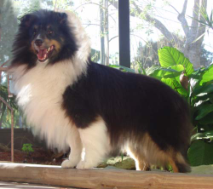

In [72]:
display(Image.open(err_img))

In [75]:
Image.open(err_img).mode

'RGBA'

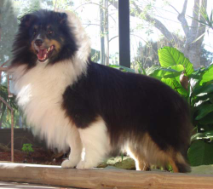

In [76]:
display(Image.open(err_img).convert("RGB"))

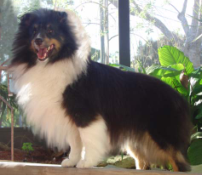

In [74]:
display(Image.open(err_img).crop(box = err_bbox))

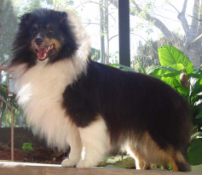

In [77]:
display(Image.open(err_img).crop(box = err_bbox).convert("RGB"))

**Third time's a charm**

In [84]:
prepare_image_folder(file_list_arr = train_file_list["file_list"],
                     root_dir = "data",
                     dataset_type = "train",
                     log_multiples = True)

  0%|          | 50/12000 [00:00<01:17, 155.12it/s]

Found 3 Chihuahuas in n02085620_1152.jpg
Found 2 Chihuahuas in n02085620_473.jpg


  1%|          | 101/12000 [00:00<01:12, 164.31it/s]

Found 2 Chihuahuas in n02085620_575.jpg
Found 2 Chihuahuas in n02085620_5661.jpg


  1%|          | 135/12000 [00:00<01:15, 157.40it/s]

Found 2 Japanese_spaniels in n02085782_2635.jpg
Found 2 Japanese_spaniels in n02085782_935.jpg
Found 2 Japanese_spaniels in n02085782_2207.jpg


  1%|▏         | 177/12000 [00:01<01:07, 174.86it/s]

Found 2 Japanese_spaniels in n02085782_3516.jpg
Found 3 Japanese_spaniels in n02085782_2010.jpg
Found 2 Japanese_spaniels in n02085782_2886.jpg
Found 2 Japanese_spaniels in n02085782_3071.jpg


  2%|▏         | 212/12000 [00:01<01:13, 161.39it/s]

Found 3 Japanese_spaniels in n02085782_2914.jpg
Found 2 Maltese_dogs in n02085936_3863.jpg


  2%|▏         | 284/12000 [00:01<01:10, 166.66it/s]

Found 2 Maltese_dogs in n02085936_3292.jpg
Found 2 Maltese_dogs in n02085936_2889.jpg


  3%|▎         | 321/12000 [00:01<01:07, 172.76it/s]

Found 2 Maltese_dogs in n02085936_8745.jpg
Found 2 Maltese_dogs in n02085936_16565.jpg
Found 2 Maltese_dogs in n02085936_9632.jpg
Found 2 Maltese_dogs in n02085936_10610.jpg


  3%|▎         | 375/12000 [00:02<01:11, 163.39it/s]

Found 2 Pekineses in n02086079_8127.jpg
Found 2 Pekineses in n02086079_20762.jpg


  4%|▎         | 430/12000 [00:02<01:09, 165.41it/s]

Found 2 Shihs in n02086240_789.jpg
Found 2 Shihs in n02086240_1725.jpg
Found 2 Shihs in n02086240_6587.jpg
Found 2 Shihs in n02086240_11622.jpg


  4%|▍         | 500/12000 [00:02<01:07, 169.79it/s]

Found 2 Shihs in n02086240_10785.jpg
Found 4 Shihs in n02086240_7205.jpg


  4%|▍         | 518/12000 [00:03<01:08, 168.80it/s]

Found 2 Blenheim_spaniels in n02086646_2772.jpg


  5%|▌         | 601/12000 [00:03<01:17, 147.10it/s]

Found 2 Blenheim_spaniels in n02086646_1342.jpg
Found 2 Blenheim_spaniels in n02086646_3466.jpg
Found 2 Blenheim_spaniels in n02086646_3968.jpg
Found 2 Blenheim_spaniels in n02086646_814.jpg
Found 2 Blenheim_spaniels in n02086646_2871.jpg
Found 2 Blenheim_spaniels in n02086646_127.jpg


  5%|▌         | 650/12000 [00:04<01:14, 152.41it/s]

Found 2 papillons in n02086910_4330.jpg
Found 2 papillons in n02086910_2909.jpg
Found 2 papillons in n02086910_5408.jpg
Found 2 papillons in n02086910_6882.jpg
Found 2 papillons in n02086910_2550.jpg


  6%|▌         | 719/12000 [00:04<01:08, 164.64it/s]

Found 2 papillons in n02086910_7301.jpg
Found 2 papillons in n02086910_5707.jpg
Found 2 toy_terriers in n02087046_2316.jpg


  7%|▋         | 829/12000 [00:05<01:08, 162.20it/s]

Found 2 Rhodesian_ridgebacks in n02087394_7544.jpg
Found 2 Rhodesian_ridgebacks in n02087394_3311.jpg


  7%|▋         | 865/12000 [00:05<01:06, 166.63it/s]

Found 2 Rhodesian_ridgebacks in n02087394_9189.jpg


  8%|▊         | 919/12000 [00:05<01:09, 159.20it/s]

Found 2 Rhodesian_ridgebacks in n02087394_3515.jpg
Found 3 Afghan_hounds in n02088094_4464.jpg
Found 2 Afghan_hounds in n02088094_4517.jpg
Found 3 Afghan_hounds in n02088094_13742.jpg
Found 2 Afghan_hounds in n02088094_2559.jpg
Found 2 Afghan_hounds in n02088094_4678.jpg
Found 2 Afghan_hounds in n02088094_4759.jpg
Found 2 Afghan_hounds in n02088094_11006.jpg
Found 2 Afghan_hounds in n02088094_7131.jpg
Found 2 Afghan_hounds in n02088094_4511.jpg


  8%|▊         | 969/12000 [00:05<01:11, 154.95it/s]

Found 2 Afghan_hounds in n02088094_266.jpg
Found 3 Afghan_hounds in n02088094_3641.jpg
Found 3 Afghan_hounds in n02088094_688.jpg
Found 3 Afghan_hounds in n02088094_4497.jpg
Found 3 Afghan_hounds in n02088094_522.jpg
Found 2 Afghan_hounds in n02088094_11584.jpg
Found 2 Afghan_hounds in n02088094_11432.jpg


  8%|▊         | 1002/12000 [00:06<01:10, 155.67it/s]

Found 2 Afghan_hounds in n02088094_5812.jpg
Found 2 Afghan_hounds in n02088094_4072.jpg
Found 3 Afghan_hounds in n02088094_227.jpg
Found 2 Afghan_hounds in n02088094_3613.jpg


  9%|▊         | 1035/12000 [00:06<01:09, 156.81it/s]

Found 2 bassets in n02088238_11635.jpg
Found 2 bassets in n02088238_13847.jpg
Found 3 bassets in n02088238_9778.jpg
Found 2 bassets in n02088238_5441.jpg
Found 2 bassets in n02088238_9986.jpg


  9%|▉         | 1069/12000 [00:06<01:08, 160.00it/s]

Found 2 bassets in n02088238_9789.jpg
Found 2 bassets in n02088238_10870.jpg


  9%|▉         | 1118/12000 [00:06<01:09, 156.12it/s]

Found 2 bassets in n02088238_10028.jpg
Found 2 beagles in n02088364_16210.jpg
Found 2 beagles in n02088364_12710.jpg


 10%|▉         | 1150/12000 [00:07<01:09, 155.31it/s]

Found 2 beagles in n02088364_12794.jpg
Found 2 beagles in n02088364_16493.jpg


 10%|▉         | 1183/12000 [00:07<01:13, 146.65it/s]

Found 2 beagles in n02088364_10362.jpg
Found 2 beagles in n02088364_3752.jpg
Found 2 beagles in n02088364_11130.jpg
Found 2 beagles in n02088364_10731.jpg


 11%|█         | 1269/12000 [00:07<01:07, 158.39it/s]

Found 4 bloodhounds in n02088466_9167.jpg
Found 2 bloodhounds in n02088466_7046.jpg


 11%|█▏        | 1371/12000 [00:08<01:07, 157.79it/s]

Found 2 blueticks in n02088632_205.jpg


 13%|█▎        | 1542/12000 [00:09<01:09, 149.84it/s]

Found 2 Walker_hounds in n02089867_126.jpg
Found 2 Walker_hounds in n02089867_3449.jpg
Found 2 Walker_hounds in n02089867_2227.jpg
Found 2 Walker_hounds in n02089867_880.jpg


 13%|█▎        | 1562/12000 [00:09<01:04, 160.89it/s]

Found 2 Walker_hounds in n02089867_724.jpg
Found 2 Walker_hounds in n02089867_1918.jpg


 13%|█▎        | 1615/12000 [00:10<01:09, 149.74it/s]

Found 2 Walker_hounds in n02089867_55.jpg
Found 2 Walker_hounds in n02089867_2221.jpg
Found 2 English_foxhounds in n02089973_3651.jpg
Found 4 English_foxhounds in n02089973_2791.jpg
Found 2 English_foxhounds in n02089973_2756.jpg
Found 2 English_foxhounds in n02089973_2045.jpg


 14%|█▍        | 1651/12000 [00:10<01:03, 163.22it/s]

Found 3 English_foxhounds in n02089973_4185.jpg
Found 2 English_foxhounds in n02089973_1907.jpg
Found 3 English_foxhounds in n02089973_97.jpg
Found 4 English_foxhounds in n02089973_2415.jpg
Found 2 English_foxhounds in n02089973_2716.jpg
Found 4 English_foxhounds in n02089973_1799.jpg


 14%|█▍        | 1693/12000 [00:10<00:56, 182.90it/s]

Found 2 English_foxhounds in n02089973_2500.jpg
Found 2 English_foxhounds in n02089973_32.jpg
Found 3 English_foxhounds in n02089973_2781.jpg
Found 3 English_foxhounds in n02089973_4055.jpg
Found 2 English_foxhounds in n02089973_2249.jpg
Found 4 English_foxhounds in n02089973_1132.jpg
Found 3 English_foxhounds in n02089973_3147.jpg


 15%|█▍        | 1748/12000 [00:10<01:01, 167.48it/s]

Found 2 redbones in n02090379_5525.jpg
Found 2 redbones in n02090379_4875.jpg


 15%|█▌        | 1801/12000 [00:11<01:00, 167.68it/s]

Found 2 redbones in n02090379_4673.jpg
Found 2 borzois in n02090622_4527.jpg


 15%|█▌        | 1852/12000 [00:11<01:03, 159.40it/s]

Found 2 borzois in n02090622_8380.jpg
Found 2 borzois in n02090622_7705.jpg
Found 2 borzois in n02090622_7663.jpg
Found 3 borzois in n02090622_7858.jpg
Found 3 borzois in n02090622_7962.jpg


 16%|█▌        | 1904/12000 [00:11<01:03, 159.80it/s]

Found 2 borzois in n02090622_7351.jpg
Found 3 borzois in n02090622_8045.jpg
Found 2 borzois in n02090622_9883.jpg
Found 3 Irish_wolfhounds in n02090721_3149.jpg
Found 3 Irish_wolfhounds in n02090721_4276.jpg


 16%|█▌        | 1937/12000 [00:12<01:05, 153.40it/s]

Found 2 Irish_wolfhounds in n02090721_5722.jpg
Found 3 Irish_wolfhounds in n02090721_4353.jpg
Found 2 Irish_wolfhounds in n02090721_4290.jpg
Found 2 Irish_wolfhounds in n02090721_1222.jpg


 16%|█▋        | 1970/12000 [00:12<01:03, 157.99it/s]

Found 2 Irish_wolfhounds in n02090721_2442.jpg
Found 2 Irish_wolfhounds in n02090721_954.jpg
Found 2 Irish_wolfhounds in n02090721_940.jpg
Found 3 Irish_wolfhounds in n02090721_3302.jpg
Found 2 Irish_wolfhounds in n02090721_7155.jpg


 17%|█▋        | 2003/12000 [00:12<01:02, 159.06it/s]

Found 2 Irish_wolfhounds in n02090721_4200.jpg
Found 3 Irish_wolfhounds in n02090721_537.jpg
Found 2 Irish_wolfhounds in n02090721_175.jpg
Found 2 Irish_wolfhounds in n02090721_209.jpg
Found 2 Irish_wolfhounds in n02090721_6715.jpg
Found 2 Italian_greyhounds in n02091032_722.jpg
Found 2 Italian_greyhounds in n02091032_990.jpg


 17%|█▋        | 2053/12000 [00:12<01:01, 160.57it/s]

Found 2 Italian_greyhounds in n02091032_18.jpg
Found 2 Italian_greyhounds in n02091032_4004.jpg
Found 2 Italian_greyhounds in n02091032_1680.jpg
Found 2 Italian_greyhounds in n02091032_745.jpg
Found 2 Italian_greyhounds in n02091032_11998.jpg


 17%|█▋        | 2088/12000 [00:12<01:00, 162.67it/s]

Found 2 Italian_greyhounds in n02091032_11660.jpg
Found 2 Italian_greyhounds in n02091032_12113.jpg


 18%|█▊        | 2123/12000 [00:13<01:00, 163.78it/s]

Found 2 whippets in n02091134_12358.jpg
Found 3 whippets in n02091134_7232.jpg
Found 2 whippets in n02091134_917.jpg
Found 2 whippets in n02091134_17054.jpg
Found 2 whippets in n02091134_16541.jpg
Found 2 whippets in n02091134_7375.jpg


 18%|█▊        | 2157/12000 [00:13<01:00, 163.96it/s]

Found 2 whippets in n02091134_19204.jpg
Found 2 whippets in n02091134_19308.jpg
Found 2 whippets in n02091134_12732.jpg
Found 2 whippets in n02091134_2349.jpg
Found 2 whippets in n02091134_18902.jpg
Found 2 whippets in n02091134_18824.jpg


 18%|█▊        | 2190/12000 [00:13<01:02, 156.17it/s]

Found 2 whippets in n02091134_10690.jpg
Found 3 whippets in n02091134_12341.jpg
Found 2 whippets in n02091134_17108.jpg
Found 2 whippets in n02091134_10918.jpg
Found 2 whippets in n02091134_18140.jpg
Found 2 whippets in n02091134_12029.jpg


 19%|█▊        | 2242/12000 [00:13<00:59, 163.57it/s]

Found 3 Ibizan_hounds in n02091244_5639.jpg
Found 2 Ibizan_hounds in n02091244_4367.jpg
Found 2 Ibizan_hounds in n02091244_2941.jpg


 19%|█▉        | 2310/12000 [00:14<01:00, 161.25it/s]

Found 2 Ibizan_hounds in n02091244_3005.jpg
Found 2 Ibizan_hounds in n02091244_4885.jpg
Found 2 Norwegian_elkhounds in n02091467_4558.jpg


 20%|█▉        | 2361/12000 [00:14<00:59, 163.35it/s]

Found 2 Norwegian_elkhounds in n02091467_4427.jpg


 20%|█▉        | 2395/12000 [00:14<01:00, 158.72it/s]

Found 2 Norwegian_elkhounds in n02091467_3879.jpg
Found 2 Norwegian_elkhounds in n02091467_627.jpg


 20%|██        | 2448/12000 [00:15<01:00, 157.29it/s]

Found 2 otterhounds in n02091635_1192.jpg
Found 2 otterhounds in n02091635_965.jpg
Found 2 otterhounds in n02091635_1043.jpg
Found 2 otterhounds in n02091635_2725.jpg


 21%|██        | 2484/12000 [00:15<00:59, 161.11it/s]

Found 2 otterhounds in n02091635_3048.jpg
Found 2 otterhounds in n02091635_4045.jpg
Found 2 otterhounds in n02091635_1840.jpg


 21%|██        | 2520/12000 [00:15<00:57, 163.82it/s]

Found 2 otterhounds in n02091635_1417.jpg
Found 2 Salukis in n02091831_3054.jpg
Found 2 Salukis in n02091831_7030.jpg
Found 2 Salukis in n02091831_3430.jpg


 21%|██▏       | 2554/12000 [00:15<00:57, 164.25it/s]

Found 2 Salukis in n02091831_9731.jpg
Found 3 Salukis in n02091831_3616.jpg
Found 2 Salukis in n02091831_735.jpg
Found 2 Salukis in n02091831_1696.jpg
Found 2 Salukis in n02091831_8028.jpg


 22%|██▏       | 2588/12000 [00:16<01:00, 156.31it/s]

Found 2 Salukis in n02091831_1594.jpg
Found 2 Salukis in n02091831_7051.jpg
Found 2 Salukis in n02091831_3400.jpg
Found 2 Salukis in n02091831_3242.jpg


 22%|██▏       | 2641/12000 [00:16<00:57, 162.38it/s]

Found 2 Scottish_deerhounds in n02092002_15064.jpg
Found 2 Scottish_deerhounds in n02092002_4596.jpg
Found 2 Scottish_deerhounds in n02092002_11105.jpg


 22%|██▏       | 2681/12000 [00:16<00:53, 175.76it/s]

Found 3 Scottish_deerhounds in n02092002_4337.jpg
Found 2 Scottish_deerhounds in n02092002_5246.jpg
Found 2 Scottish_deerhounds in n02092002_7160.jpg


 23%|██▎       | 2719/12000 [00:16<00:55, 168.50it/s]

Found 2 Scottish_deerhounds in n02092002_49.jpg
Found 2 Weimaraners in n02092339_366.jpg
Found 2 Weimaraners in n02092339_6752.jpg


 23%|██▎       | 2758/12000 [00:17<00:51, 178.54it/s]

Found 2 Weimaraners in n02092339_6401.jpg
Found 2 Weimaraners in n02092339_2653.jpg


 23%|██▎       | 2818/12000 [00:17<00:48, 189.99it/s]

Found 2 Weimaraners in n02092339_4378.jpg
Found 2 Staffordshire_bullterriers in n02093256_11732.jpg


 24%|██▍       | 2858/12000 [00:17<00:47, 192.15it/s]

Found 2 Staffordshire_bullterriers in n02093256_264.jpg
Found 2 Staffordshire_bullterriers in n02093256_3877.jpg


 24%|██▍       | 2920/12000 [00:17<00:47, 189.23it/s]

Found 2 Staffordshire_bullterriers in n02093256_4997.jpg
Found 3 Staffordshire_bullterriers in n02093256_6158.jpg


 25%|██▍       | 2978/12000 [00:18<00:49, 181.82it/s]

Found 2 American_Staffordshire_terriers in n02093428_6949.jpg
Found 2 American_Staffordshire_terriers in n02093428_592.jpg
Found 2 American_Staffordshire_terriers in n02093428_5926.jpg
Found 2 American_Staffordshire_terriers in n02093428_3353.jpg


 25%|██▌       | 3038/12000 [00:18<00:48, 185.09it/s]

Found 3 Bedlington_terriers in n02093647_502.jpg
Found 2 Bedlington_terriers in n02093647_126.jpg
Found 2 Bedlington_terriers in n02093647_1870.jpg
Found 3 Bedlington_terriers in n02093647_3291.jpg


 26%|██▌       | 3126/12000 [00:19<00:46, 191.90it/s]

Found 2 Bedlington_terriers in n02093647_55.jpg


 27%|██▋       | 3294/12000 [00:19<00:41, 211.64it/s]

Found 2 Kerry_blue_terriers in n02093859_14.jpg
Found 2 Kerry_blue_terriers in n02093859_608.jpg
Found 2 Kerry_blue_terriers in n02093859_3283.jpg
Found 2 Kerry_blue_terriers in n02093859_640.jpg


 28%|██▊       | 3337/12000 [00:20<00:44, 194.11it/s]

Found 2 Irish_terriers in n02093991_4441.jpg
Found 2 Irish_terriers in n02093991_5001.jpg
Found 2 Irish_terriers in n02093991_4306.jpg
Found 2 Irish_terriers in n02093991_756.jpg


 28%|██▊       | 3377/12000 [00:20<00:48, 178.98it/s]

Found 2 Irish_terriers in n02093991_3174.jpg
Found 2 Irish_terriers in n02093991_4151.jpg
Found 2 Irish_terriers in n02093991_3314.jpg
Found 3 Irish_terriers in n02093991_4287.jpg


 29%|██▊       | 3438/12000 [00:20<00:45, 189.62it/s]

Found 2 Irish_terriers in n02093991_946.jpg


 29%|██▉       | 3500/12000 [00:20<00:42, 199.90it/s]

Found 2 Norfolk_terriers in n02094114_1696.jpg
Found 2 Norfolk_terriers in n02094114_2739.jpg
Found 2 Norfolk_terriers in n02094114_2245.jpg
Found 2 Norfolk_terriers in n02094114_3925.jpg
Found 2 Norwich_terriers in n02094258_247.jpg
Found 2 Norwich_terriers in n02094258_726.jpg
Found 2 Norwich_terriers in n02094258_860.jpg


 30%|██▉       | 3563/12000 [00:21<00:42, 197.99it/s]

Found 2 Norwich_terriers in n02094258_871.jpg
Found 3 Norwich_terriers in n02094258_1192.jpg
Found 2 Norwich_terriers in n02094258_1091.jpg
Found 2 Norwich_terriers in n02094258_1408.jpg
Found 2 Norwich_terriers in n02094258_905.jpg
Found 2 Norwich_terriers in n02094258_2583.jpg
Found 2 Norwich_terriers in n02094258_2359.jpg
Found 2 Norwich_terriers in n02094258_792.jpg


 30%|███       | 3603/12000 [00:21<00:48, 172.37it/s]

Found 2 Norwich_terriers in n02094258_1281.jpg
Found 2 Norwich_terriers in n02094258_977.jpg
Found 2 Norwich_terriers in n02094258_1614.jpg
Found 2 Yorkshire_terriers in n02094433_2987.jpg


 30%|███       | 3643/12000 [00:21<00:47, 175.72it/s]

Found 2 Yorkshire_terriers in n02094433_2266.jpg
Found 2 Yorkshire_terriers in n02094433_3642.jpg


 31%|███       | 3707/12000 [00:22<00:43, 191.52it/s]

Found 2 Yorkshire_terriers in n02094433_3999.jpg
Found 2 wires in n02095314_2198.jpg


 31%|███▏      | 3753/12000 [00:22<00:42, 193.32it/s]

Found 2 wires in n02095314_398.jpg
Found 2 wires in n02095314_2256.jpg
Found 2 wires in n02095314_2196.jpg
Found 2 wires in n02095314_591.jpg


 32%|███▏      | 3807/12000 [00:22<00:36, 222.21it/s]

Found 2 wires in n02095314_928.jpg
Found 2 Lakeland_terriers in n02095570_4436.jpg


 32%|███▏      | 3852/12000 [00:22<00:39, 206.34it/s]

Found 2 Lakeland_terriers in n02095570_3745.jpg
Found 2 Lakeland_terriers in n02095570_373.jpg
Found 2 Lakeland_terriers in n02095570_2569.jpg


 32%|███▏      | 3896/12000 [00:22<00:39, 203.97it/s]

Found 2 Lakeland_terriers in n02095570_3102.jpg
Found 2 Lakeland_terriers in n02095570_3777.jpg


 33%|███▎      | 3945/12000 [00:23<00:41, 192.41it/s]

Found 2 Sealyham_terriers in n02095889_293.jpg
Found 2 Sealyham_terriers in n02095889_2977.jpg
Found 2 Sealyham_terriers in n02095889_4762.jpg
Found 2 Sealyham_terriers in n02095889_1847.jpg
Found 2 Sealyham_terriers in n02095889_4306.jpg
Found 2 Sealyham_terriers in n02095889_1323.jpg
Found 2 Sealyham_terriers in n02095889_6583.jpg
Found 2 Sealyham_terriers in n02095889_3354.jpg
Found 2 Sealyham_terriers in n02095889_1476.jpg


 33%|███▎      | 3995/12000 [00:23<00:36, 217.86it/s]

Found 2 Sealyham_terriers in n02095889_4198.jpg
Found 2 Sealyham_terriers in n02095889_6458.jpg
Found 2 Sealyham_terriers in n02095889_4290.jpg
Found 3 Sealyham_terriers in n02095889_3904.jpg
Found 2 Sealyham_terriers in n02095889_1724.jpg
Found 2 Sealyham_terriers in n02095889_5528.jpg
Found 2 Sealyham_terriers in n02095889_4077.jpg
Found 3 Sealyham_terriers in n02095889_5203.jpg
Found 2 Airedales in n02096051_3660.jpg


 34%|███▍      | 4082/12000 [00:23<00:43, 181.14it/s]

Found 2 Airedales in n02096051_8790.jpg
Found 2 Airedales in n02096051_3796.jpg


 35%|███▍      | 4178/12000 [00:24<00:43, 179.12it/s]

Found 2 cairns in n02096177_4825.jpg
Found 2 cairns in n02096177_6298.jpg


 35%|███▍      | 4197/12000 [00:24<00:44, 174.27it/s]

Found 2 cairns in n02096177_3729.jpg
Found 2 cairns in n02096177_1889.jpg


 36%|███▌      | 4297/12000 [00:25<00:39, 193.80it/s]

Found 2 Australian_terriers in n02096294_8067.jpg
Found 2 Australian_terriers in n02096294_4925.jpg
Found 2 Dandie_Dinmonts in n02096437_956.jpg


 36%|███▌      | 4336/12000 [00:25<00:41, 185.91it/s]

Found 2 Dandie_Dinmonts in n02096437_3427.jpg
Found 2 Dandie_Dinmonts in n02096437_1936.jpg
Found 2 Dandie_Dinmonts in n02096437_599.jpg
Found 2 Dandie_Dinmonts in n02096437_2224.jpg


 37%|███▋      | 4394/12000 [00:25<00:41, 181.86it/s]

Found 2 Dandie_Dinmonts in n02096437_1511.jpg
Found 2 Dandie_Dinmonts in n02096437_1015.jpg
Found 2 Dandie_Dinmonts in n02096437_1952.jpg
Found 2 Dandie_Dinmonts in n02096437_1678.jpg


 37%|███▋      | 4433/12000 [00:25<00:41, 180.86it/s]

Found 2 Dandie_Dinmonts in n02096437_4432.jpg
Found 2 Boston_bulls in n02096585_5260.jpg
Found 2 Boston_bulls in n02096585_2374.jpg
Found 2 Boston_bulls in n02096585_342.jpg
Found 2 Boston_bulls in n02096585_9909.jpg
Found 2 Boston_bulls in n02096585_12374.jpg


 38%|███▊      | 4529/12000 [00:26<00:39, 188.92it/s]

Found 2 miniature_schnauzers in n02097047_2178.jpg
Found 2 miniature_schnauzers in n02097047_1601.jpg


 38%|███▊      | 4567/12000 [00:26<00:46, 161.56it/s]

Found 2 miniature_schnauzers in n02097047_1527.jpg
Found 2 miniature_schnauzers in n02097047_37.jpg
Found 2 miniature_schnauzers in n02097047_635.jpg


 38%|███▊      | 4618/12000 [00:26<00:48, 153.78it/s]

Found 2 miniature_schnauzers in n02097047_2663.jpg


 39%|███▉      | 4666/12000 [00:27<00:47, 154.70it/s]

Found 3 giant_schnauzers in n02097130_1395.jpg
Found 2 giant_schnauzers in n02097130_4663.jpg


 39%|███▉      | 4715/12000 [00:27<00:47, 152.24it/s]

Found 2 giant_schnauzers in n02097130_5907.jpg
Found 2 giant_schnauzers in n02097130_1289.jpg
Found 2 standard_schnauzers in n02097209_2505.jpg
Found 3 standard_schnauzers in n02097209_1963.jpg


 40%|███▉      | 4747/12000 [00:27<00:51, 141.57it/s]

Found 2 standard_schnauzers in n02097209_3652.jpg
Found 2 standard_schnauzers in n02097209_1839.jpg
Found 2 standard_schnauzers in n02097209_2274.jpg
Found 2 standard_schnauzers in n02097209_3281.jpg
Found 3 standard_schnauzers in n02097209_1353.jpg


 40%|███▉      | 4783/12000 [00:28<00:46, 154.71it/s]

Found 2 standard_schnauzers in n02097209_3447.jpg
Found 2 standard_schnauzers in n02097209_169.jpg
Found 3 standard_schnauzers in n02097209_991.jpg
Found 3 standard_schnauzers in n02097209_1240.jpg
Found 4 standard_schnauzers in n02097209_1760.jpg
Found 2 standard_schnauzers in n02097209_3729.jpg
Found 2 standard_schnauzers in n02097209_2468.jpg
Found 2 standard_schnauzers in n02097209_469.jpg


 40%|████      | 4816/12000 [00:28<00:45, 156.76it/s]

Found 2 standard_schnauzers in n02097209_2087.jpg
Found 2 standard_schnauzers in n02097209_367.jpg
Found 2 Scotch_terriers in n02097298_6863.jpg


 40%|████      | 4848/12000 [00:28<00:45, 157.22it/s]

Found 2 Scotch_terriers in n02097298_1152.jpg
Found 2 Scotch_terriers in n02097298_7639.jpg
Found 2 Scotch_terriers in n02097298_9756.jpg
Found 2 Scotch_terriers in n02097298_6740.jpg


 41%|████      | 4897/12000 [00:28<00:44, 157.97it/s]

Found 2 Scotch_terriers in n02097298_7517.jpg
Found 2 Scotch_terriers in n02097298_2492.jpg
Found 2 Scotch_terriers in n02097298_10965.jpg
Found 2 Scotch_terriers in n02097298_344.jpg


 41%|████▏     | 4978/12000 [00:29<00:47, 149.23it/s]

Found 2 Tibetan_terriers in n02097474_2318.jpg
Found 2 Tibetan_terriers in n02097474_8811.jpg
Found 2 Tibetan_terriers in n02097474_4907.jpg


 42%|████▏     | 5010/12000 [00:29<00:46, 148.87it/s]

Found 2 Tibetan_terriers in n02097474_6280.jpg


 43%|████▎     | 5122/12000 [00:30<00:45, 152.58it/s]

Found 2 silky_terriers in n02097658_1106.jpg
Found 2 softs in n02098105_1190.jpg


 43%|████▎     | 5156/12000 [00:30<00:43, 158.97it/s]

Found 2 softs in n02098105_2456.jpg
Found 2 softs in n02098105_4120.jpg


 44%|████▎     | 5226/12000 [00:30<00:43, 155.98it/s]

Found 2 West_Highland_white_terriers in n02098286_3701.jpg
Found 2 West_Highland_white_terriers in n02098286_6254.jpg
Found 2 West_Highland_white_terriers in n02098286_1511.jpg
Found 2 West_Highland_white_terriers in n02098286_2413.jpg
Found 2 West_Highland_white_terriers in n02098286_3329.jpg


 44%|████▍     | 5262/12000 [00:31<00:40, 165.97it/s]

Found 2 West_Highland_white_terriers in n02098286_3263.jpg
Found 2 West_Highland_white_terriers in n02098286_1255.jpg
Found 2 West_Highland_white_terriers in n02098286_1632.jpg
Found 2 West_Highland_white_terriers in n02098286_680.jpg
Found 2 West_Highland_white_terriers in n02098286_5700.jpg


 44%|████▍     | 5298/12000 [00:31<00:39, 169.67it/s]

Found 2 West_Highland_white_terriers in n02098286_5672.jpg
Found 2 West_Highland_white_terriers in n02098286_2481.jpg


 45%|████▍     | 5367/12000 [00:31<00:40, 162.98it/s]

Found 2 Lhasas in n02098413_13083.jpg
Found 2 Lhasas in n02098413_2582.jpg


 45%|████▌     | 5418/12000 [00:32<00:43, 150.39it/s]

Found 2 Lhasas in n02098413_8379.jpg
Found 2 flats in n02099267_3768.jpg


 46%|████▌     | 5471/12000 [00:32<00:39, 164.71it/s]

Found 2 flats in n02099267_5669.jpg
Found 2 flats in n02099267_731.jpg


 46%|████▌     | 5522/12000 [00:32<00:42, 151.17it/s]

Found 2 flats in n02099267_720.jpg
Found 2 flats in n02099267_2447.jpg
Found 3 flats in n02099267_488.jpg
Found 2 curlys in n02099429_915.jpg


 46%|████▋     | 5560/12000 [00:32<00:38, 167.26it/s]

Found 2 curlys in n02099429_3516.jpg
Found 2 curlys in n02099429_2392.jpg
Found 2 curlys in n02099429_1950.jpg


 47%|████▋     | 5597/12000 [00:33<00:36, 173.97it/s]

Found 2 curlys in n02099429_2699.jpg
Found 2 curlys in n02099429_2281.jpg
Found 2 curlys in n02099429_2925.jpg


 47%|████▋     | 5632/12000 [00:33<00:41, 155.26it/s]

Found 3 golden_retrievers in n02099601_4241.jpg


 48%|████▊     | 5715/12000 [00:33<00:40, 154.39it/s]

Found 2 golden_retrievers in n02099601_7706.jpg
Found 2 golden_retrievers in n02099601_6980.jpg
Found 2 Labrador_retrievers in n02099712_7481.jpg


 48%|████▊     | 5766/12000 [00:34<00:39, 159.46it/s]

Found 2 Labrador_retrievers in n02099712_5000.jpg
Found 2 Labrador_retrievers in n02099712_7968.jpg
Found 2 Labrador_retrievers in n02099712_3776.jpg
Found 3 Labrador_retrievers in n02099712_8242.jpg
Found 2 Labrador_retrievers in n02099712_7049.jpg


 48%|████▊     | 5803/12000 [00:34<00:36, 168.69it/s]

Found 2 Labrador_retrievers in n02099712_3503.jpg
Found 2 Labrador_retrievers in n02099712_5657.jpg
Found 2 Labrador_retrievers in n02099712_2224.jpg
Found 2 Chesapeake_Bay_retrievers in n02099849_3203.jpg
Found 2 Chesapeake_Bay_retrievers in n02099849_3403.jpg


 49%|████▊     | 5838/12000 [00:34<00:37, 164.20it/s]

Found 2 Chesapeake_Bay_retrievers in n02099849_4667.jpg
Found 2 Chesapeake_Bay_retrievers in n02099849_1997.jpg
Found 2 Chesapeake_Bay_retrievers in n02099849_3565.jpg
Found 2 Chesapeake_Bay_retrievers in n02099849_4215.jpg
Found 2 Chesapeake_Bay_retrievers in n02099849_2068.jpg
Found 2 Chesapeake_Bay_retrievers in n02099849_1823.jpg


 49%|████▉     | 5890/12000 [00:35<00:37, 163.30it/s]

Found 2 Chesapeake_Bay_retrievers in n02099849_4348.jpg
Found 2 Chesapeake_Bay_retrievers in n02099849_2300.jpg
Found 2 Chesapeake_Bay_retrievers in n02099849_1326.jpg
Found 2 Chesapeake_Bay_retrievers in n02099849_4619.jpg


 50%|█████     | 6031/12000 [00:35<00:35, 167.50it/s]

Found 2 vizslas in n02100583_1600.jpg
Found 2 vizslas in n02100583_12047.jpg


 51%|█████     | 6084/12000 [00:36<00:34, 172.51it/s]

Found 2 vizslas in n02100583_10834.jpg
Found 2 vizslas in n02100583_9956.jpg


 51%|█████     | 6139/12000 [00:36<00:35, 167.36it/s]

Found 2 English_setters in n02100735_1467.jpg
Found 2 English_setters in n02100735_721.jpg
Found 2 English_setters in n02100735_3566.jpg


 51%|█████▏    | 6173/12000 [00:36<00:40, 142.41it/s]

Found 2 English_setters in n02100735_5234.jpg


 52%|█████▏    | 6223/12000 [00:37<00:40, 144.05it/s]

Found 2 Irish_setters in n02100877_8595.jpg
Found 2 Irish_setters in n02100877_4895.jpg


 52%|█████▏    | 6257/12000 [00:37<00:37, 152.44it/s]

Found 2 Irish_setters in n02100877_1061.jpg


 53%|█████▎    | 6306/12000 [00:37<00:37, 153.50it/s]

Found 2 Irish_setters in n02100877_237.jpg
Found 2 Gordon_setters in n02101006_4988.jpg


 53%|█████▎    | 6358/12000 [00:38<00:37, 149.25it/s]

Found 2 Gordon_setters in n02101006_2629.jpg
Found 2 Gordon_setters in n02101006_2516.jpg


 53%|█████▎    | 6390/12000 [00:38<00:39, 143.22it/s]

Found 2 Gordon_setters in n02101006_2445.jpg
Found 2 Gordon_setters in n02101006_3914.jpg
Found 3 Gordon_setters in n02101006_267.jpg
Found 2 Gordon_setters in n02101006_3882.jpg
Found 2 Gordon_setters in n02101006_12.jpg


 54%|█████▎    | 6427/12000 [00:38<00:35, 158.60it/s]

Found 2 Brittany_spaniels in n02101388_2645.jpg
Found 2 Brittany_spaniels in n02101388_9320.jpg
Found 2 Brittany_spaniels in n02101388_10470.jpg


 55%|█████▍    | 6553/12000 [00:39<00:32, 165.83it/s]

Found 2 clumbers in n02101556_5167.jpg
Found 2 clumbers in n02101556_5753.jpg
Found 3 clumbers in n02101556_2604.jpg
Found 3 clumbers in n02101556_4112.jpg


 55%|█████▍    | 6587/12000 [00:39<00:34, 156.80it/s]

Found 3 clumbers in n02101556_4281.jpg
Found 2 clumbers in n02101556_5249.jpg
Found 2 clumbers in n02101556_7317.jpg
Found 2 clumbers in n02101556_8039.jpg


 55%|█████▌    | 6638/12000 [00:39<00:34, 157.60it/s]

Found 2 English_springers in n02102040_1519.jpg
Found 2 English_springers in n02102040_1276.jpg
Found 2 English_springers in n02102040_3260.jpg
Found 2 English_springers in n02102040_6109.jpg


 56%|█████▌    | 6672/12000 [00:40<00:33, 160.15it/s]

Found 2 English_springers in n02102040_3610.jpg
Found 2 English_springers in n02102040_1259.jpg


 56%|█████▌    | 6706/12000 [00:40<00:32, 162.41it/s]

Found 2 English_springers in n02102040_988.jpg
Found 2 English_springers in n02102040_1244.jpg


 56%|█████▋    | 6756/12000 [00:40<00:33, 158.14it/s]

Found 2 Welsh_springer_spaniels in n02102177_3639.jpg
Found 2 Welsh_springer_spaniels in n02102177_66.jpg
Found 2 Welsh_springer_spaniels in n02102177_715.jpg


 57%|█████▋    | 6827/12000 [00:40<00:33, 156.63it/s]

Found 2 cocker_spaniels in n02102318_20.jpg


 57%|█████▋    | 6891/12000 [00:41<00:33, 151.72it/s]

Found 2 cocker_spaniels in n02102318_10703.jpg


 58%|█████▊    | 6995/12000 [00:42<00:38, 128.60it/s]

Found 2 Sussex_spaniels in n02102480_5158.jpg


 59%|█████▊    | 7025/12000 [00:42<00:37, 131.35it/s]

Found 2 Irish_water_spaniels in n02102973_5052.jpg


 59%|█████▉    | 7054/12000 [00:42<00:57, 86.12it/s] 

Found 3 Irish_water_spaniels in n02102973_273.jpg


 59%|█████▉    | 7088/12000 [00:43<00:43, 113.25it/s]

Found 2 Irish_water_spaniels in n02102973_3303.jpg
Found 2 Irish_water_spaniels in n02102973_487.jpg


 59%|█████▉    | 7129/12000 [00:43<00:43, 111.75it/s]

Found 2 kuvaszs in n02104029_951.jpg


 60%|█████▉    | 7163/12000 [00:43<00:35, 134.45it/s]

Found 2 kuvaszs in n02104029_3769.jpg
Found 2 kuvaszs in n02104029_4696.jpg
Found 2 kuvaszs in n02104029_4571.jpg


 60%|██████    | 7216/12000 [00:44<00:31, 153.20it/s]

Found 2 kuvaszs in n02104029_2992.jpg
Found 3 kuvaszs in n02104029_4513.jpg
Found 2 schipperkes in n02104365_1292.jpg
Found 2 schipperkes in n02104365_1841.jpg
Found 2 schipperkes in n02104365_2092.jpg


 60%|██████    | 7249/12000 [00:44<00:34, 138.04it/s]

Found 4 schipperkes in n02104365_8161.jpg
Found 2 schipperkes in n02104365_5551.jpg
Found 2 schipperkes in n02104365_8190.jpg


 61%|██████    | 7268/12000 [00:44<00:31, 150.29it/s]

Found 2 schipperkes in n02104365_2435.jpg
Found 2 schipperkes in n02104365_1151.jpg


 61%|██████    | 7319/12000 [00:44<00:31, 149.40it/s]

Found 2 schipperkes in n02104365_7018.jpg
Found 2 schipperkes in n02104365_9595.jpg
Found 2 schipperkes in n02104365_8998.jpg
Found 2 groenendaels in n02105056_4139.jpg


 61%|██████▏   | 7352/12000 [00:44<00:30, 153.26it/s]

Found 2 groenendaels in n02105056_4601.jpg


 62%|██████▏   | 7449/12000 [00:45<00:30, 151.66it/s]

Found 2 malinoiss in n02105162_5417.jpg


 62%|██████▏   | 7498/12000 [00:45<00:31, 143.93it/s]

Found 2 malinoiss in n02105162_7041.jpg
Found 2 malinoiss in n02105162_10375.jpg


 63%|██████▎   | 7562/12000 [00:46<00:29, 152.24it/s]

Found 2 briards in n02105251_8210.jpg


 64%|██████▍   | 7659/12000 [00:47<00:28, 152.87it/s]

Found 2 kelpies in n02105412_4629.jpg
Found 2 kelpies in n02105412_1366.jpg


 64%|██████▍   | 7710/12000 [00:47<00:26, 162.03it/s]

Found 2 kelpies in n02105412_1078.jpg


 65%|██████▍   | 7742/12000 [00:47<00:35, 118.90it/s]

Found 2 komondors in n02105505_3913.jpg


 65%|██████▌   | 7813/12000 [00:48<00:28, 149.10it/s]

Found 2 komondors in n02105505_4028.jpg


 66%|██████▌   | 7863/12000 [00:48<00:26, 156.15it/s]

Found 3 Old_English_sheepdogs in n02105641_6261.jpg
Found 2 Old_English_sheepdogs in n02105641_9648.jpg
Found 2 Old_English_sheepdogs in n02105641_7884.jpg


 66%|██████▌   | 7897/12000 [00:48<00:25, 161.04it/s]

Found 2 Old_English_sheepdogs in n02105641_6825.jpg
Applying RGB compression


 66%|██████▌   | 7947/12000 [00:48<00:26, 153.72it/s]

Found 2 Shetland_sheepdogs in n02105855_9293.jpg
Found 2 Shetland_sheepdogs in n02105855_18564.jpg


 66%|██████▋   | 7979/12000 [00:49<00:27, 148.78it/s]

Found 2 Shetland_sheepdogs in n02105855_7410.jpg


 67%|██████▋   | 8024/12000 [00:49<00:27, 142.54it/s]

Found 2 collies in n02106030_15735.jpg
Found 6 collies in n02106030_18950.jpg


 67%|██████▋   | 8089/12000 [00:49<00:25, 154.40it/s]

Found 2 collies in n02106030_12670.jpg
Found 2 collies in n02106030_16181.jpg


 68%|██████▊   | 8121/12000 [00:50<00:25, 150.02it/s]

Found 2 collies in n02106030_16162.jpg
Found 2 Border_collies in n02106166_6824.jpg


 68%|██████▊   | 8156/12000 [00:50<00:25, 150.20it/s]

Found 3 Border_collies in n02106166_3447.jpg
Found 2 Border_collies in n02106166_6415.jpg


 68%|██████▊   | 8190/12000 [00:50<00:24, 157.48it/s]

Found 2 Border_collies in n02106166_654.jpg
Found 2 Border_collies in n02106166_7804.jpg


 68%|██████▊   | 8206/12000 [00:50<00:28, 132.63it/s]

Found 2 Border_collies in n02106166_1684.jpg
Found 2 Bouvier_des_Flandress in n02106382_680.jpg


 69%|██████▉   | 8271/12000 [00:51<00:21, 174.86it/s]

Found 2 Bouvier_des_Flandress in n02106382_2322.jpg
Found 2 Bouvier_des_Flandress in n02106382_2740.jpg
Found 2 Bouvier_des_Flandress in n02106382_312.jpg


 69%|██████▉   | 8324/12000 [00:51<00:24, 147.30it/s]

Found 2 Bouvier_des_Flandress in n02106382_1787.jpg


 71%|███████   | 8493/12000 [00:52<00:26, 130.81it/s]

Found 2 German_shepherds in n02106662_14930.jpg


 71%|███████▏  | 8562/12000 [00:53<00:22, 154.47it/s]

Found 2 Dobermans in n02107142_4790.jpg
Found 2 Dobermans in n02107142_1694.jpg


 72%|███████▏  | 8613/12000 [00:53<00:24, 139.28it/s]

Found 2 Dobermans in n02107142_3488.jpg
Found 2 miniature_pinschers in n02107312_4065.jpg


 72%|███████▏  | 8645/12000 [00:53<00:23, 144.16it/s]

Found 2 miniature_pinschers in n02107312_2945.jpg
Found 2 miniature_pinschers in n02107312_6080.jpg
Found 2 miniature_pinschers in n02107312_7147.jpg
Found 2 miniature_pinschers in n02107312_4979.jpg


 72%|███████▏  | 8694/12000 [00:53<00:23, 143.65it/s]

Found 2 miniature_pinschers in n02107312_7703.jpg


 73%|███████▎  | 8727/12000 [00:54<00:24, 135.68it/s]

Found 2 Greater_Swiss_Mountain_dogs in n02107574_2377.jpg
Found 2 Greater_Swiss_Mountain_dogs in n02107574_2724.jpg
Found 2 Greater_Swiss_Mountain_dogs in n02107574_2276.jpg


 73%|███████▎  | 8761/12000 [00:54<00:21, 147.96it/s]

Found 2 Greater_Swiss_Mountain_dogs in n02107574_835.jpg
Found 3 Greater_Swiss_Mountain_dogs in n02107574_534.jpg
Found 3 Greater_Swiss_Mountain_dogs in n02107574_2352.jpg
Found 4 Greater_Swiss_Mountain_dogs in n02107574_2527.jpg


 73%|███████▎  | 8814/12000 [00:54<00:23, 135.18it/s]

Found 2 Greater_Swiss_Mountain_dogs in n02107574_1954.jpg
Found 2 Bernese_mountain_dogs in n02107683_1417.jpg


 74%|███████▎  | 8848/12000 [00:55<00:21, 148.39it/s]

Found 2 Bernese_mountain_dogs in n02107683_522.jpg
Found 3 Bernese_mountain_dogs in n02107683_3797.jpg
Found 2 Bernese_mountain_dogs in n02107683_2350.jpg
Found 2 Bernese_mountain_dogs in n02107683_6325.jpg


 74%|███████▍  | 8932/12000 [00:55<00:18, 161.75it/s]

Found 2 Appenzellers in n02107908_7643.jpg
Found 2 Appenzellers in n02107908_2723.jpg
Found 2 Appenzellers in n02107908_2499.jpg


 75%|███████▍  | 8966/12000 [00:55<00:19, 159.20it/s]

Found 2 Appenzellers in n02107908_2294.jpg
Found 2 Appenzellers in n02107908_1176.jpg
Found 4 Appenzellers in n02107908_4669.jpg
Found 2 Appenzellers in n02107908_5002.jpg


 75%|███████▌  | 9000/12000 [00:55<00:18, 161.83it/s]

Found 2 Appenzellers in n02107908_180.jpg
Found 2 EntleBuchers in n02108000_2644.jpg


 75%|███████▌  | 9034/12000 [00:56<00:23, 124.67it/s]

Found 4 EntleBuchers in n02108000_487.jpg
Found 2 EntleBuchers in n02108000_620.jpg
Found 2 EntleBuchers in n02108000_306.jpg
Found 2 EntleBuchers in n02108000_1194.jpg


 76%|███████▌  | 9073/12000 [00:56<00:23, 122.28it/s]

Found 2 EntleBuchers in n02108000_3491.jpg
Found 4 EntleBuchers in n02108000_1225.jpg
Found 2 EntleBuchers in n02108000_3138.jpg
Found 2 EntleBuchers in n02108000_352.jpg
Found 4 EntleBuchers in n02108000_1832.jpg


 76%|███████▌  | 9104/12000 [00:56<00:22, 130.66it/s]

Found 2 EntleBuchers in n02108000_1844.jpg
Found 2 EntleBuchers in n02108000_143.jpg
Found 2 boxers in n02108089_10939.jpg


 77%|███████▋  | 9215/12000 [00:57<00:18, 148.76it/s]

Found 2 boxers in n02108089_6223.jpg
Found 2 bull_mastiffs in n02108422_4445.jpg
Found 2 bull_mastiffs in n02108422_2046.jpg
Found 2 bull_mastiffs in n02108422_170.jpg
Found 2 bull_mastiffs in n02108422_1701.jpg


 77%|███████▋  | 9252/12000 [00:57<00:16, 162.50it/s]

Found 2 bull_mastiffs in n02108422_2441.jpg


 77%|███████▋  | 9286/12000 [00:58<00:16, 160.72it/s]

Found 2 bull_mastiffs in n02108422_1548.jpg
Found 2 bull_mastiffs in n02108422_2990.jpg
Found 2 bull_mastiffs in n02108422_4375.jpg
Found 2 bull_mastiffs in n02108422_3051.jpg


 78%|███████▊  | 9397/12000 [00:58<00:20, 125.22it/s]

Found 2 Tibetan_mastiffs in n02108551_658.jpg


 79%|███████▉  | 9496/12000 [00:59<00:19, 130.69it/s]

Found 2 French_bulldogs in n02108915_3575.jpg


 79%|███████▉  | 9510/12000 [00:59<00:19, 128.33it/s]

Found 2 Great_Danes in n02109047_2475.jpg


 79%|███████▉  | 9535/12000 [01:00<00:24, 99.67it/s] 

Found 2 Great_Danes in n02109047_32692.jpg


 80%|███████▉  | 9581/12000 [01:00<00:24, 96.97it/s]

Found 2 Great_Danes in n02109047_2465.jpg
Found 2 Great_Danes in n02109047_21567.jpg
Found 2 Great_Danes in n02109047_6093.jpg


 80%|████████  | 9619/12000 [01:00<00:21, 113.23it/s]

Found 2 Saint_Bernards in n02109525_5498.jpg
Found 2 Saint_Bernards in n02109525_10992.jpg
Found 2 Saint_Bernards in n02109525_10743.jpg


 81%|████████  | 9663/12000 [01:01<00:18, 129.32it/s]

Found 2 Saint_Bernards in n02109525_3360.jpg


 81%|████████  | 9693/12000 [01:01<00:16, 136.61it/s]

Found 2 Saint_Bernards in n02109525_10332.jpg


 81%|████████  | 9721/12000 [01:01<00:18, 122.10it/s]

Found 2 Saint_Bernards in n02109525_3346.jpg
Found 2 Eskimo_dogs in n02109961_3946.jpg
Found 2 Eskimo_dogs in n02109961_3810.jpg


 81%|████████▏ | 9755/12000 [01:01<00:15, 140.34it/s]

Found 2 Eskimo_dogs in n02109961_5597.jpg
Found 2 Eskimo_dogs in n02109961_4369.jpg
Found 3 Eskimo_dogs in n02109961_18163.jpg


 82%|████████▏ | 9826/12000 [01:02<00:13, 156.07it/s]

Found 2 Eskimo_dogs in n02109961_11511.jpg
Found 2 Eskimo_dogs in n02109961_21073.jpg
Found 2 malamutes in n02110063_11756.jpg
Found 2 malamutes in n02110063_12449.jpg


 82%|████████▏ | 9861/12000 [01:02<00:13, 159.35it/s]

Found 2 malamutes in n02110063_18180.jpg
Found 2 malamutes in n02110063_12139.jpg
Found 4 malamutes in n02110063_11822.jpg
Found 2 malamutes in n02110063_7630.jpg
Found 2 malamutes in n02110063_18538.jpg
Found 2 malamutes in n02110063_11052.jpg
Found 2 malamutes in n02110063_11585.jpg
Found 2 malamutes in n02110063_11658.jpg
Found 2 malamutes in n02110063_10589.jpg


 82%|████████▏ | 9895/12000 [01:02<00:12, 162.71it/s]

Found 2 malamutes in n02110063_13798.jpg
Found 3 malamutes in n02110063_15163.jpg
Found 2 malamutes in n02110063_12330.jpg
Found 3 Siberian_huskys in n02110185_632.jpg


 83%|████████▎ | 9930/12000 [01:03<00:12, 162.26it/s]

Found 2 Siberian_huskys in n02110185_10360.jpg
Found 2 Siberian_huskys in n02110185_11138.jpg
Found 2 Siberian_huskys in n02110185_3651.jpg
Found 2 Siberian_huskys in n02110185_13158.jpg
Found 2 Siberian_huskys in n02110185_6411.jpg
Found 2 Siberian_huskys in n02110185_815.jpg


 83%|████████▎ | 9964/12000 [01:03<00:12, 159.04it/s]

Found 2 Siberian_huskys in n02110185_6094.jpg
Found 2 Siberian_huskys in n02110185_9001.jpg


 83%|████████▎ | 9997/12000 [01:03<00:12, 160.60it/s]

Found 2 Siberian_huskys in n02110185_6105.jpg
Found 2 Siberian_huskys in n02110185_3039.jpg
Found 2 Siberian_huskys in n02110185_1130.jpg
Found 2 Siberian_huskys in n02110185_12656.jpg
Found 2 affenpinschers in n02110627_11263.jpg


 84%|████████▍ | 10099/12000 [01:03<00:10, 185.27it/s]

Found 2 affenpinschers in n02110627_11435.jpg
Found 2 basenjis in n02110806_4966.jpg


 84%|████████▍ | 10136/12000 [01:04<00:12, 155.03it/s]

Found 3 basenjis in n02110806_849.jpg
Found 2 basenjis in n02110806_1359.jpg
Found 2 basenjis in n02110806_3981.jpg
Found 2 basenjis in n02110806_4463.jpg
Found 2 basenjis in n02110806_4012.jpg
Found 2 basenjis in n02110806_4853.jpg
Found 2 basenjis in n02110806_5537.jpg


 85%|████████▍ | 10169/12000 [01:04<00:12, 148.95it/s]

Found 2 basenjis in n02110806_4876.jpg
Found 2 basenjis in n02110806_1525.jpg
Found 3 basenjis in n02110806_3880.jpg
Found 2 basenjis in n02110806_3968.jpg


 85%|████████▌ | 10203/12000 [01:04<00:11, 156.21it/s]

Found 2 basenjis in n02110806_318.jpg
Found 2 basenjis in n02110806_3638.jpg
Found 2 basenjis in n02110806_5861.jpg
Found 2 pugs in n02110958_16453.jpg
Found 2 pugs in n02110958_11194.jpg


 86%|████████▌ | 10267/12000 [01:05<00:11, 153.99it/s]

Found 2 pugs in n02110958_13023.jpg
Found 4 pugs in n02110958_15746.jpg
Found 2 pugs in n02110958_13224.jpg
Found 2 pugs in n02110958_13042.jpg


 86%|████████▌ | 10302/12000 [01:05<00:10, 156.72it/s]

Found 3 pugs in n02110958_16217.jpg
Found 2 pugs in n02110958_13721.jpg
Found 3 pugs in n02110958_11725.jpg
Found 2 pugs in n02110958_13506.jpg
Found 2 pugs in n02110958_14647.jpg
Found 3 pugs in n02110958_11632.jpg
Found 2 Leonbergs in n02111129_4533.jpg
Found 3 Leonbergs in n02111129_1497.jpg


 86%|████████▌ | 10334/12000 [01:05<00:10, 151.85it/s]

Found 2 Leonbergs in n02111129_1656.jpg
Found 2 Leonbergs in n02111129_3675.jpg
Found 2 Leonbergs in n02111129_1331.jpg
Found 2 Leonbergs in n02111129_3828.jpg
Found 2 Leonbergs in n02111129_1708.jpg
Found 2 Leonbergs in n02111129_1206.jpg


 86%|████████▋ | 10368/12000 [01:05<00:10, 155.00it/s]

Found 2 Leonbergs in n02111129_306.jpg
Found 2 Leonbergs in n02111129_4400.jpg
Found 3 Leonbergs in n02111129_314.jpg
Found 2 Leonbergs in n02111129_2301.jpg
Found 2 Leonbergs in n02111129_1851.jpg
Found 2 Leonbergs in n02111129_5303.jpg


 87%|████████▋ | 10403/12000 [01:05<00:10, 155.49it/s]

Found 2 Leonbergs in n02111129_1197.jpg
Found 2 Leonbergs in n02111129_2112.jpg
Found 4 Leonbergs in n02111129_2063.jpg


 87%|████████▋ | 10451/12000 [01:06<00:10, 146.42it/s]

Found 2 Newfoundlands in n02111277_7377.jpg
Found 2 Newfoundlands in n02111277_1628.jpg


 88%|████████▊ | 10550/12000 [01:06<00:09, 153.36it/s]

Found 2 Great_Pyreneess in n02111500_855.jpg
Found 2 Great_Pyreneess in n02111500_2058.jpg
Found 2 Great_Pyreneess in n02111500_5750.jpg
Found 2 Great_Pyreneess in n02111500_6338.jpg
Found 2 Great_Pyreneess in n02111500_5104.jpg


 88%|████████▊ | 10584/12000 [01:07<00:08, 157.53it/s]

Found 2 Great_Pyreneess in n02111500_7229.jpg
Found 2 Great_Pyreneess in n02111500_5059.jpg
Found 2 Great_Pyreneess in n02111500_5801.jpg
Found 2 Great_Pyreneess in n02111500_2272.jpg
Found 2 Great_Pyreneess in n02111500_8178.jpg


 89%|████████▉ | 10656/12000 [01:07<00:07, 171.15it/s]

Found 2 Samoyeds in n02111889_3253.jpg
Found 2 Samoyeds in n02111889_2029.jpg
Found 2 Samoyeds in n02111889_2820.jpg
Found 2 Samoyeds in n02111889_3399.jpg


 89%|████████▉ | 10694/12000 [01:07<00:07, 179.87it/s]

Found 2 Samoyeds in n02111889_7083.jpg
Found 2 Samoyeds in n02111889_3499.jpg
Found 2 Samoyeds in n02111889_5145.jpg


 90%|████████▉ | 10782/12000 [01:08<00:07, 163.20it/s]

Found 2 Pomeranians in n02112018_150.jpg


 90%|█████████ | 10815/12000 [01:08<00:07, 153.54it/s]

Found 2 Pomeranians in n02112018_10937.jpg
Found 2 chows in n02112137_2250.jpg
Found 2 chows in n02112137_1976.jpg


 90%|█████████ | 10847/12000 [01:08<00:07, 146.76it/s]

Found 2 chows in n02112137_2411.jpg
Found 2 chows in n02112137_7340.jpg


 91%|█████████ | 10892/12000 [01:09<00:07, 138.85it/s]

Found 2 chows in n02112137_2376.jpg


 91%|█████████▏| 10971/12000 [01:09<00:06, 149.83it/s]

Found 3 keeshonds in n02112350_8177.jpg
Found 2 keeshonds in n02112350_9071.jpg
Found 2 keeshonds in n02112350_9300.jpg
Found 2 keeshonds in n02112350_8278.jpg
Found 2 keeshonds in n02112350_6927.jpg


 92%|█████████▏| 11023/12000 [01:09<00:06, 160.66it/s]

Found 2 keeshonds in n02112350_10283.jpg


 93%|█████████▎| 11118/12000 [01:10<00:05, 160.76it/s]

Found 2 Pembrokes in n02113023_4796.jpg
Found 2 Pembrokes in n02113023_4972.jpg


 93%|█████████▎| 11169/12000 [01:10<00:05, 162.45it/s]

Found 2 Pembrokes in n02113023_6508.jpg
Found 2 Pembrokes in n02113023_1976.jpg
Found 2 Pembrokes in n02113023_591.jpg
Found 2 Pembrokes in n02113023_724.jpg
Found 2 Pembrokes in n02113023_15144.jpg
Found 2 Pembrokes in n02113023_292.jpg


 93%|█████████▎| 11218/12000 [01:11<00:05, 148.90it/s]

Found 2 Pembrokes in n02113023_4391.jpg
Found 3 Cardigans in n02113186_11704.jpg
Found 2 Cardigans in n02113186_1612.jpg


 94%|█████████▍| 11251/12000 [01:11<00:05, 148.08it/s]

Found 2 Cardigans in n02113186_10535.jpg
Found 2 Cardigans in n02113186_6408.jpg
Found 2 Cardigans in n02113186_11685.jpg
Found 2 Cardigans in n02113186_2994.jpg


 94%|█████████▍| 11285/12000 [01:11<00:04, 155.18it/s]

Found 2 Cardigans in n02113186_13533.jpg
Found 2 Cardigans in n02113186_7676.jpg


 94%|█████████▍| 11336/12000 [01:11<00:04, 159.62it/s]

Found 2 toy_poodles in n02113624_1804.jpg
Found 2 toy_poodles in n02113624_8943.jpg


 95%|█████████▍| 11369/12000 [01:12<00:04, 149.74it/s]

Found 2 toy_poodles in n02113624_4349.jpg


 95%|█████████▌| 11404/12000 [01:12<00:03, 158.95it/s]

Found 2 toy_poodles in n02113624_3462.jpg
Found 2 toy_poodles in n02113624_3061.jpg
Found 2 miniature_poodles in n02113712_2405.jpg


 95%|█████████▌| 11438/12000 [01:12<00:03, 160.89it/s]

Found 2 miniature_poodles in n02113712_9682.jpg
Found 2 miniature_poodles in n02113712_936.jpg


 96%|█████████▌| 11493/12000 [01:12<00:03, 153.34it/s]

Found 2 miniature_poodles in n02113712_1252.jpg


 96%|█████████▌| 11542/12000 [01:13<00:03, 151.70it/s]

Found 2 standard_poodles in n02113799_5766.jpg
Found 2 standard_poodles in n02113799_3098.jpg
Found 2 standard_poodles in n02113799_2932.jpg
Found 3 standard_poodles in n02113799_2466.jpg


 96%|█████████▋| 11575/12000 [01:13<00:02, 157.54it/s]

Found 2 standard_poodles in n02113799_1344.jpg
Found 2 standard_poodles in n02113799_6704.jpg
Found 2 standard_poodles in n02113799_1536.jpg


 97%|█████████▋| 11607/12000 [01:13<00:02, 150.87it/s]

Found 2 standard_poodles in n02113799_5973.jpg
Found 2 standard_poodles in n02113799_1539.jpg


 97%|█████████▋| 11641/12000 [01:13<00:02, 157.16it/s]

Found 2 Mexican_hairlesss in n02113978_1773.jpg


 97%|█████████▋| 11693/12000 [01:14<00:01, 159.85it/s]

Found 2 Mexican_hairlesss in n02113978_2508.jpg
Found 2 Mexican_hairlesss in n02113978_838.jpg
Found 2 Mexican_hairlesss in n02113978_593.jpg


 98%|█████████▊| 11763/12000 [01:14<00:01, 164.57it/s]

Found 2 dingos in n02115641_13269.jpg
Found 2 dingos in n02115641_5798.jpg


 98%|█████████▊| 11799/12000 [01:14<00:01, 166.20it/s]

Found 2 dingos in n02115641_11699.jpg
Found 3 dingos in n02115641_877.jpg
Found 2 dingos in n02115641_1145.jpg
Found 2 dholes in n02115913_4128.jpg


 99%|█████████▊| 11833/12000 [01:15<00:01, 132.37it/s]

Found 2 dholes in n02115913_5418.jpg
Found 2 dholes in n02115913_3229.jpg
Found 4 dholes in n02115913_1047.jpg
Found 2 dholes in n02115913_4110.jpg
Found 3 dholes in n02115913_3178.jpg
Found 3 dholes in n02115913_3740.jpg
Found 2 dholes in n02115913_739.jpg
Found 2 dholes in n02115913_3863.jpg


 99%|█████████▉| 11869/12000 [01:15<00:00, 149.80it/s]

Found 2 dholes in n02115913_5593.jpg
Found 2 dholes in n02115913_4031.jpg
Found 2 dholes in n02115913_1323.jpg


 99%|█████████▉| 11905/12000 [01:15<00:00, 162.12it/s]

Found 5 dholes in n02115913_3107.jpg
Found 2 African_hunting_dogs in n02116738_4758.jpg
Found 2 African_hunting_dogs in n02116738_4796.jpg
Found 2 African_hunting_dogs in n02116738_1097.jpg
Found 3 African_hunting_dogs in n02116738_6746.jpg


 99%|█████████▉| 11939/12000 [01:15<00:00, 148.48it/s]

Found 2 African_hunting_dogs in n02116738_6748.jpg
Found 2 African_hunting_dogs in n02116738_4323.jpg
Found 2 African_hunting_dogs in n02116738_2327.jpg
Found 2 African_hunting_dogs in n02116738_1180.jpg
Found 2 African_hunting_dogs in n02116738_9844.jpg
Found 2 African_hunting_dogs in n02116738_5635.jpg
Found 3 African_hunting_dogs in n02116738_7170.jpg
Found 2 African_hunting_dogs in n02116738_10469.jpg


100%|█████████▉| 11957/12000 [01:15<00:00, 150.88it/s]

Found 2 African_hunting_dogs in n02116738_7008.jpg
Found 2 African_hunting_dogs in n02116738_8738.jpg
Found 2 African_hunting_dogs in n02116738_246.jpg


100%|██████████| 12000/12000 [01:16<00:00, 157.32it/s]

Found 2 African_hunting_dogs in n02116738_10640.jpg
Found 2 African_hunting_dogs in n02116738_4732.jpg
Found 2 African_hunting_dogs in n02116738_6044.jpg
Found 2 African_hunting_dogs in n02116738_7122.jpg
Found 2 African_hunting_dogs in n02116738_8662.jpg
Found 2 African_hunting_dogs in n02116738_9282.jpg
Found 2 African_hunting_dogs in n02116738_6754.jpg
Found 2 African_hunting_dogs in n02116738_9333.jpg
	Total of 1640 multiples found in 763 images
Finished preparing train data!!


And repeating the process for the `test` data ...

In [85]:
test_file_list = sio.loadmat(data_dir / "test_list.mat")

In [86]:
prepare_image_folder(file_list_arr = test_file_list["file_list"],
                     root_dir = "data",
                     dataset_type = "test",
                     log_multiples = True)

  0%|          | 37/8580 [00:00<01:48, 78.40it/s] 

Found 2 Chihuahuas in n02085620_2204.jpg


  1%|          | 86/8580 [00:00<01:12, 116.65it/s]

Found 3 Japanese_spaniels in n02085782_4698.jpg
Found 2 Japanese_spaniels in n02085782_2695.jpg
Found 2 Japanese_spaniels in n02085782_3158.jpg
Found 2 Japanese_spaniels in n02085782_1600.jpg


  2%|▏         | 139/8580 [00:01<00:57, 146.73it/s]

Found 2 Japanese_spaniels in n02085782_749.jpg
Found 2 Japanese_spaniels in n02085782_2100.jpg
Found 2 Maltese_dogs in n02085936_2760.jpg


  2%|▏         | 203/8580 [00:01<00:54, 154.24it/s]

Found 2 Maltese_dogs in n02085936_2020.jpg
Found 2 Maltese_dogs in n02085936_6034.jpg


  3%|▎         | 250/8580 [00:01<00:56, 148.14it/s]

Found 2 Maltese_dogs in n02085936_18114.jpg
Found 2 Maltese_dogs in n02085936_7574.jpg


  4%|▍         | 336/8580 [00:02<00:49, 166.40it/s]

Found 2 Pekineses in n02086079_7817.jpg


  4%|▍         | 369/8580 [00:02<00:52, 157.32it/s]

Found 2 Shihs in n02086240_6911.jpg
Found 2 Shihs in n02086240_707.jpg
Found 2 Shihs in n02086240_4570.jpg
Found 2 Shihs in n02086240_1927.jpg


  5%|▍         | 402/8580 [00:02<00:52, 155.71it/s]

Found 2 Shihs in n02086240_1843.jpg
Found 2 Shihs in n02086240_646.jpg
Found 3 Shihs in n02086240_271.jpg


  5%|▌         | 434/8580 [00:02<00:54, 148.11it/s]

Found 2 Shihs in n02086240_306.jpg
Found 2 Shihs in n02086240_8489.jpg
Found 2 Shihs in n02086240_7195.jpg


  6%|▌         | 482/8580 [00:03<00:54, 148.03it/s]

Found 2 Blenheim_spaniels in n02086646_3721.jpg


  6%|▌         | 516/8580 [00:03<00:53, 151.05it/s]

Found 2 Blenheim_spaniels in n02086646_3536.jpg
Found 2 Blenheim_spaniels in n02086646_3.jpg
Found 3 Blenheim_spaniels in n02086646_2932.jpg


  6%|▋         | 552/8580 [00:03<00:51, 156.50it/s]

Found 2 Blenheim_spaniels in n02086646_3429.jpg
Found 3 Blenheim_spaniels in n02086646_2355.jpg
Found 2 papillons in n02086910_7766.jpg
Found 2 papillons in n02086910_7456.jpg


  7%|▋         | 584/8580 [00:03<00:53, 149.32it/s]

Found 3 papillons in n02086910_3714.jpg
Found 2 papillons in n02086910_6305.jpg


  7%|▋         | 617/8580 [00:04<00:51, 153.96it/s]

Found 2 papillons in n02086910_984.jpg
Found 2 papillons in n02086910_5399.jpg


  8%|▊         | 671/8580 [00:04<00:47, 166.69it/s]

Found 2 toy_terriers in n02087046_5347.jpg


  8%|▊         | 723/8580 [00:04<00:49, 159.29it/s]

Found 2 toy_terriers in n02087046_296.jpg
Found 2 Rhodesian_ridgebacks in n02087394_9564.jpg


  9%|▉         | 759/8580 [00:05<00:50, 154.70it/s]

Found 2 Rhodesian_ridgebacks in n02087394_101.jpg
Found 2 Rhodesian_ridgebacks in n02087394_9511.jpg
Found 2 Rhodesian_ridgebacks in n02087394_9922.jpg
Found 2 Rhodesian_ridgebacks in n02087394_9128.jpg
Found 2 Rhodesian_ridgebacks in n02087394_8591.jpg
Found 2 Rhodesian_ridgebacks in n02087394_2364.jpg
Found 2 Rhodesian_ridgebacks in n02087394_138.jpg


  9%|▉         | 793/8580 [00:05<00:51, 150.86it/s]

Found 2 Afghan_hounds in n02088094_12664.jpg
Found 2 Afghan_hounds in n02088094_4501.jpg


 10%|▉         | 825/8580 [00:05<00:53, 144.31it/s]

Found 2 Afghan_hounds in n02088094_1370.jpg
Found 2 Afghan_hounds in n02088094_6372.jpg
Found 2 Afghan_hounds in n02088094_8290.jpg
Found 2 Afghan_hounds in n02088094_11570.jpg


 10%|█         | 885/8580 [00:05<00:54, 142.08it/s]

Found 2 Afghan_hounds in n02088094_1882.jpg
Found 2 Afghan_hounds in n02088094_5855.jpg
Found 2 Afghan_hounds in n02088094_4027.jpg
Found 2 Afghan_hounds in n02088094_2732.jpg
Found 2 Afghan_hounds in n02088094_7229.jpg
Found 2 Afghan_hounds in n02088094_1023.jpg
Found 2 Afghan_hounds in n02088094_3949.jpg
Found 2 Afghan_hounds in n02088094_8315.jpg


 11%|█         | 914/8580 [00:06<00:57, 132.87it/s]

Found 2 Afghan_hounds in n02088094_5355.jpg
Found 2 Afghan_hounds in n02088094_26.jpg
Found 2 Afghan_hounds in n02088094_1222.jpg
Found 2 Afghan_hounds in n02088094_913.jpg
Found 2 Afghan_hounds in n02088094_3858.jpg
Found 2 Afghan_hounds in n02088094_1126.jpg
Found 2 Afghan_hounds in n02088094_7636.jpg


 12%|█▏        | 988/8580 [00:06<00:56, 134.66it/s]

Found 2 bassets in n02088238_7233.jpg
Found 2 bassets in n02088238_10051.jpg
Found 2 bassets in n02088238_10013.jpg


 12%|█▏        | 1033/8580 [00:07<00:53, 142.07it/s]

Found 2 beagles in n02088364_12102.jpg
Found 2 beagles in n02088364_15877.jpg
Found 2 beagles in n02088364_5784.jpg
Found 2 beagles in n02088364_9895.jpg
Found 2 beagles in n02088364_8572.jpg


 12%|█▏        | 1063/8580 [00:07<00:54, 139.07it/s]

Found 2 beagles in n02088364_16704.jpg


 13%|█▎        | 1142/8580 [00:07<00:48, 152.14it/s]

Found 2 bloodhounds in n02088466_11903.jpg
Found 2 bloodhounds in n02088466_6901.jpg
Found 2 bloodhounds in n02088466_11827.jpg


 13%|█▎        | 1158/8580 [00:07<00:49, 150.84it/s]

Found 2 bloodhounds in n02088466_8064.jpg
Found 2 bloodhounds in n02088466_7091.jpg
Found 2 bloodhounds in n02088466_8801.jpg


 14%|█▍        | 1220/8580 [00:08<00:52, 138.92it/s]

Found 2 blueticks in n02088632_686.jpg


 16%|█▌        | 1351/8580 [00:09<00:44, 161.35it/s]

Found 2 Walker_hounds in n02089867_142.jpg


 16%|█▌        | 1389/8580 [00:09<00:41, 174.13it/s]

Found 2 English_foxhounds in n02089973_1458.jpg
Found 4 English_foxhounds in n02089973_1352.jpg
Found 2 English_foxhounds in n02089973_4307.jpg
Found 2 English_foxhounds in n02089973_2608.jpg


 17%|█▋        | 1423/8580 [00:09<00:50, 141.81it/s]

Found 2 English_foxhounds in n02089973_1357.jpg
Found 4 English_foxhounds in n02089973_3113.jpg


 17%|█▋        | 1487/8580 [00:10<00:47, 148.85it/s]

Found 2 borzois in n02090622_8703.jpg
Found 2 borzois in n02090622_9358.jpg
Found 2 borzois in n02090622_266.jpg


 18%|█▊        | 1521/8580 [00:10<00:46, 152.32it/s]

Found 2 borzois in n02090622_6204.jpg
Found 2 borzois in n02090622_7732.jpg
Found 2 borzois in n02090622_8509.jpg
Found 2 Irish_wolfhounds in n02090721_4130.jpg
Found 2 Irish_wolfhounds in n02090721_1534.jpg
Found 2 Irish_wolfhounds in n02090721_708.jpg
Found 2 Irish_wolfhounds in n02090721_2361.jpg
Found 2 Irish_wolfhounds in n02090721_519.jpg


 18%|█▊        | 1554/8580 [00:10<00:46, 152.45it/s]

Found 2 Irish_wolfhounds in n02090721_1835.jpg
Found 3 Irish_wolfhounds in n02090721_3417.jpg
Found 2 Irish_wolfhounds in n02090721_3999.jpg
Found 3 Irish_wolfhounds in n02090721_4133.jpg
Found 2 Irish_wolfhounds in n02090721_2254.jpg
Found 2 Irish_wolfhounds in n02090721_728.jpg
Found 2 Irish_wolfhounds in n02090721_1292.jpg


 19%|█▊        | 1607/8580 [00:10<00:42, 165.67it/s]

Found 2 Irish_wolfhounds in n02090721_4089.jpg
Found 2 Irish_wolfhounds in n02090721_2550.jpg
Found 2 Irish_wolfhounds in n02090721_3555.jpg
Found 3 Irish_wolfhounds in n02090721_1761.jpg
Found 2 Irish_wolfhounds in n02090721_4207.jpg


 19%|█▉        | 1641/8580 [00:11<00:42, 162.07it/s]

Found 3 Irish_wolfhounds in n02090721_503.jpg
Found 3 Irish_wolfhounds in n02090721_448.jpg
Found 3 Italian_greyhounds in n02091032_11549.jpg
Found 2 Italian_greyhounds in n02091032_770.jpg
Found 2 Italian_greyhounds in n02091032_1743.jpg
Found 2 Italian_greyhounds in n02091032_9628.jpg
Found 2 Italian_greyhounds in n02091032_6728.jpg
Found 2 Italian_greyhounds in n02091032_347.jpg


 20%|█▉        | 1675/8580 [00:11<00:45, 153.06it/s]

Found 2 Italian_greyhounds in n02091032_5526.jpg
Found 2 Italian_greyhounds in n02091032_3965.jpg
Found 2 Italian_greyhounds in n02091032_904.jpg
Found 3 Italian_greyhounds in n02091032_10079.jpg
Found 2 Italian_greyhounds in n02091032_6179.jpg
Found 2 Italian_greyhounds in n02091032_212.jpg


 20%|██        | 1725/8580 [00:11<00:42, 159.60it/s]

Found 2 Italian_greyhounds in n02091032_9405.jpg
Found 2 Italian_greyhounds in n02091032_7548.jpg
Found 2 Italian_greyhounds in n02091032_8244.jpg
Found 3 Italian_greyhounds in n02091032_3564.jpg
Found 2 Italian_greyhounds in n02091032_9592.jpg
Found 2 Italian_greyhounds in n02091032_3277.jpg
Found 2 Italian_greyhounds in n02091032_4210.jpg
Found 4 Italian_greyhounds in n02091032_3886.jpg
Found 2 whippets in n02091134_14363.jpg
Found 3 whippets in n02091134_14246.jpg


 20%|██        | 1758/8580 [00:11<00:43, 157.51it/s]

Found 2 whippets in n02091134_10545.jpg
Found 3 whippets in n02091134_14209.jpg
Found 3 whippets in n02091134_19129.jpg
Found 2 whippets in n02091134_19084.jpg
Found 2 whippets in n02091134_13879.jpg
Found 2 whippets in n02091134_12759.jpg
Found 2 whippets in n02091134_2664.jpg


 21%|██        | 1791/8580 [00:12<00:43, 156.78it/s]

Found 2 whippets in n02091134_13356.jpg
Found 2 whippets in n02091134_18403.jpg
Found 2 whippets in n02091134_17788.jpg
Found 3 whippets in n02091134_17394.jpg
Found 2 whippets in n02091134_14297.jpg
Found 2 whippets in n02091134_16109.jpg
Found 2 whippets in n02091134_18951.jpg
Found 2 whippets in n02091134_16200.jpg
Found 2 whippets in n02091134_4002.jpg
Found 2 whippets in n02091134_18435.jpg
Found 3 whippets in n02091134_19166.jpg


 21%|██        | 1807/8580 [00:12<00:44, 153.69it/s]

Found 2 whippets in n02091134_13544.jpg
Found 2 whippets in n02091134_15938.jpg
Found 2 whippets in n02091134_16420.jpg


 22%|██▏       | 1856/8580 [00:12<00:43, 155.33it/s]

Found 2 Ibizan_hounds in n02091244_583.jpg


 22%|██▏       | 1892/8580 [00:12<00:42, 156.13it/s]

Found 2 Ibizan_hounds in n02091244_5488.jpg
Found 2 Ibizan_hounds in n02091244_3438.jpg
Found 2 Ibizan_hounds in n02091244_2760.jpg


 23%|██▎       | 1940/8580 [00:12<00:42, 155.27it/s]

Found 2 Norwegian_elkhounds in n02091467_4560.jpg
Found 2 Norwegian_elkhounds in n02091467_3160.jpg


 23%|██▎       | 1975/8580 [00:13<00:41, 160.28it/s]

Found 2 Norwegian_elkhounds in n02091467_3098.jpg
Found 2 Norwegian_elkhounds in n02091467_4386.jpg


 23%|██▎       | 2011/8580 [00:13<00:38, 169.19it/s]

Found 2 otterhounds in n02091635_335.jpg
Found 2 otterhounds in n02091635_971.jpg
Found 2 otterhounds in n02091635_1634.jpg


 24%|██▍       | 2063/8580 [00:13<00:39, 163.03it/s]

Found 2 Salukis in n02091831_7237.jpg
Found 2 Salukis in n02091831_10215.jpg
Found 2 Salukis in n02091831_13507.jpg
Found 2 Salukis in n02091831_11498.jpg
Found 2 Salukis in n02091831_3180.jpg


 25%|██▍       | 2135/8580 [00:14<00:37, 174.18it/s]

Found 2 Salukis in n02091831_6406.jpg
Found 2 Salukis in n02091831_627.jpg
Found 2 Salukis in n02091831_7665.jpg
Found 2 Salukis in n02091831_4966.jpg
Found 2 Salukis in n02091831_8401.jpg


 25%|██▌       | 2153/8580 [00:14<00:40, 159.74it/s]

Found 2 Scottish_deerhounds in n02092002_5746.jpg
Found 2 Scottish_deerhounds in n02092002_5008.jpg


 26%|██▌       | 2217/8580 [00:14<00:45, 140.26it/s]

Found 2 Scottish_deerhounds in n02092002_1086.jpg


 26%|██▋       | 2262/8580 [00:15<00:45, 140.16it/s]

Found 2 Scottish_deerhounds in n02092002_1551.jpg
Found 2 Scottish_deerhounds in n02092002_1937.jpg


 27%|██▋       | 2294/8580 [00:15<00:42, 147.42it/s]

Found 2 Scottish_deerhounds in n02092002_6339.jpg
Found 2 Weimaraners in n02092339_2731.jpg


 27%|██▋       | 2345/8580 [00:15<00:42, 145.46it/s]

Found 2 Weimaraners in n02092339_2640.jpg
Found 2 Staffordshire_bullterriers in n02093256_1826.jpg


 28%|██▊       | 2394/8580 [00:15<00:41, 148.43it/s]

Found 2 Staffordshire_bullterriers in n02093256_11806.jpg


 28%|██▊       | 2429/8580 [00:16<00:39, 156.10it/s]

Found 2 American_Staffordshire_terriers in n02093428_2574.jpg
Found 2 American_Staffordshire_terriers in n02093428_4768.jpg
Found 2 American_Staffordshire_terriers in n02093428_5662.jpg
Found 2 American_Staffordshire_terriers in n02093428_5326.jpg


 29%|██▉       | 2479/8580 [00:16<00:37, 160.87it/s]

Found 2 Bedlington_terriers in n02093647_356.jpg
Found 2 Bedlington_terriers in n02093647_2279.jpg
Found 2 Bedlington_terriers in n02093647_28.jpg


 29%|██▉       | 2517/8580 [00:16<00:44, 135.60it/s]

Found 2 Bedlington_terriers in n02093647_3453.jpg


 30%|██▉       | 2548/8580 [00:17<00:46, 129.39it/s]

Found 2 Bedlington_terriers in n02093647_684.jpg


 30%|███       | 2597/8580 [00:17<00:40, 146.53it/s]

Found 2 Border_terriers in n02093754_6453.jpg
Found 2 Border_terriers in n02093754_6106.jpg


 31%|███       | 2653/8580 [00:17<00:35, 168.44it/s]

Found 2 Kerry_blue_terriers in n02093859_2970.jpg
Found 3 Kerry_blue_terriers in n02093859_801.jpg
Found 2 Kerry_blue_terriers in n02093859_1986.jpg
Found 2 Kerry_blue_terriers in n02093859_3310.jpg


 31%|███▏      | 2689/8580 [00:17<00:40, 146.50it/s]

Found 2 Kerry_blue_terriers in n02093859_676.jpg
Found 2 Kerry_blue_terriers in n02093859_3110.jpg
Found 2 Kerry_blue_terriers in n02093859_3166.jpg


 32%|███▏      | 2723/8580 [00:18<00:38, 153.13it/s]

Found 2 Irish_terriers in n02093991_863.jpg
Found 2 Irish_terriers in n02093991_877.jpg
Found 2 Irish_terriers in n02093991_4449.jpg
Found 2 Irish_terriers in n02093991_4404.jpg
Found 2 Irish_terriers in n02093991_913.jpg


 33%|███▎      | 2806/8580 [00:18<00:37, 155.70it/s]

Found 2 Norfolk_terriers in n02094114_3199.jpg
Found 2 Norfolk_terriers in n02094114_3222.jpg
Found 2 Norfolk_terriers in n02094114_4445.jpg
Found 2 Norfolk_terriers in n02094114_297.jpg


 33%|███▎      | 2842/8580 [00:18<00:35, 160.63it/s]

Found 2 Norwich_terriers in n02094258_3153.jpg
Found 2 Norwich_terriers in n02094258_2032.jpg
Found 2 Norwich_terriers in n02094258_1897.jpg


 34%|███▎      | 2877/8580 [00:19<00:35, 159.83it/s]

Found 2 Norwich_terriers in n02094258_2730.jpg
Found 2 Norwich_terriers in n02094258_897.jpg
Found 2 Norwich_terriers in n02094258_1805.jpg
Found 2 Norwich_terriers in n02094258_2525.jpg
Found 2 Norwich_terriers in n02094258_3630.jpg
Found 2 Norwich_terriers in n02094258_1036.jpg


 34%|███▍      | 2914/8580 [00:19<00:33, 168.99it/s]

Found 2 Norwich_terriers in n02094258_1691.jpg
Found 2 Norwich_terriers in n02094258_1996.jpg


 35%|███▍      | 2965/8580 [00:19<00:41, 134.59it/s]

Found 2 Yorkshire_terriers in n02094433_2457.jpg


 35%|███▍      | 3000/8580 [00:19<00:36, 151.00it/s]

Found 3 wires in n02095314_2139.jpg
Found 2 wires in n02095314_942.jpg


 36%|███▌      | 3087/8580 [00:20<00:34, 158.71it/s]

Found 2 Lakeland_terriers in n02095570_2882.jpg
Found 2 Lakeland_terriers in n02095570_269.jpg


 37%|███▋      | 3143/8580 [00:20<00:31, 173.19it/s]

Found 2 Lakeland_terriers in n02095570_2494.jpg
Found 2 Lakeland_terriers in n02095570_434.jpg
Found 3 Sealyham_terriers in n02095889_5221.jpg


 37%|███▋      | 3180/8580 [00:21<00:37, 144.70it/s]

Found 2 Sealyham_terriers in n02095889_1794.jpg
Found 3 Sealyham_terriers in n02095889_4774.jpg
Found 2 Sealyham_terriers in n02095889_1723.jpg
Found 2 Sealyham_terriers in n02095889_2162.jpg


 38%|███▊      | 3221/8580 [00:21<00:32, 165.20it/s]

Found 2 Sealyham_terriers in n02095889_4649.jpg
Found 2 Sealyham_terriers in n02095889_931.jpg
Found 2 Sealyham_terriers in n02095889_3364.jpg
Found 3 Sealyham_terriers in n02095889_6021.jpg
Found 2 Sealyham_terriers in n02095889_347.jpg


 38%|███▊      | 3258/8580 [00:21<00:31, 166.74it/s]

Found 2 Airedales in n02096051_841.jpg


 39%|███▉      | 3327/8580 [00:21<00:32, 160.85it/s]

Found 2 Airedales in n02096051_3863.jpg


 39%|███▉      | 3377/8580 [00:22<00:32, 157.84it/s]

Found 2 cairns in n02096177_13328.jpg
Found 2 cairns in n02096177_11605.jpg
Found 2 cairns in n02096177_10031.jpg


 40%|███▉      | 3426/8580 [00:22<00:35, 146.46it/s]

Found 2 cairns in n02096177_8324.jpg
Found 2 Australian_terriers in n02096294_7541.jpg


 40%|████      | 3458/8580 [00:22<00:34, 149.24it/s]

Found 2 Australian_terriers in n02096294_4435.jpg
Found 2 Australian_terriers in n02096294_6592.jpg
Found 2 Australian_terriers in n02096294_8255.jpg


 41%|████      | 3528/8580 [00:23<00:30, 165.46it/s]

Found 2 Australian_terriers in n02096294_8268.jpg
Found 3 Dandie_Dinmonts in n02096437_4384.jpg
Found 2 Dandie_Dinmonts in n02096437_2783.jpg
Found 2 Dandie_Dinmonts in n02096437_3656.jpg


 42%|████▏     | 3562/8580 [00:23<00:31, 159.26it/s]

Found 2 Dandie_Dinmonts in n02096437_4300.jpg
Found 2 Dandie_Dinmonts in n02096437_960.jpg
Found 3 Dandie_Dinmonts in n02096437_2067.jpg
Found 2 Dandie_Dinmonts in n02096437_2639.jpg
Found 2 Dandie_Dinmonts in n02096437_1668.jpg


 42%|████▏     | 3597/8580 [00:23<00:30, 160.91it/s]

Found 2 Dandie_Dinmonts in n02096437_1656.jpg
Found 2 Dandie_Dinmonts in n02096437_2291.jpg
Found 2 Dandie_Dinmonts in n02096437_3888.jpg
Found 2 Dandie_Dinmonts in n02096437_929.jpg


 42%|████▏     | 3646/8580 [00:24<00:32, 151.14it/s]

Found 2 Boston_bulls in n02096585_237.jpg
Found 2 Boston_bulls in n02096585_414.jpg
Found 2 Boston_bulls in n02096585_1450.jpg


 43%|████▎     | 3696/8580 [00:24<00:31, 155.10it/s]

Found 2 Boston_bulls in n02096585_11776.jpg
Found 2 Boston_bulls in n02096585_8148.jpg


 43%|████▎     | 3728/8580 [00:24<00:31, 152.60it/s]

Found 2 miniature_schnauzers in n02097047_5253.jpg
Found 2 miniature_schnauzers in n02097047_1368.jpg


 44%|████▍     | 3761/8580 [00:24<00:31, 152.55it/s]

Found 2 giant_schnauzers in n02097130_3018.jpg
Found 2 giant_schnauzers in n02097130_4991.jpg
Found 2 giant_schnauzers in n02097130_1741.jpg
Found 2 giant_schnauzers in n02097130_5668.jpg


 44%|████▍     | 3793/8580 [00:24<00:32, 149.38it/s]

Found 2 giant_schnauzers in n02097130_1599.jpg
Found 2 standard_schnauzers in n02097209_3151.jpg
Found 2 standard_schnauzers in n02097209_3599.jpg


 45%|████▍     | 3842/8580 [00:25<00:30, 156.60it/s]

Found 2 standard_schnauzers in n02097209_920.jpg
Found 2 standard_schnauzers in n02097209_2276.jpg
Found 2 standard_schnauzers in n02097209_1038.jpg
Found 2 standard_schnauzers in n02097209_388.jpg
Found 2 standard_schnauzers in n02097209_226.jpg
Found 2 standard_schnauzers in n02097209_1377.jpg
Found 2 standard_schnauzers in n02097209_384.jpg


 45%|████▌     | 3875/8580 [00:25<00:30, 153.98it/s]

Found 2 Scotch_terriers in n02097298_65.jpg


 46%|████▌     | 3923/8580 [00:25<00:31, 150.16it/s]

Found 2 Scotch_terriers in n02097298_2287.jpg
Found 2 Scotch_terriers in n02097298_6474.jpg
Found 2 Scotch_terriers in n02097298_946.jpg
Found 2 Tibetan_terriers in n02097474_8491.jpg


 47%|████▋     | 4009/8580 [00:26<00:28, 162.31it/s]

Found 2 Tibetan_terriers in n02097474_3055.jpg
Found 2 silky_terriers in n02097658_2330.jpg


 47%|████▋     | 4058/8580 [00:26<00:29, 151.20it/s]

Found 2 silky_terriers in n02097658_950.jpg
Found 2 silky_terriers in n02097658_5420.jpg


 48%|████▊     | 4091/8580 [00:26<00:30, 146.38it/s]

Found 2 silky_terriers in n02097658_98.jpg
Found 2 silky_terriers in n02097658_6351.jpg


 49%|████▉     | 4190/8580 [00:27<00:28, 155.35it/s]

Found 2 West_Highland_white_terriers in n02098286_545.jpg
Found 2 West_Highland_white_terriers in n02098286_840.jpg
Found 2 West_Highland_white_terriers in n02098286_749.jpg
Found 2 West_Highland_white_terriers in n02098286_3424.jpg


 49%|████▉     | 4239/8580 [00:27<00:28, 149.94it/s]

Found 2 West_Highland_white_terriers in n02098286_2444.jpg


 50%|█████     | 4318/8580 [00:28<00:28, 150.21it/s]

Found 2 Lhasas in n02098413_754.jpg
Found 2 Lhasas in n02098413_6535.jpg


 51%|█████▏    | 4402/8580 [00:28<00:26, 157.88it/s]

Found 2 curlys in n02099429_3077.jpg
Found 4 curlys in n02099429_3187.jpg
Found 2 curlys in n02099429_1627.jpg


 52%|█████▏    | 4434/8580 [00:29<00:27, 151.72it/s]

Found 2 golden_retrievers in n02099601_5655.jpg
Found 3 golden_retrievers in n02099601_238.jpg
Found 5 golden_retrievers in n02099601_7588.jpg
Found 2 golden_retrievers in n02099601_2358.jpg


 52%|█████▏    | 4494/8580 [00:29<00:30, 131.85it/s]

Found 2 Labrador_retrievers in n02099712_7179.jpg
Found 2 Labrador_retrievers in n02099712_5769.jpg
Found 2 Labrador_retrievers in n02099712_6248.jpg


 53%|█████▎    | 4525/8580 [00:29<00:29, 139.68it/s]

Found 3 Labrador_retrievers in n02099712_6404.jpg
Found 2 Labrador_retrievers in n02099712_6823.jpg
Found 2 Labrador_retrievers in n02099712_328.jpg
Found 2 Labrador_retrievers in n02099712_1229.jpg


 53%|█████▎    | 4557/8580 [00:30<00:27, 145.74it/s]

Found 2 Chesapeake_Bay_retrievers in n02099849_605.jpg
Found 2 Chesapeake_Bay_retrievers in n02099849_3266.jpg
Found 2 Chesapeake_Bay_retrievers in n02099849_3316.jpg
Found 2 Chesapeake_Bay_retrievers in n02099849_2020.jpg


 53%|█████▎    | 4587/8580 [00:30<00:27, 144.15it/s]

Found 2 Chesapeake_Bay_retrievers in n02099849_2646.jpg
Found 2 Chesapeake_Bay_retrievers in n02099849_541.jpg
Found 2 Chesapeake_Bay_retrievers in n02099849_3451.jpg
Found 2 Chesapeake_Bay_retrievers in n02099849_3881.jpg


 54%|█████▍    | 4651/8580 [00:30<00:29, 131.80it/s]

Found 2 German_shorts in n02100236_3025.jpg
Found 2 German_shorts in n02100236_465.jpg


 55%|█████▍    | 4713/8580 [00:31<00:30, 125.17it/s]

Found 2 vizslas in n02100583_6155.jpg
Found 2 English_setters in n02100735_10105.jpg


 55%|█████▌    | 4759/8580 [00:31<00:29, 128.63it/s]

Found 2 English_setters in n02100735_3567.jpg
Found 2 English_setters in n02100735_5024.jpg
Found 2 English_setters in n02100735_2851.jpg


 56%|█████▌    | 4788/8580 [00:31<00:28, 134.08it/s]

Found 2 Irish_setters in n02100877_3463.jpg
Found 3 Irish_setters in n02100877_4639.jpg
Found 2 Irish_setters in n02100877_592.jpg


 56%|█████▋    | 4846/8580 [00:32<00:26, 141.57it/s]

Found 2 Gordon_setters in n02101006_627.jpg
Found 2 Gordon_setters in n02101006_3985.jpg


 57%|█████▋    | 4882/8580 [00:32<00:23, 154.30it/s]

Found 2 Gordon_setters in n02101006_897.jpg
Found 2 Gordon_setters in n02101006_3424.jpg


 58%|█████▊    | 4951/8580 [00:32<00:22, 158.98it/s]

Found 3 clumbers in n02101556_7927.jpg
Found 2 clumbers in n02101556_5771.jpg


 58%|█████▊    | 4984/8580 [00:33<00:23, 154.35it/s]

Found 2 clumbers in n02101556_4213.jpg
Found 2 clumbers in n02101556_4746.jpg
Found 2 clumbers in n02101556_2023.jpg


 59%|█████▉    | 5046/8580 [00:33<00:24, 143.82it/s]

Found 2 English_springers in n02102040_2635.jpg
Found 2 Welsh_springer_spaniels in n02102177_1175.jpg
Found 2 Welsh_springer_spaniels in n02102177_4311.jpg
Found 2 Welsh_springer_spaniels in n02102177_2260.jpg


 60%|█████▉    | 5125/8580 [00:34<00:24, 139.55it/s]

Found 2 cocker_spaniels in n02102318_10058.jpg


 60%|██████    | 5154/8580 [00:34<00:26, 129.40it/s]

Found 2 cocker_spaniels in n02102318_12265.jpg


 61%|██████    | 5206/8580 [00:34<00:29, 115.66it/s]

Found 2 Sussex_spaniels in n02102480_6027.jpg
Found 2 Irish_water_spaniels in n02102973_4913.jpg
Found 2 Irish_water_spaniels in n02102973_2473.jpg


 61%|██████▏   | 5260/8580 [00:35<00:28, 115.70it/s]

Found 2 Irish_water_spaniels in n02102973_3998.jpg
Found 2 kuvaszs in n02104029_766.jpg


 62%|██████▏   | 5310/8580 [00:35<00:23, 140.12it/s]

Found 2 kuvaszs in n02104029_4585.jpg
Found 2 schipperkes in n02104365_10247.jpg
Found 2 schipperkes in n02104365_10514.jpg
Found 2 schipperkes in n02104365_7927.jpg


 62%|██████▏   | 5358/8580 [00:35<00:21, 148.29it/s]

Found 2 schipperkes in n02104365_6798.jpg


 64%|██████▍   | 5471/8580 [00:36<00:22, 138.82it/s]

Found 2 briards in n02105251_7430.jpg


 64%|██████▍   | 5518/8580 [00:37<00:20, 147.23it/s]

Found 2 briards in n02105251_7090.jpg
Found 2 kelpies in n02105412_3766.jpg


 65%|██████▍   | 5549/8580 [00:37<00:20, 147.57it/s]

Found 2 kelpies in n02105412_2620.jpg
Found 2 kelpies in n02105412_4038.jpg
Found 2 kelpies in n02105412_6770.jpg
Found 3 komondors in n02105505_4081.jpg
Found 3 komondors in n02105505_3647.jpg


 65%|██████▌   | 5611/8580 [00:37<00:21, 140.07it/s]

Found 2 komondors in n02105505_4436.jpg
Found 3 komondors in n02105505_2685.jpg


 66%|██████▌   | 5642/8580 [00:37<00:20, 142.56it/s]

Found 2 Old_English_sheepdogs in n02105641_313.jpg
Found 2 Old_English_sheepdogs in n02105641_1618.jpg


 67%|██████▋   | 5713/8580 [00:38<00:22, 126.28it/s]

Found 2 Shetland_sheepdogs in n02105855_15602.jpg
Found 2 Shetland_sheepdogs in n02105855_17096.jpg


 67%|██████▋   | 5754/8580 [00:38<00:21, 129.24it/s]

Found 2 Shetland_sheepdogs in n02105855_12631.jpg
Found 2 Shetland_sheepdogs in n02105855_15067.jpg
Found 2 collies in n02106030_15637.jpg


 67%|██████▋   | 5785/8580 [00:38<00:20, 139.63it/s]

Found 3 collies in n02106030_19433.jpg
Found 2 collies in n02106030_17255.jpg
Found 2 collies in n02106030_9354.jpg
Found 2 collies in n02106030_16623.jpg
Found 2 collies in n02106030_991.jpg


 68%|██████▊   | 5830/8580 [00:39<00:20, 134.87it/s]

Found 2 Border_collies in n02106166_6569.jpg
Found 2 Border_collies in n02106166_3395.jpg
Found 2 Border_collies in n02106166_2006.jpg
Found 2 Border_collies in n02106166_2000.jpg


 69%|██████▊   | 5878/8580 [00:39<00:21, 128.42it/s]

Found 2 Bouvier_des_Flandress in n02106382_8289.jpg


 69%|██████▉   | 5939/8580 [00:40<00:19, 133.82it/s]

Found 2 Rottweilers in n02106550_4063.jpg


 70%|██████▉   | 5969/8580 [00:40<00:21, 119.95it/s]

Found 2 German_shepherds in n02106662_2337.jpg
Found 2 German_shepherds in n02106662_620.jpg
Found 2 German_shepherds in n02106662_712.jpg


 70%|███████   | 6027/8580 [00:40<00:18, 137.26it/s]

Found 2 Dobermans in n02107142_9597.jpg
Found 2 Dobermans in n02107142_7311.jpg
Found 2 Dobermans in n02107142_14636.jpg


 71%|███████   | 6078/8580 [00:41<00:16, 153.65it/s]

Found 2 miniature_pinschers in n02107312_3592.jpg
Found 2 miniature_pinschers in n02107312_2709.jpg


 71%|███████   | 6111/8580 [00:41<00:15, 155.73it/s]

Found 2 miniature_pinschers in n02107312_546.jpg


 73%|███████▎  | 6229/8580 [00:42<00:14, 158.57it/s]

Found 2 Bernese_mountain_dogs in n02107683_4649.jpg
Found 2 Bernese_mountain_dogs in n02107683_1412.jpg


 73%|███████▎  | 6263/8580 [00:42<00:14, 162.12it/s]

Found 2 Bernese_mountain_dogs in n02107683_2007.jpg


 74%|███████▎  | 6314/8580 [00:42<00:13, 163.33it/s]

Found 2 Bernese_mountain_dogs in n02107683_5821.jpg
Found 2 Bernese_mountain_dogs in n02107683_3382.jpg
Found 3 Appenzellers in n02107908_1426.jpg


 74%|███████▍  | 6380/8580 [00:43<00:14, 155.70it/s]

Found 2 Appenzellers in n02107908_4402.jpg
Found 2 EntleBuchers in n02108000_1302.jpg
Found 2 EntleBuchers in n02108000_1891.jpg
Found 2 EntleBuchers in n02108000_3002.jpg
Found 2 EntleBuchers in n02108000_599.jpg
Found 2 EntleBuchers in n02108000_2248.jpg


 75%|███████▍  | 6412/8580 [00:43<00:16, 133.22it/s]

Found 2 EntleBuchers in n02108000_972.jpg
Found 2 EntleBuchers in n02108000_3236.jpg
Found 2 EntleBuchers in n02108000_2464.jpg


 75%|███████▌  | 6444/8580 [00:43<00:14, 144.00it/s]

Found 2 EntleBuchers in n02108000_1256.jpg
Found 2 EntleBuchers in n02108000_2608.jpg
Found 2 EntleBuchers in n02108000_824.jpg
Found 2 EntleBuchers in n02108000_1690.jpg
Found 4 EntleBuchers in n02108000_148.jpg


 76%|███████▌  | 6482/8580 [00:43<00:15, 138.75it/s]

Found 2 EntleBuchers in n02108000_877.jpg
Found 2 boxers in n02108089_11807.jpg


 76%|███████▌  | 6532/8580 [00:44<00:14, 143.74it/s]

Found 2 bull_mastiffs in n02108422_251.jpg
Found 2 bull_mastiffs in n02108422_4639.jpg
Found 2 bull_mastiffs in n02108422_5444.jpg
Found 2 bull_mastiffs in n02108422_1879.jpg
Found 2 bull_mastiffs in n02108422_1425.jpg
Found 2 bull_mastiffs in n02108422_347.jpg


 77%|███████▋  | 6564/8580 [00:44<00:14, 143.34it/s]

Found 2 bull_mastiffs in n02108422_3911.jpg
Found 2 bull_mastiffs in n02108422_3985.jpg
Found 2 bull_mastiffs in n02108422_2203.jpg
Found 2 bull_mastiffs in n02108422_1096.jpg


 77%|███████▋  | 6641/8580 [00:44<00:13, 143.39it/s]

Found 2 Tibetan_mastiffs in n02108551_1724.jpg
Found 2 French_bulldogs in n02108915_5669.jpg


 78%|███████▊  | 6672/8580 [00:45<00:13, 143.53it/s]

Found 2 French_bulldogs in n02108915_4176.jpg
Found 2 French_bulldogs in n02108915_971.jpg
Found 2 French_bulldogs in n02108915_7115.jpg
Found 2 Great_Danes in n02109047_25603.jpg


 78%|███████▊  | 6716/8580 [00:45<00:13, 135.85it/s]

Found 2 Great_Danes in n02109047_5910.jpg
Found 2 Great_Danes in n02109047_1876.jpg


 79%|███████▉  | 6759/8580 [00:45<00:13, 134.00it/s]

Found 2 Great_Danes in n02109047_33588.jpg
Found 2 Great_Danes in n02109047_2358.jpg


 79%|███████▉  | 6805/8580 [00:46<00:12, 139.69it/s]

Found 2 Saint_Bernards in n02109525_345.jpg
Found 2 Saint_Bernards in n02109525_11465.jpg
Found 3 Saint_Bernards in n02109525_9522.jpg
Found 2 Eskimo_dogs in n02109961_2492.jpg


 80%|███████▉  | 6852/8580 [00:46<00:11, 144.12it/s]

Found 2 Eskimo_dogs in n02109961_3159.jpg
Found 2 Eskimo_dogs in n02109961_2522.jpg
Found 2 Eskimo_dogs in n02109961_131.jpg


 80%|████████  | 6885/8580 [00:46<00:11, 149.67it/s]

Found 3 malamutes in n02110063_13837.jpg
Found 2 malamutes in n02110063_18632.jpg
Found 3 malamutes in n02110063_16533.jpg
Found 2 malamutes in n02110063_12843.jpg
Found 3 malamutes in n02110063_14743.jpg


 81%|████████  | 6918/8580 [00:46<00:10, 156.37it/s]

Found 2 malamutes in n02110063_16029.jpg
Found 2 malamutes in n02110063_3670.jpg
Found 2 malamutes in n02110063_13075.jpg
Found 2 malamutes in n02110063_17917.jpg
Found 2 malamutes in n02110063_2850.jpg


 81%|████████  | 6966/8580 [00:47<00:10, 153.85it/s]

Found 3 Siberian_huskys in n02110185_931.jpg
Found 2 Siberian_huskys in n02110185_10844.jpg
Found 2 Siberian_huskys in n02110185_7594.jpg


 82%|████████▏ | 7015/8580 [00:47<00:09, 157.97it/s]

Found 2 Siberian_huskys in n02110185_6564.jpg
Found 2 Siberian_huskys in n02110185_9833.jpg
Found 2 Siberian_huskys in n02110185_1446.jpg
Found 2 Siberian_huskys in n02110185_5172.jpg


 82%|████████▏ | 7049/8580 [00:47<00:09, 156.51it/s]

Found 2 Siberian_huskys in n02110185_3302.jpg
Found 2 affenpinschers in n02110627_2911.jpg


 83%|████████▎ | 7107/8580 [00:48<00:09, 158.30it/s]

Found 2 basenjis in n02110806_4435.jpg
Found 2 basenjis in n02110806_5114.jpg
Found 2 basenjis in n02110806_3781.jpg


 83%|████████▎ | 7142/8580 [00:48<00:09, 156.44it/s]

Found 2 basenjis in n02110806_1033.jpg
Found 2 basenjis in n02110806_5389.jpg
Found 2 basenjis in n02110806_2349.jpg
Found 2 basenjis in n02110806_4711.jpg


 84%|████████▍ | 7192/8580 [00:48<00:09, 149.68it/s]

Found 2 basenjis in n02110806_3123.jpg
Found 2 pugs in n02110958_13340.jpg


 84%|████████▍ | 7224/8580 [00:48<00:08, 152.31it/s]

Found 2 pugs in n02110958_13560.jpg
Found 4 pugs in n02110958_12128.jpg


 85%|████████▍ | 7273/8580 [00:49<00:08, 149.63it/s]

Found 3 pugs in n02110958_7915.jpg
Found 2 pugs in n02110958_15615.jpg
Found 3 pugs in n02110958_15766.jpg
Found 2 pugs in n02110958_12611.jpg


 85%|████████▌ | 7305/8580 [00:49<00:08, 150.62it/s]

Found 2 Leonbergs in n02111129_545.jpg
Found 2 Leonbergs in n02111129_253.jpg
Found 2 Leonbergs in n02111129_207.jpg
Found 2 Leonbergs in n02111129_489.jpg
Found 2 Leonbergs in n02111129_646.jpg
Found 2 Leonbergs in n02111129_2235.jpg
Found 2 Leonbergs in n02111129_2785.jpg
Found 2 Leonbergs in n02111129_4716.jpg
Found 2 Leonbergs in n02111129_279.jpg
Found 3 Leonbergs in n02111129_4584.jpg


 86%|████████▌ | 7357/8580 [00:49<00:07, 154.13it/s]

Found 2 Leonbergs in n02111129_237.jpg
Found 2 Leonbergs in n02111129_1429.jpg
Found 2 Leonbergs in n02111129_547.jpg
Found 2 Leonbergs in n02111129_1832.jpg
Found 2 Leonbergs in n02111129_3576.jpg
Found 2 Leonbergs in n02111129_2119.jpg


 86%|████████▌ | 7389/8580 [00:49<00:07, 153.15it/s]

Found 2 Leonbergs in n02111129_1661.jpg
Found 2 Leonbergs in n02111129_2520.jpg
Found 4 Leonbergs in n02111129_2476.jpg
Found 2 Leonbergs in n02111129_892.jpg
Found 2 Leonbergs in n02111129_4682.jpg
Found 2 Leonbergs in n02111129_1965.jpg


 87%|████████▋ | 7439/8580 [00:50<00:07, 153.68it/s]

Found 2 Newfoundlands in n02111277_3713.jpg
Found 2 Newfoundlands in n02111277_2255.jpg


 87%|████████▋ | 7472/8580 [00:50<00:07, 156.90it/s]

Found 2 Newfoundlands in n02111277_3910.jpg
Found 2 Newfoundlands in n02111277_6213.jpg


 88%|████████▊ | 7524/8580 [00:50<00:06, 161.17it/s]

Found 2 Great_Pyreneess in n02111500_8382.jpg
Found 2 Great_Pyreneess in n02111500_4993.jpg


 88%|████████▊ | 7559/8580 [00:50<00:06, 163.79it/s]

Found 2 Great_Pyreneess in n02111500_4097.jpg
Found 2 Great_Pyreneess in n02111500_7495.jpg
Found 2 Great_Pyreneess in n02111500_5042.jpg
Found 2 Great_Pyreneess in n02111500_2247.jpg


 88%|████████▊ | 7593/8580 [00:51<00:06, 155.65it/s]

Found 2 Great_Pyreneess in n02111500_2209.jpg
Found 2 Great_Pyreneess in n02111500_4908.jpg
Found 2 Great_Pyreneess in n02111500_8884.jpg


 89%|████████▉ | 7645/8580 [00:51<00:05, 158.85it/s]

Found 2 Samoyeds in n02111889_2425.jpg
Found 3 Samoyeds in n02111889_662.jpg
Found 2 Samoyeds in n02111889_1937.jpg
Found 2 Samoyeds in n02111889_2410.jpg
Found 2 Samoyeds in n02111889_464.jpg


 90%|████████▉ | 7697/8580 [00:51<00:05, 166.24it/s]

Found 2 Samoyeds in n02111889_2028.jpg
Found 2 Samoyeds in n02111889_2667.jpg
Found 3 Samoyeds in n02111889_2366.jpg


 90%|█████████ | 7734/8580 [00:52<00:05, 161.22it/s]

Found 4 Samoyeds in n02111889_7491.jpg
Found 2 Samoyeds in n02111889_1020.jpg
Found 2 Samoyeds in n02111889_6333.jpg
Found 2 Samoyeds in n02111889_16090.jpg


 91%|█████████ | 7786/8580 [00:52<00:04, 164.30it/s]

Found 2 Pomeranians in n02112018_4583.jpg
Found 2 Pomeranians in n02112018_336.jpg


 92%|█████████▏| 7871/8580 [00:52<00:04, 147.50it/s]

Found 2 chows in n02112137_7706.jpg


 93%|█████████▎| 7946/8580 [00:53<00:04, 142.58it/s]

Found 2 chows in n02112137_11830.jpg
Found 2 keeshonds in n02112350_6861.jpg
Found 2 keeshonds in n02112350_9896.jpg
Found 2 keeshonds in n02112350_7826.jpg


 93%|█████████▎| 7976/8580 [00:53<00:04, 131.48it/s]

Found 3 keeshonds in n02112350_8593.jpg
Found 2 keeshonds in n02112350_6916.jpg
Found 2 keeshonds in n02112350_8849.jpg
Found 2 keeshonds in n02112350_3314.jpg


 93%|█████████▎| 8011/8580 [00:53<00:03, 148.47it/s]

Found 2 keeshonds in n02112350_9889.jpg
Found 2 keeshonds in n02112350_7368.jpg


 94%|█████████▍| 8077/8580 [00:54<00:03, 151.99it/s]

Found 2 Pembrokes in n02113023_1258.jpg
Found 2 Pembrokes in n02113023_2992.jpg
Found 2 Pembrokes in n02113023_4544.jpg


 95%|█████████▍| 8109/8580 [00:54<00:03, 152.84it/s]

Found 2 Pembrokes in n02113023_1785.jpg
Found 2 Pembrokes in n02113023_4082.jpg
Found 2 Pembrokes in n02113023_9621.jpg


 95%|█████████▍| 8141/8580 [00:54<00:02, 152.54it/s]

Found 3 Pembrokes in n02113023_16112.jpg
Found 2 Pembrokes in n02113023_1823.jpg
Found 2 Cardigans in n02113186_9615.jpg
Found 2 Cardigans in n02113186_9000.jpg
Found 2 Cardigans in n02113186_4536.jpg
Found 3 Cardigans in n02113186_7231.jpg


 95%|█████████▌| 8190/8580 [00:55<00:02, 156.99it/s]

Found 2 Cardigans in n02113186_13413.jpg
Found 2 toy_poodles in n02113624_2784.jpg


 96%|█████████▌| 8223/8580 [00:55<00:02, 154.41it/s]

Found 2 toy_poodles in n02113624_3341.jpg
Found 2 toy_poodles in n02113624_681.jpg


 96%|█████████▌| 8257/8580 [00:55<00:02, 159.83it/s]

Found 2 miniature_poodles in n02113712_566.jpg


 97%|█████████▋| 8309/8580 [00:55<00:01, 154.22it/s]

Found 2 miniature_poodles in n02113712_160.jpg
Found 2 standard_poodles in n02113799_5486.jpg
Found 2 standard_poodles in n02113799_6045.jpg
Found 2 standard_poodles in n02113799_2401.jpg


 97%|█████████▋| 8342/8580 [00:56<00:01, 153.62it/s]

Found 2 standard_poodles in n02113799_5075.jpg


 98%|█████████▊| 8392/8580 [00:56<00:01, 158.75it/s]

Found 2 Mexican_hairlesss in n02113978_3640.jpg
Found 2 Mexican_hairlesss in n02113978_183.jpg


 98%|█████████▊| 8427/8580 [00:56<00:00, 161.80it/s]

Found 2 Mexican_hairlesss in n02113978_2261.jpg
Found 4 dingos in n02115641_9396.jpg
Found 2 dingos in n02115641_2440.jpg


 99%|█████████▊| 8462/8580 [00:56<00:00, 164.07it/s]

Found 2 dingos in n02115641_6747.jpg
Found 2 dingos in n02115641_13253.jpg
Found 2 dingos in n02115641_6228.jpg
Found 2 dingos in n02115641_7237.jpg
Found 2 dholes in n02115913_1677.jpg
Found 2 dholes in n02115913_4144.jpg
Found 2 dholes in n02115913_4179.jpg
Found 2 dholes in n02115913_1224.jpg


 99%|█████████▉| 8496/8580 [00:56<00:00, 163.51it/s]

Found 2 dholes in n02115913_312.jpg
Found 3 dholes in n02115913_257.jpg
Found 2 dholes in n02115913_4055.jpg
Found 2 dholes in n02115913_3196.jpg


 99%|█████████▉| 8529/8580 [00:57<00:00, 155.44it/s]

Found 2 African_hunting_dogs in n02116738_6297.jpg
Found 3 African_hunting_dogs in n02116738_4508.jpg
Found 2 African_hunting_dogs in n02116738_806.jpg
Found 4 African_hunting_dogs in n02116738_5241.jpg
Found 2 African_hunting_dogs in n02116738_308.jpg
Found 2 African_hunting_dogs in n02116738_2515.jpg
Found 2 African_hunting_dogs in n02116738_7590.jpg
Found 2 African_hunting_dogs in n02116738_1627.jpg
Found 2 African_hunting_dogs in n02116738_607.jpg
Found 2 African_hunting_dogs in n02116738_7753.jpg


100%|██████████| 8580/8580 [00:57<00:00, 149.23it/s]

Found 2 African_hunting_dogs in n02116738_2514.jpg
Found 2 African_hunting_dogs in n02116738_1849.jpg
Found 4 African_hunting_dogs in n02116738_5338.jpg
Found 2 African_hunting_dogs in n02116738_6330.jpg
	Total of 1264 multiples found in 595 images
Finished preparing test data!!


With this, we have arguably the most important step to prepare for training accomplished. A lot of the core functionality allowing this to happen was refactored into the `preprocess.py` script, and this will be the first thing that needs to happen when I actually start running things in the Sagemaker console.

**Note**: I thought about setting up a validation set with 25 photos from each of the 100 per breed in the training set. I'll revisit this if ground-up and transfer learning doesn't turn into an absolute nightmare.